# (19) fit — iterative pvae

**Motivation**: host = ```chewie```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 1
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jac|conv+b')

cfg_vae['init_scale'] = 1e-2
cfg_vae['n_latents'] = [50]
cfg_vae['seq_len'] = 10

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 100
cfg_tr['batch_size'] = 80
cfg_tr['kl_beta'] = 5.0
cfg_tr['kl_balancer'] = 'equal'

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_latents': [50], 'prior_clamp': -2, 'enc_type': 'jac', 'dec_type': 'conv', 'enc_bias': 
False, 'dec_bias': True, 'init_dist': 't', 'init_scale': 0.01, 'seq_len': 10}

Trainer:
{'epochs': 100, 'batch_size': 80, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 'grad_clip': 1000, 
'kl_const_portion': 0.01, 'lr': 0.002, 'kl_beta': 5.0, 'kl_balancer': 'equal'}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  412.6 K   |
|     ———     |    ———     |
|  layers.L_0 |  412.6 K   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_t-10_z-[50]_k-32_<jac|conv+b>
mc_b80-ep100-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_08_31,01:34)

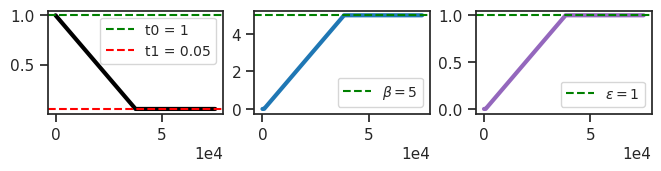

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  412.6 K   |
|     ———      |    ———     |
|    fc_dec    |  104.5 K   |
|     dec      |  308.1 K   |
+--------------+------------+

### Fit model

In [7]:
comment = f"bal-{tr.cfg.kl_balancer}"
fit_name = f"{comment}_{tr.cfg.name()}"

tr.train(fit_name=fit_name)

epoch # 100, avg loss: 17.768325: 100%|███| 100/100 [26:18:59<00:00, 947.40s/it]


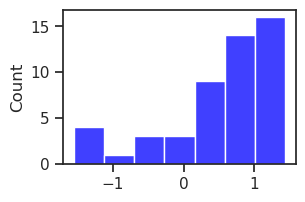

In [11]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

In [9]:
results = tr.analysis(verbose=True)

100%|█████████████████████████████| 125/125 [1:10:55<00:00, 34.05s/it]


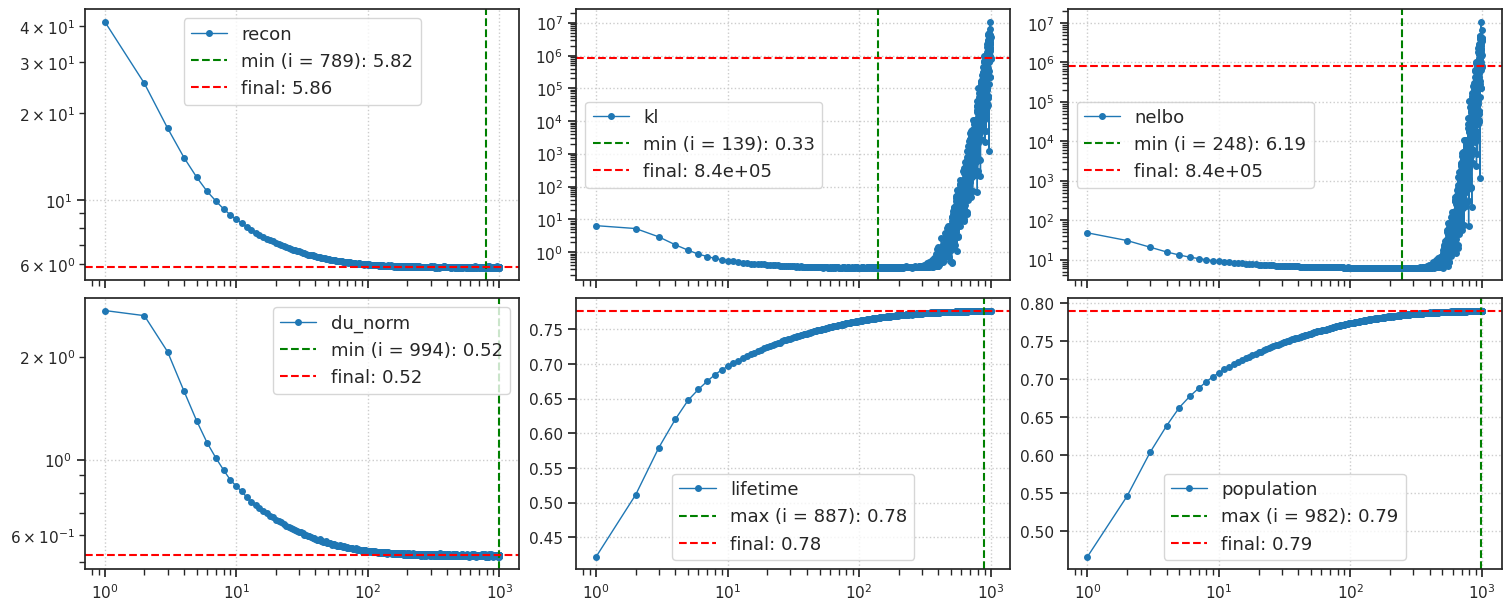

In [10]:
from figures.analysis import plot_convergence
plot_convergence(results)

In [ ]:
# model_name = 'poisson_uniform_c(-4)_BALLS16_t-50_z-[32]_k-32_<conv+b|lin>'
# fit_name = 'lat-15_mc_b400-ep1000-lr(0.002)_beta(200:0x0.5)_temp(0.05:lin-0.5)_gr(250)_(2024_08_25,23:49)'
# tr, meta = load_model(model_name, fit_name, device=device)

In [12]:
self = tr.model.input_layer
self.reset_state(64)

dist, z, pred = self.generate(0.0)

In [19]:
with torch.no_grad():
    output = forward(tr.model, pred, override_x=True, seq=range(300))
    output = output.stack()

list(output)

['recon', 'ff', 'fb', 'spks', 'dist', 'loss_kl', 'loss_recon']

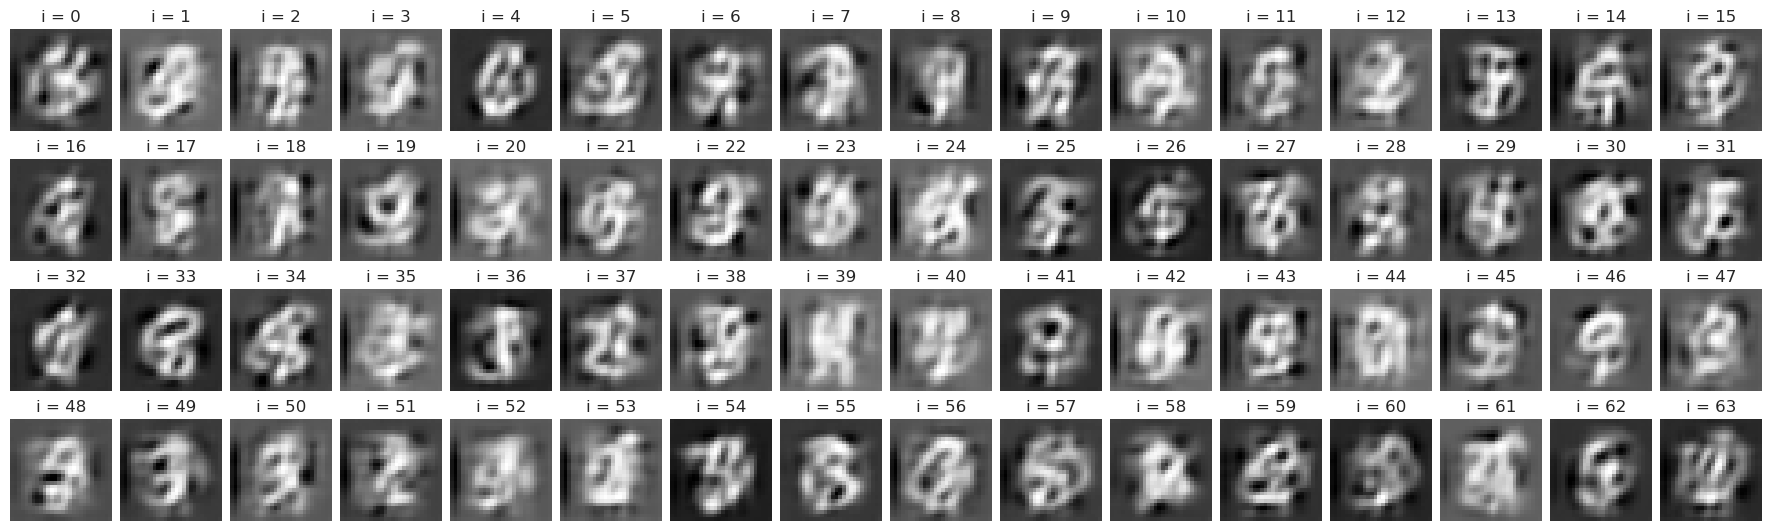

In [21]:
nrows = 4
ncols = int(np.ceil(len(pred) / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(28, 28))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

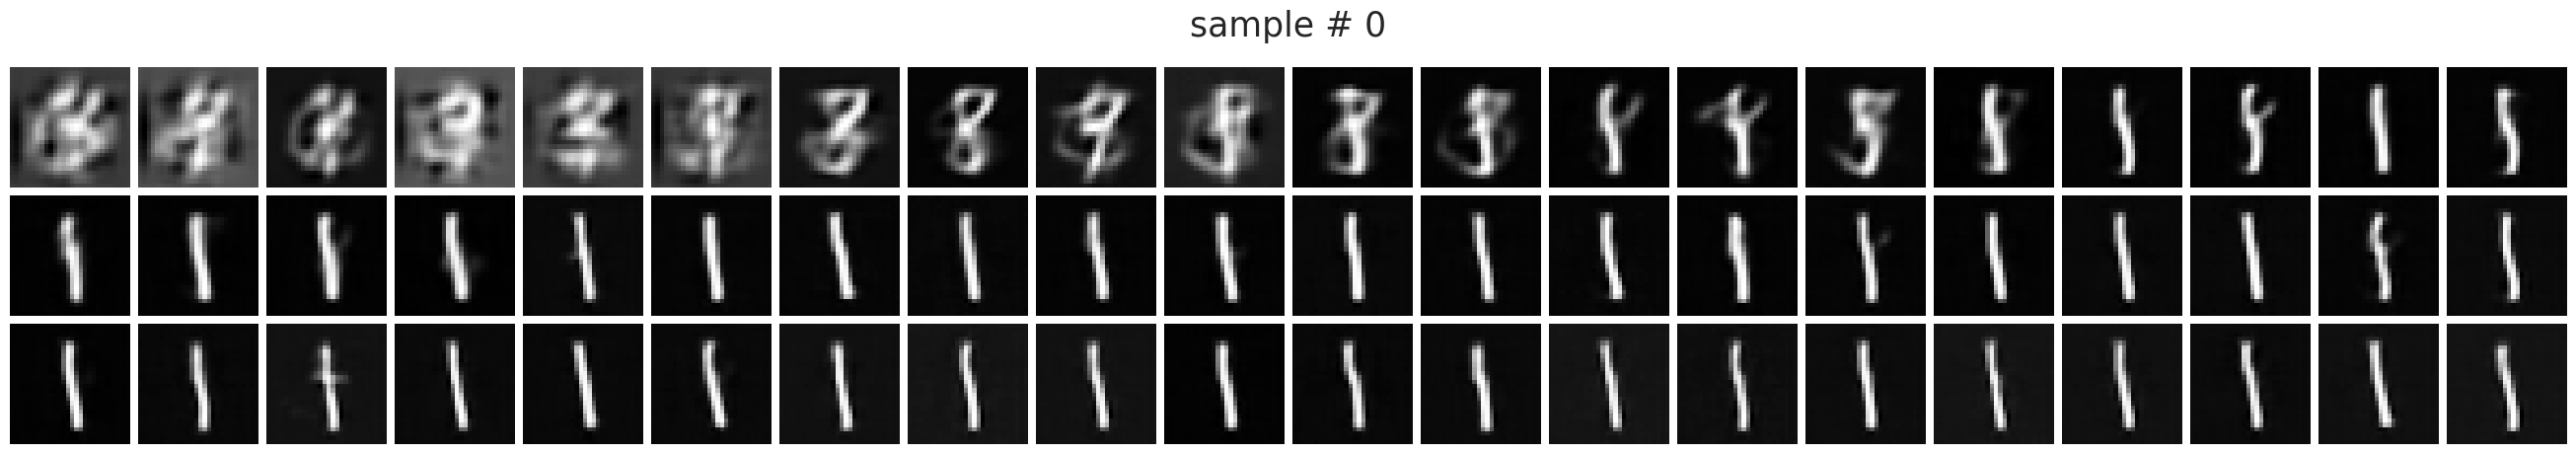

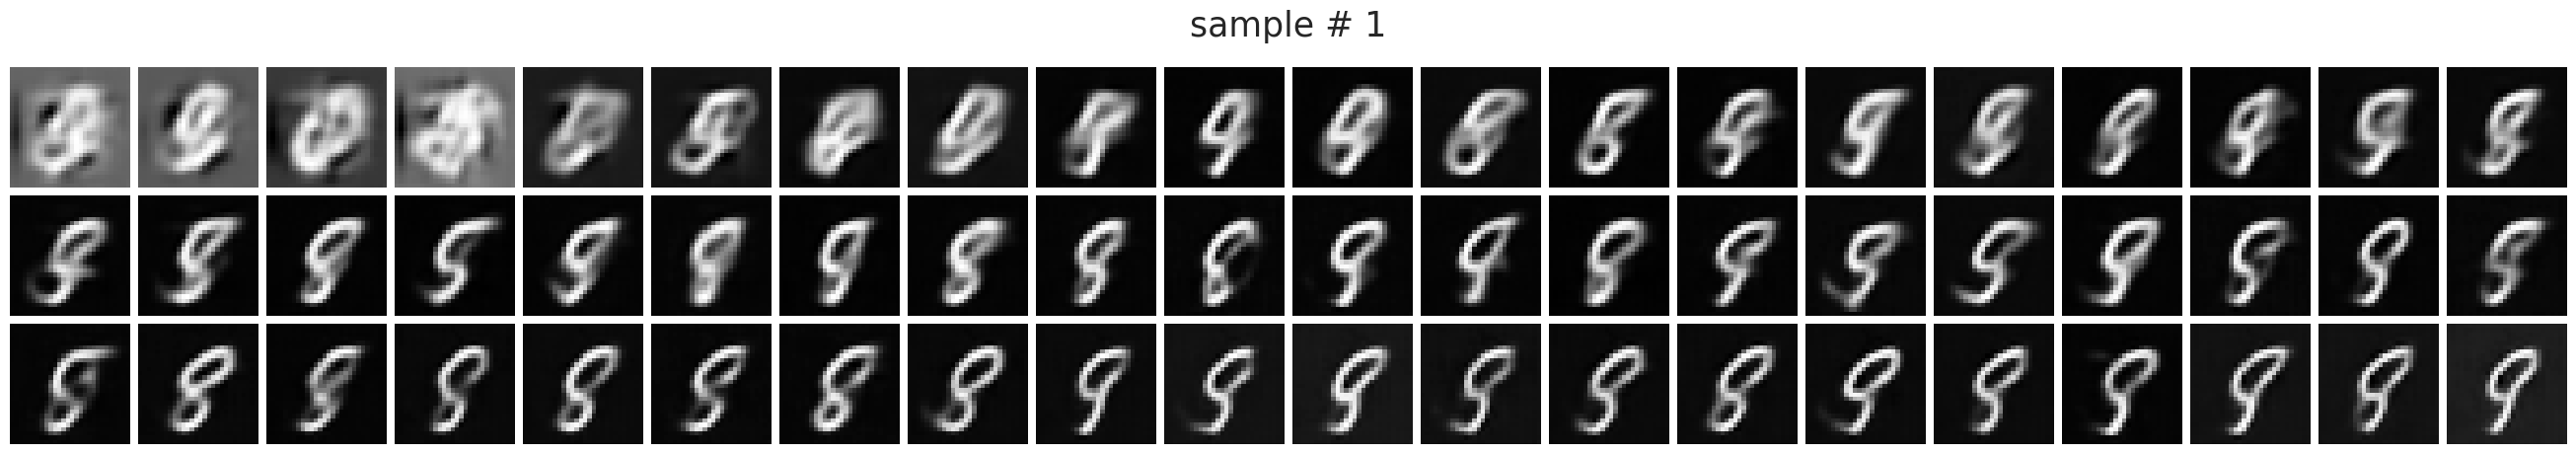

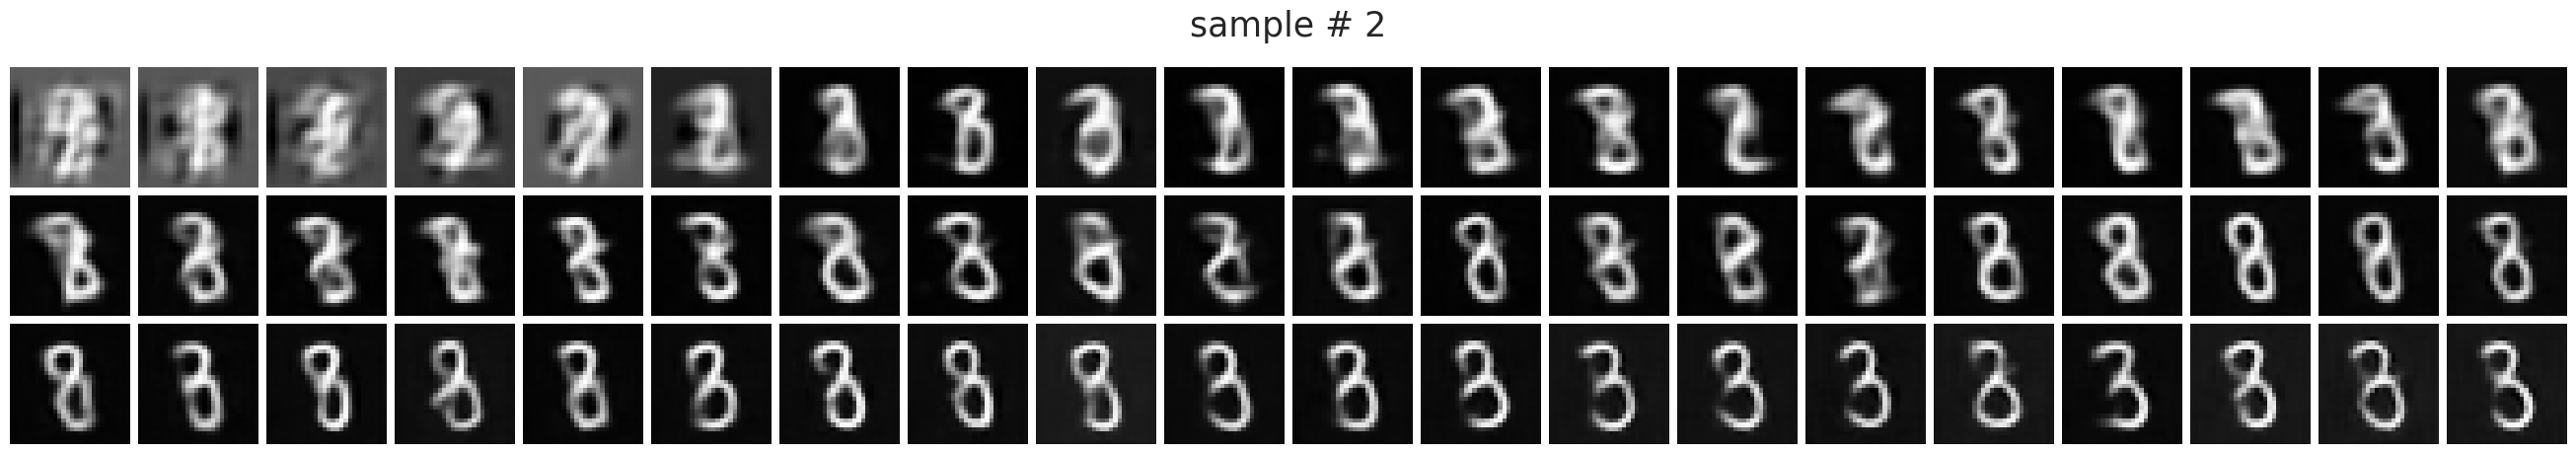

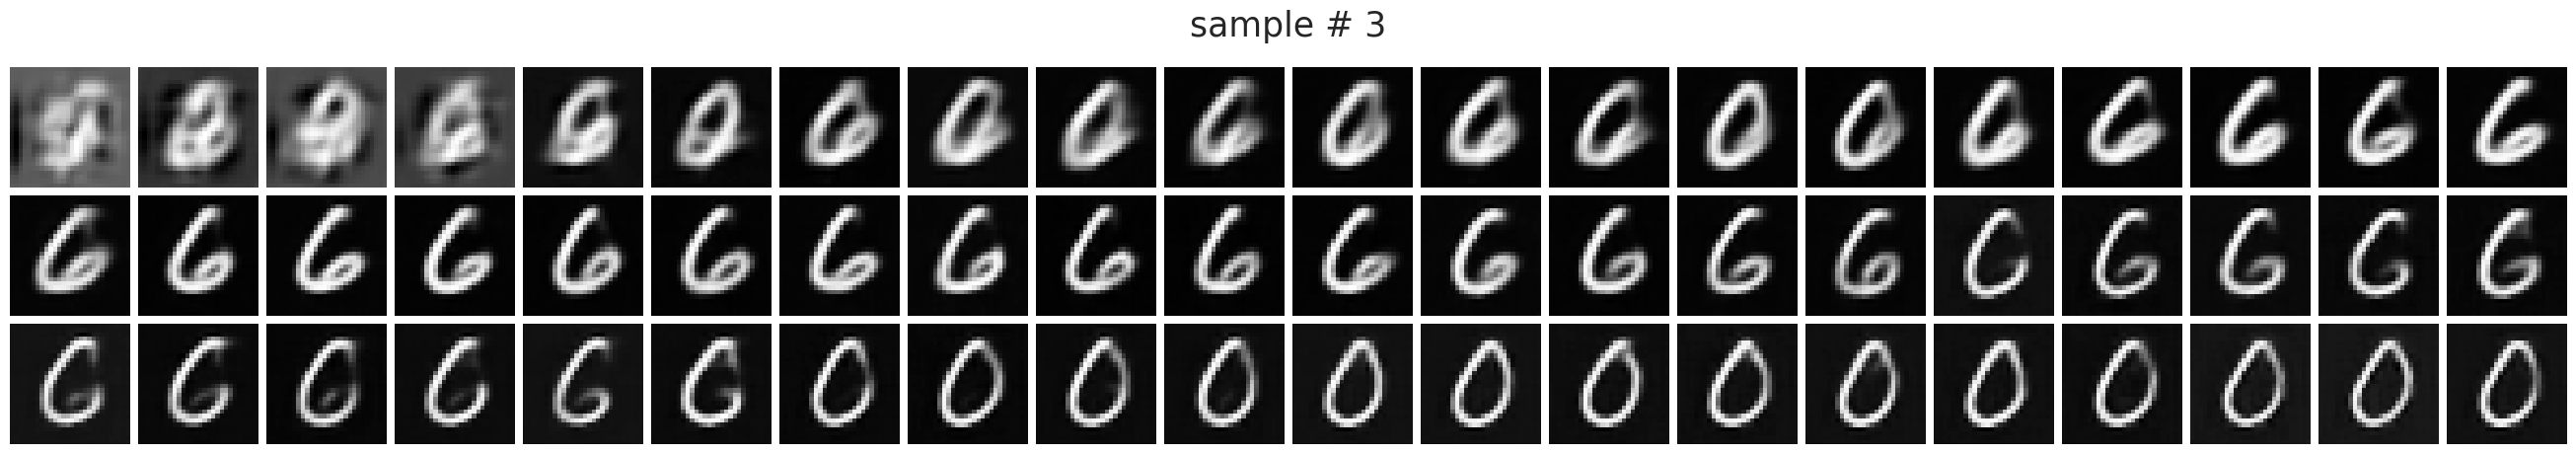

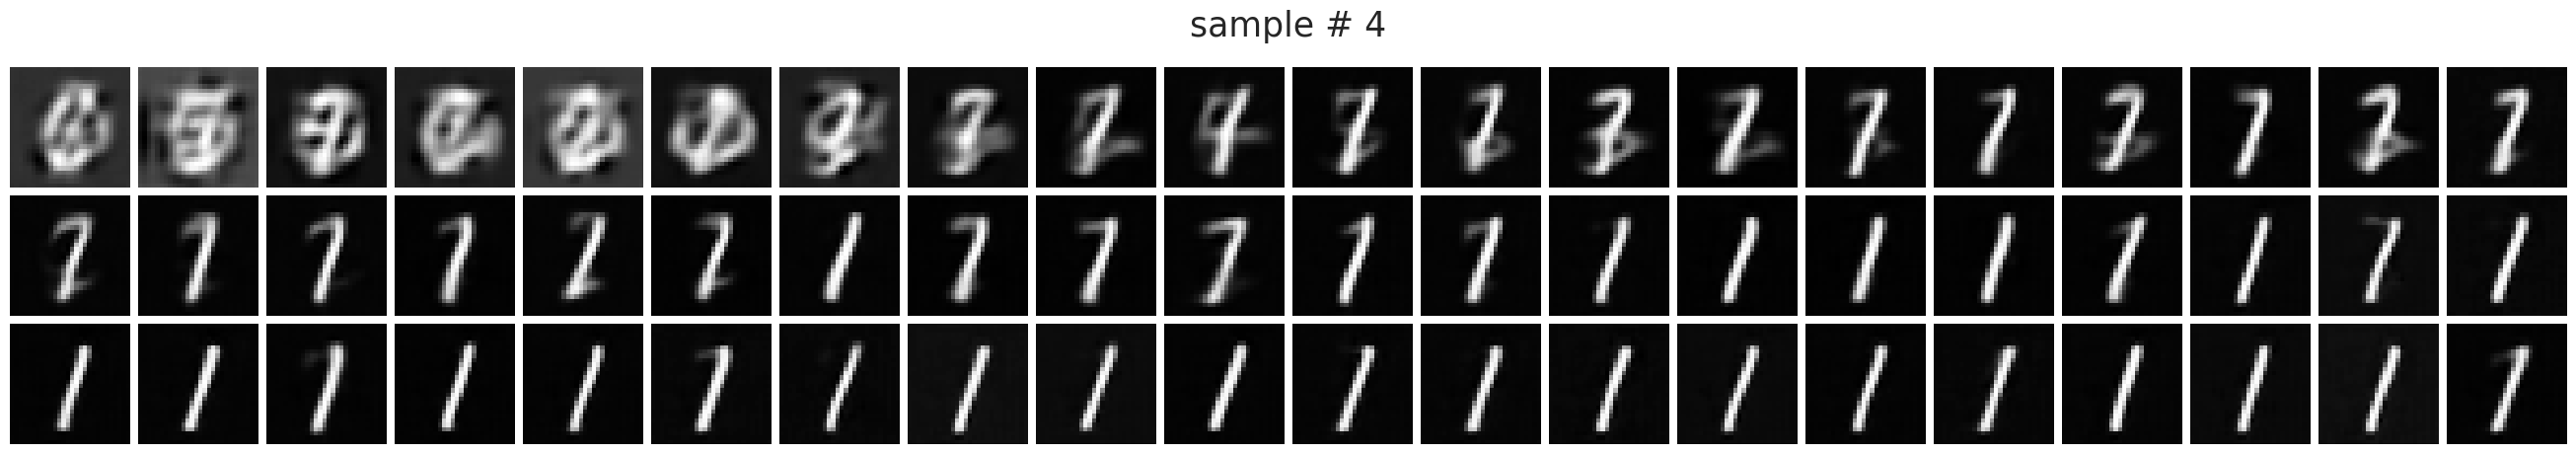

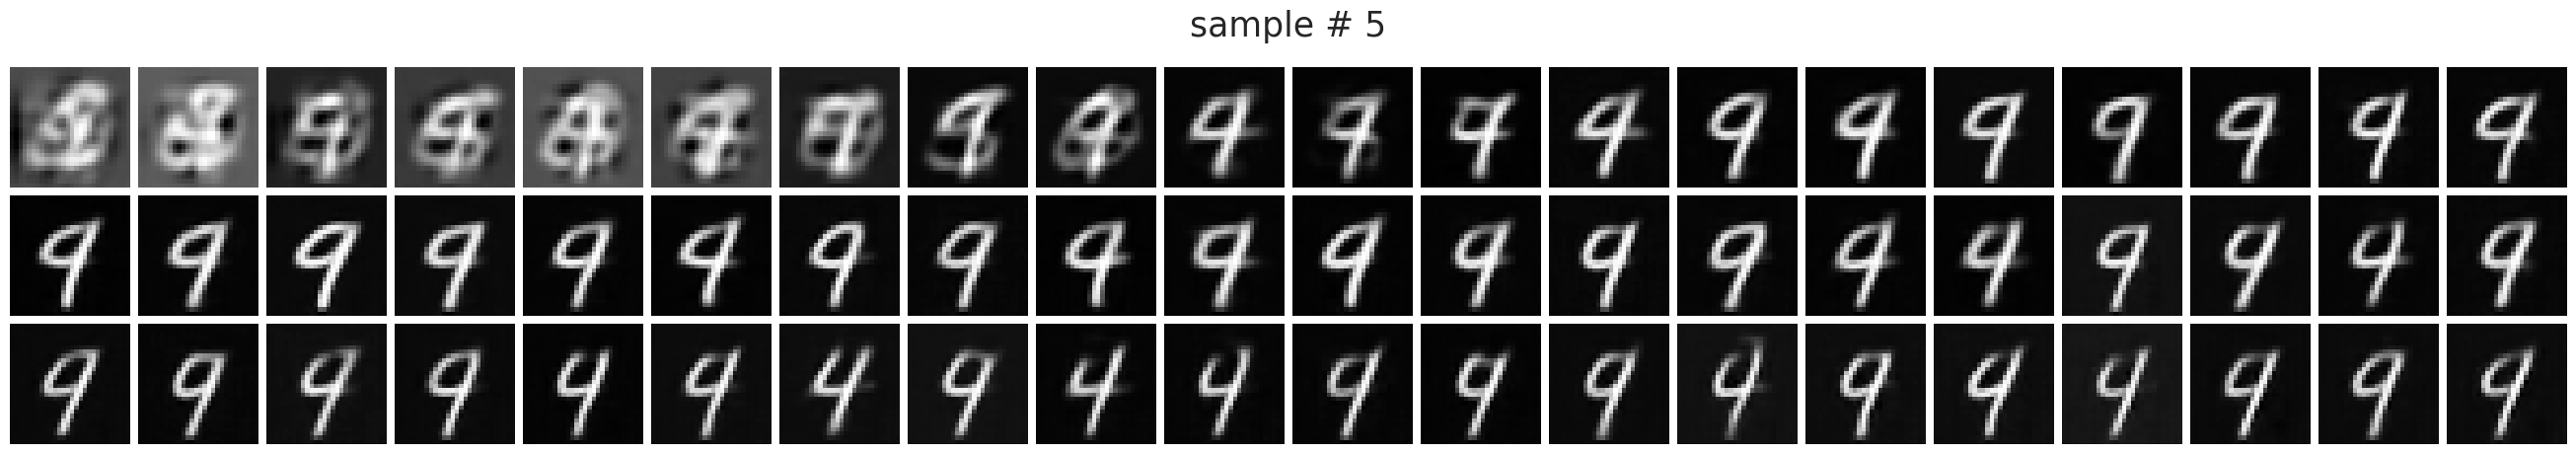

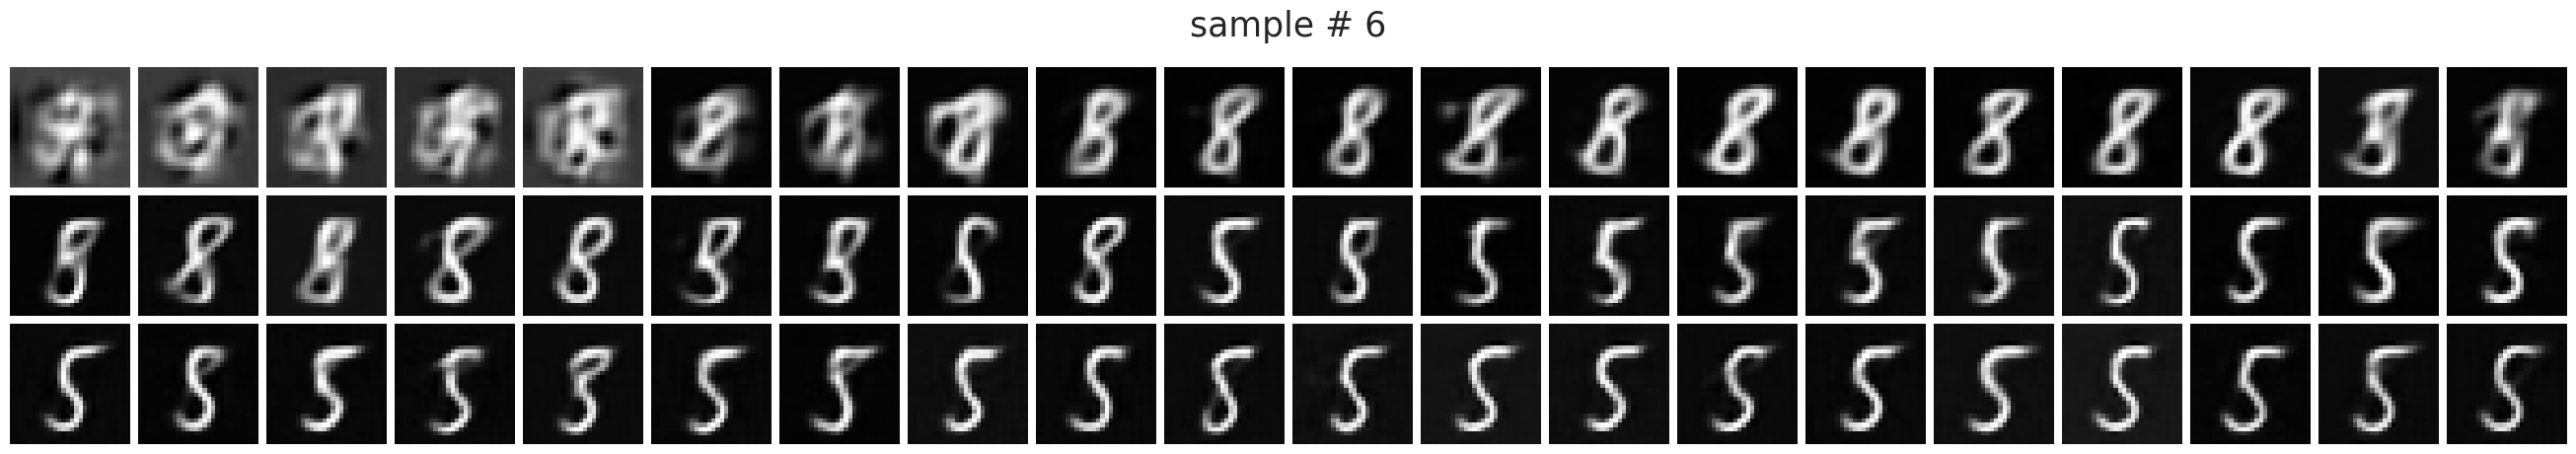

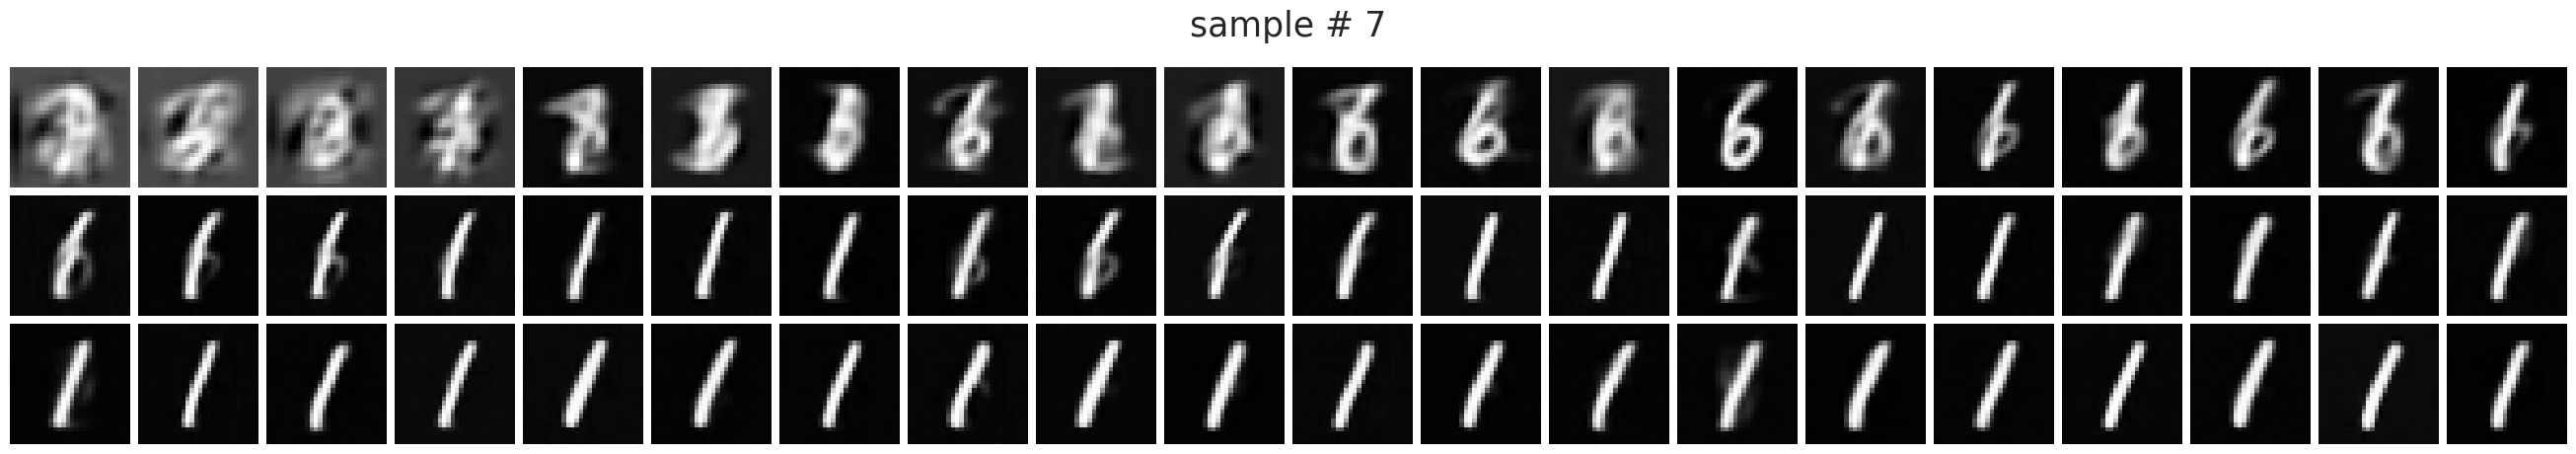

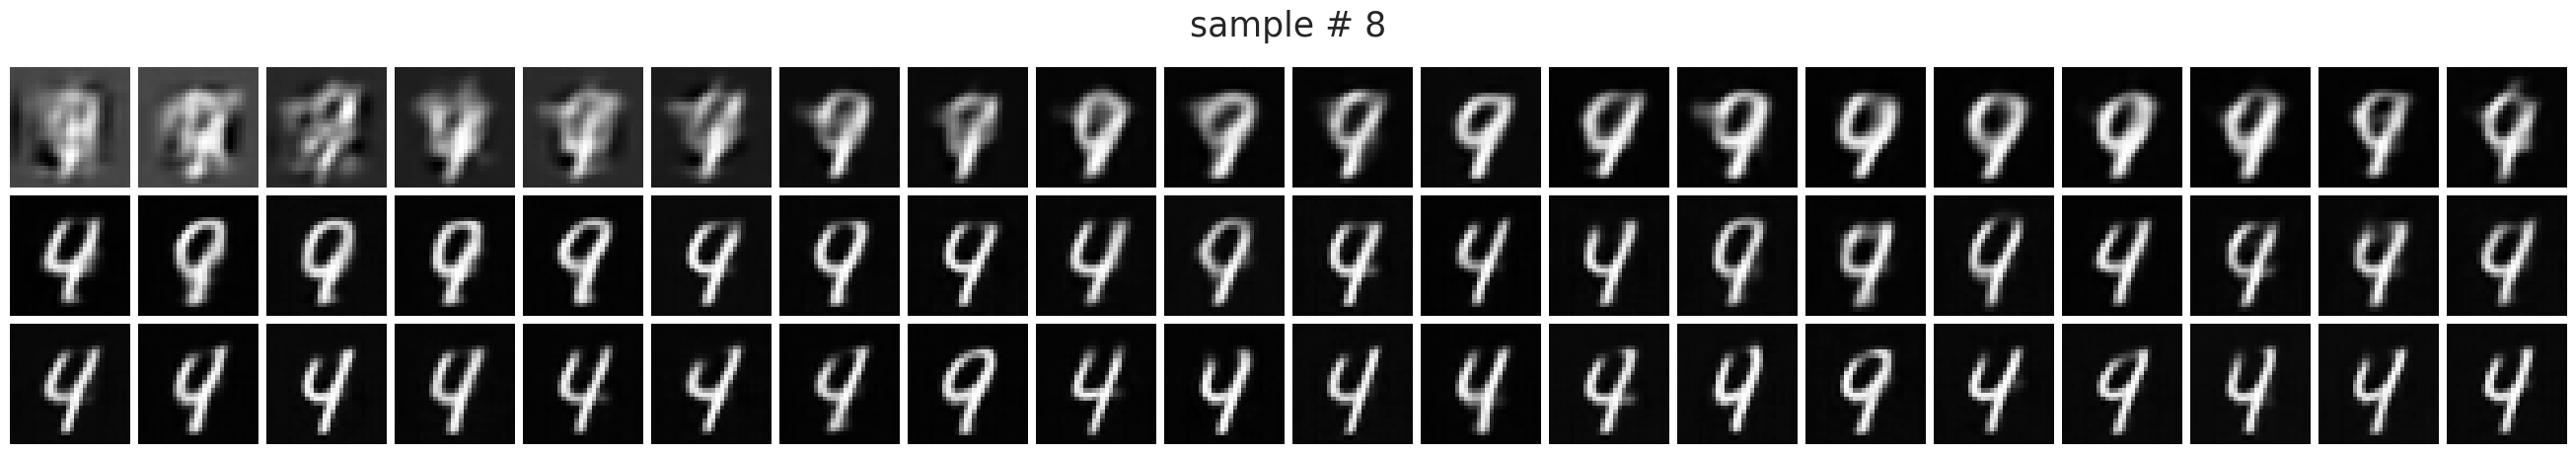

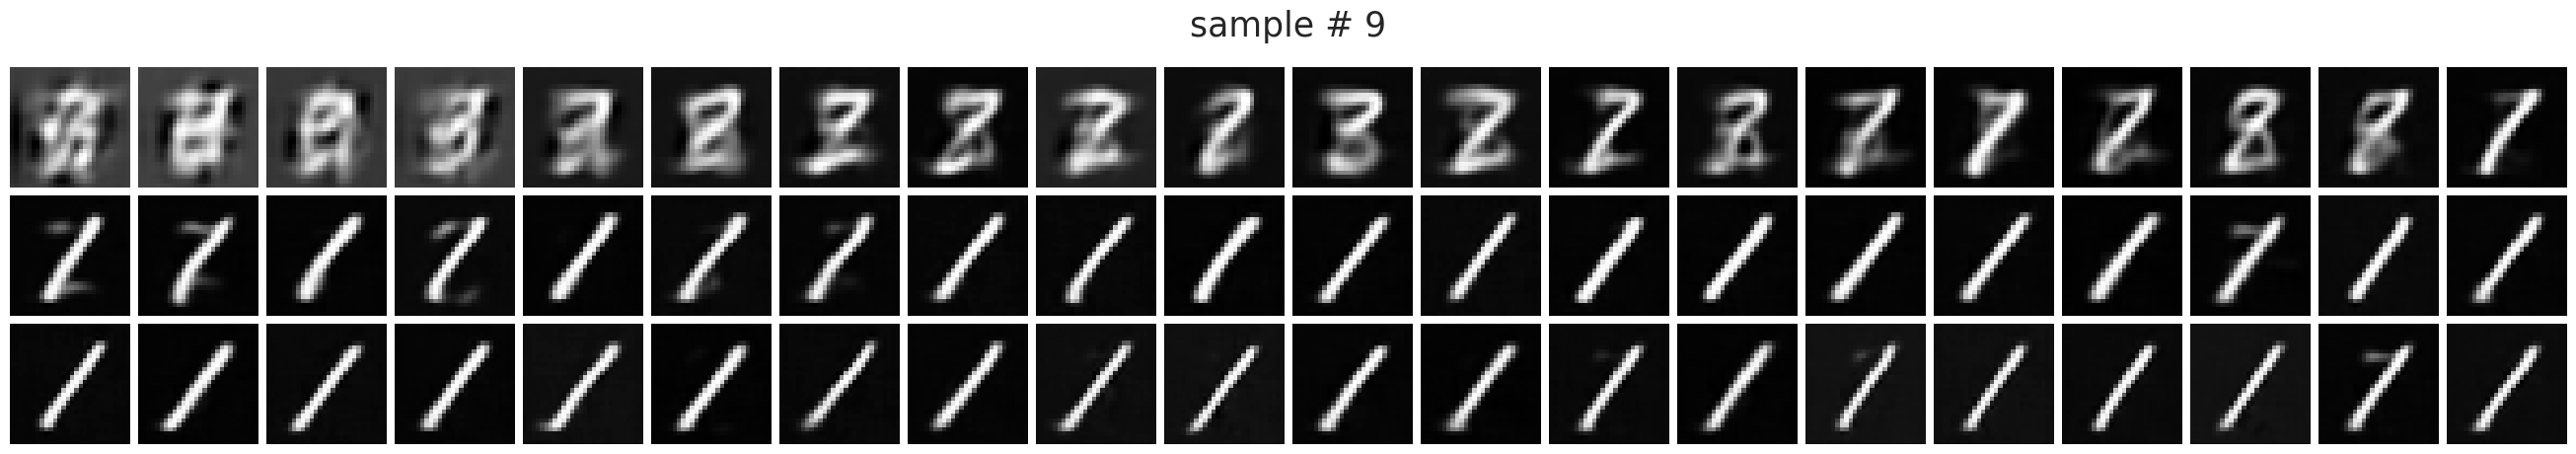

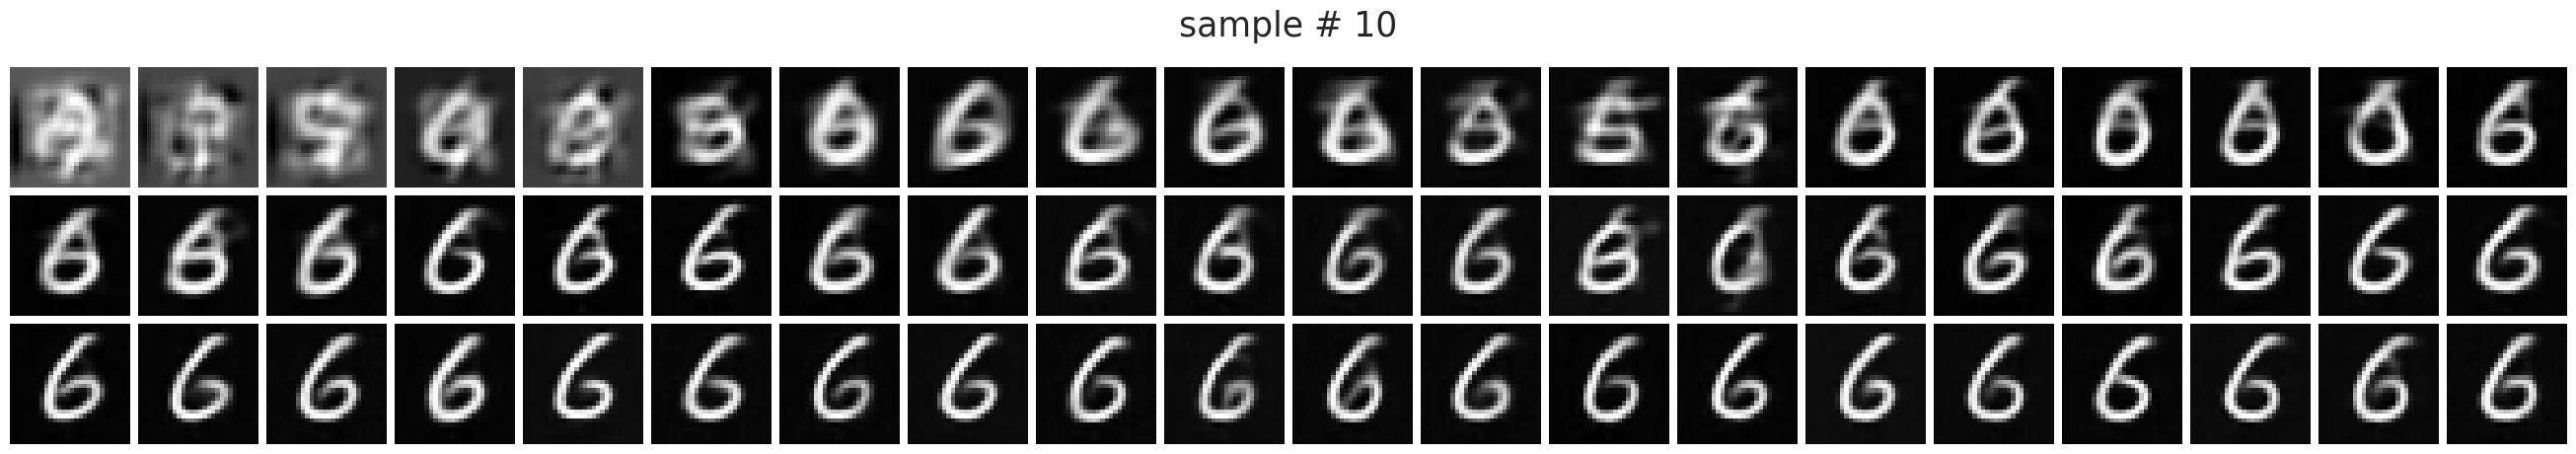

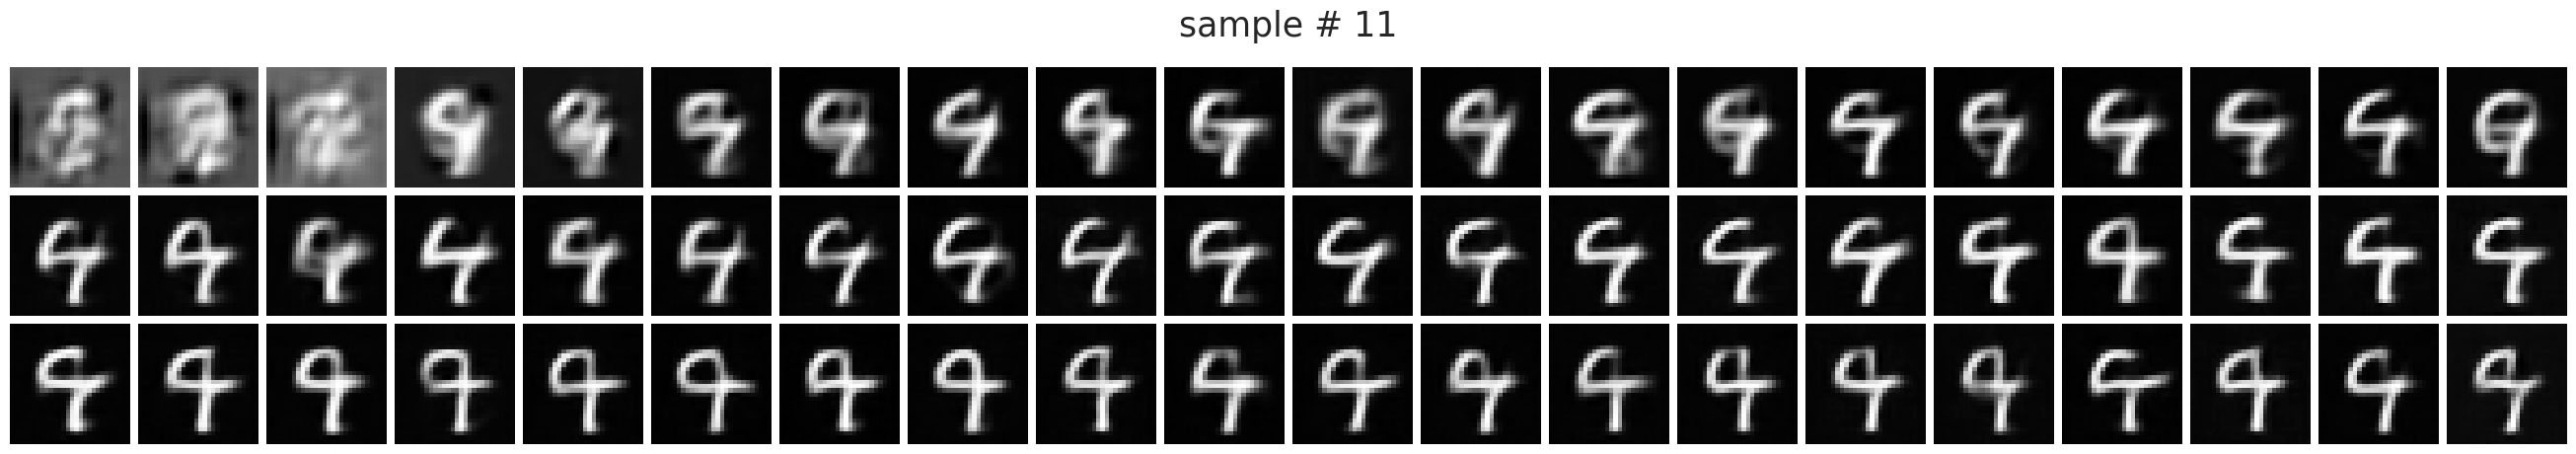

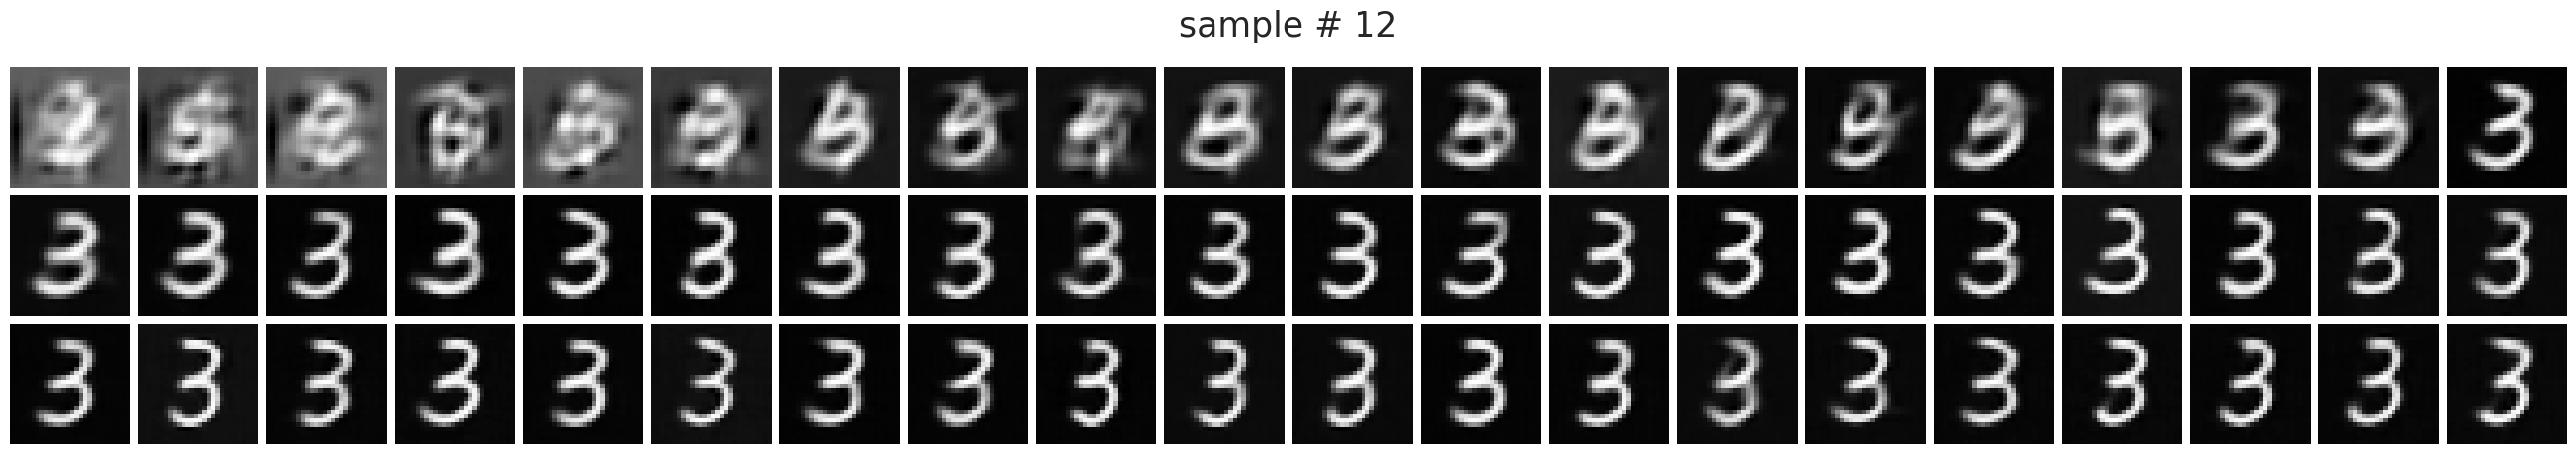

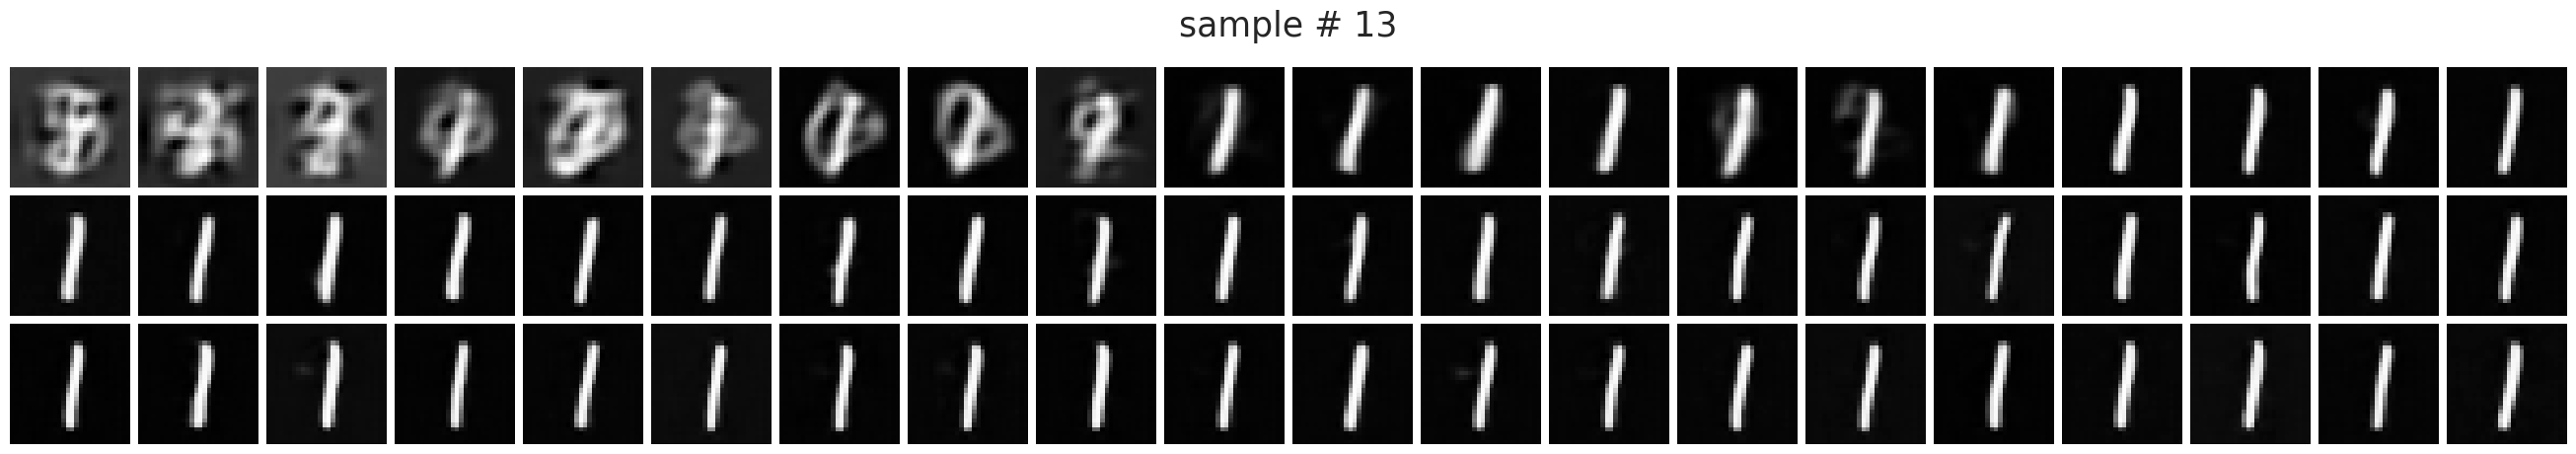

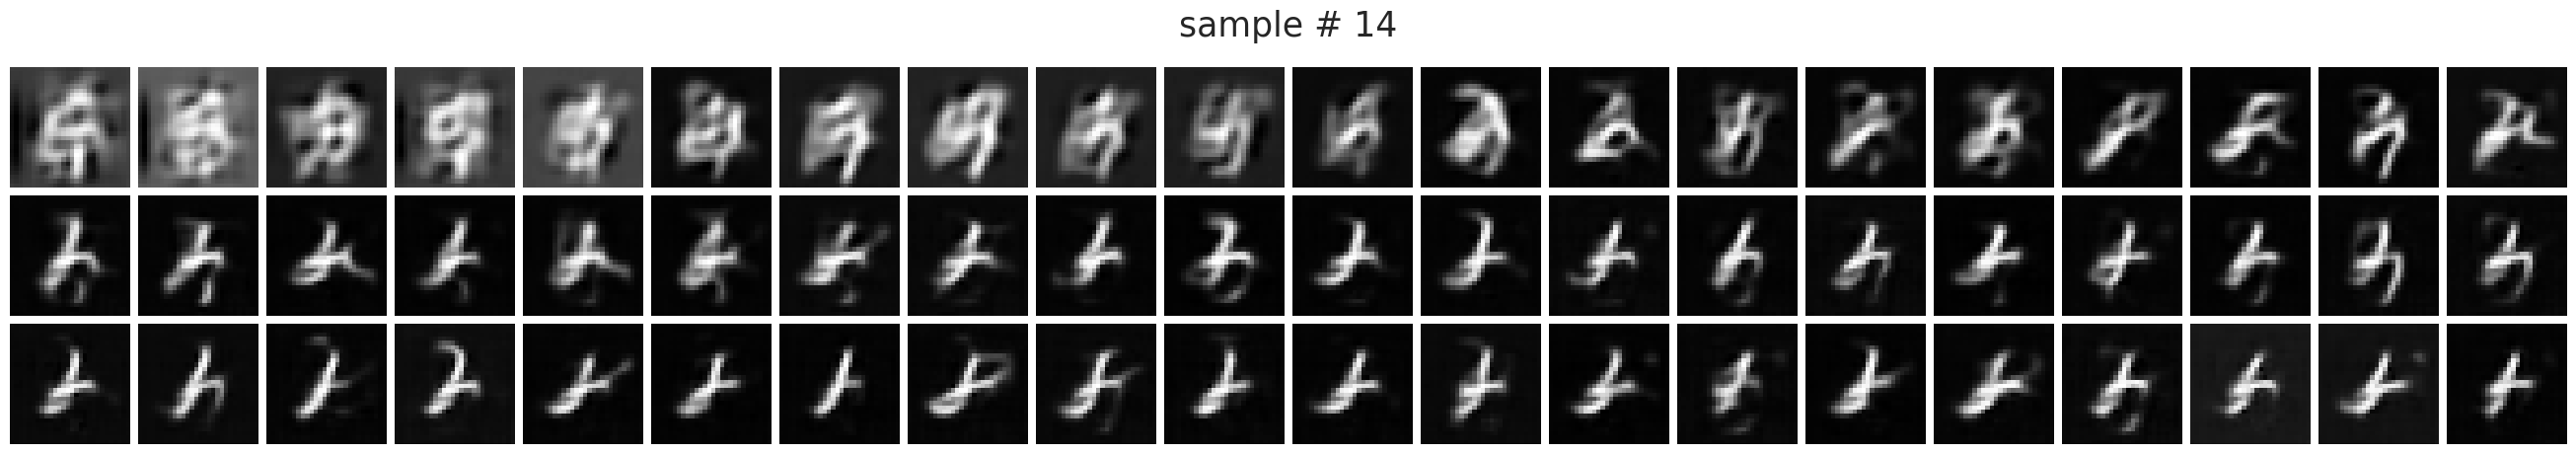

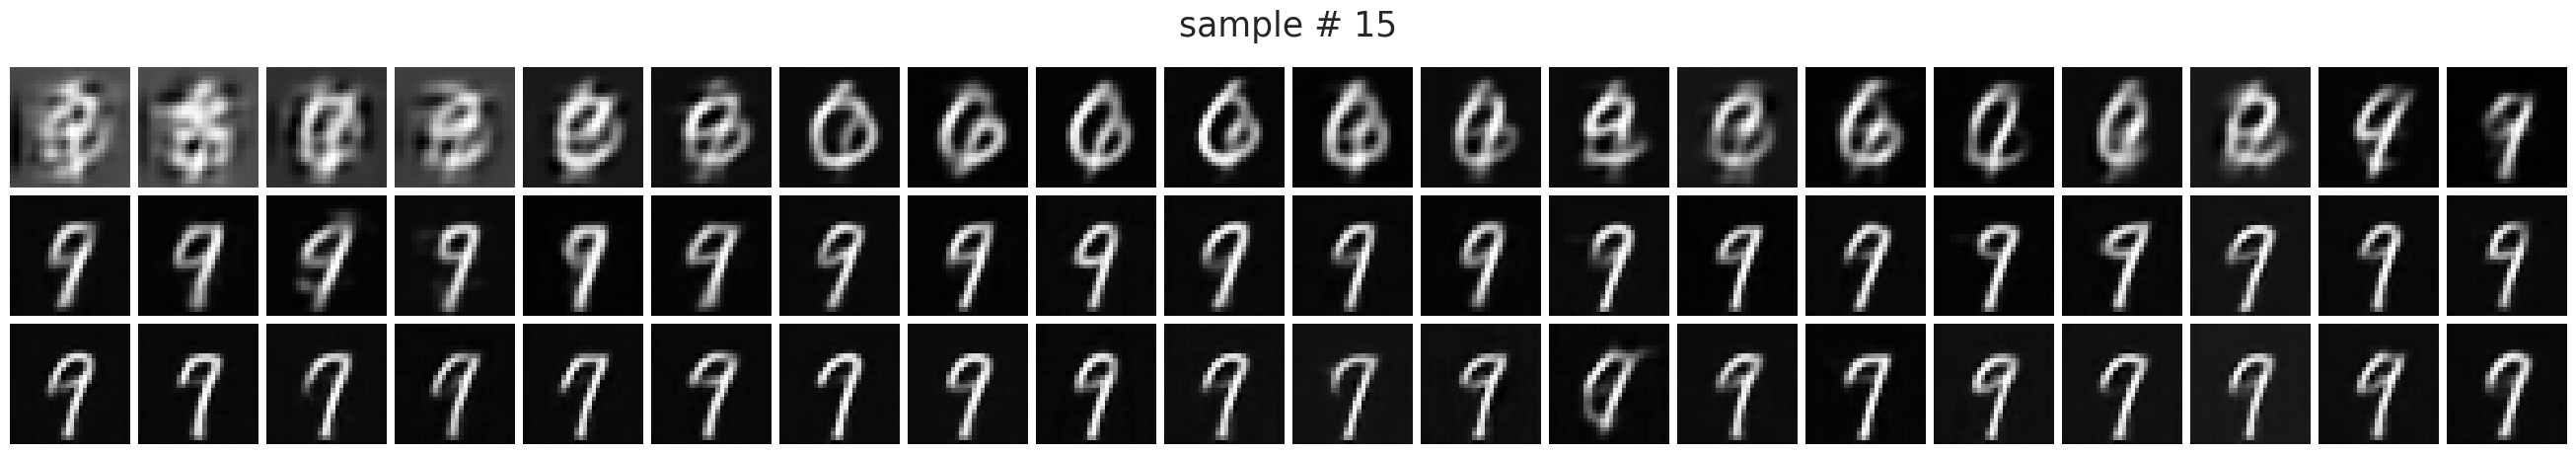

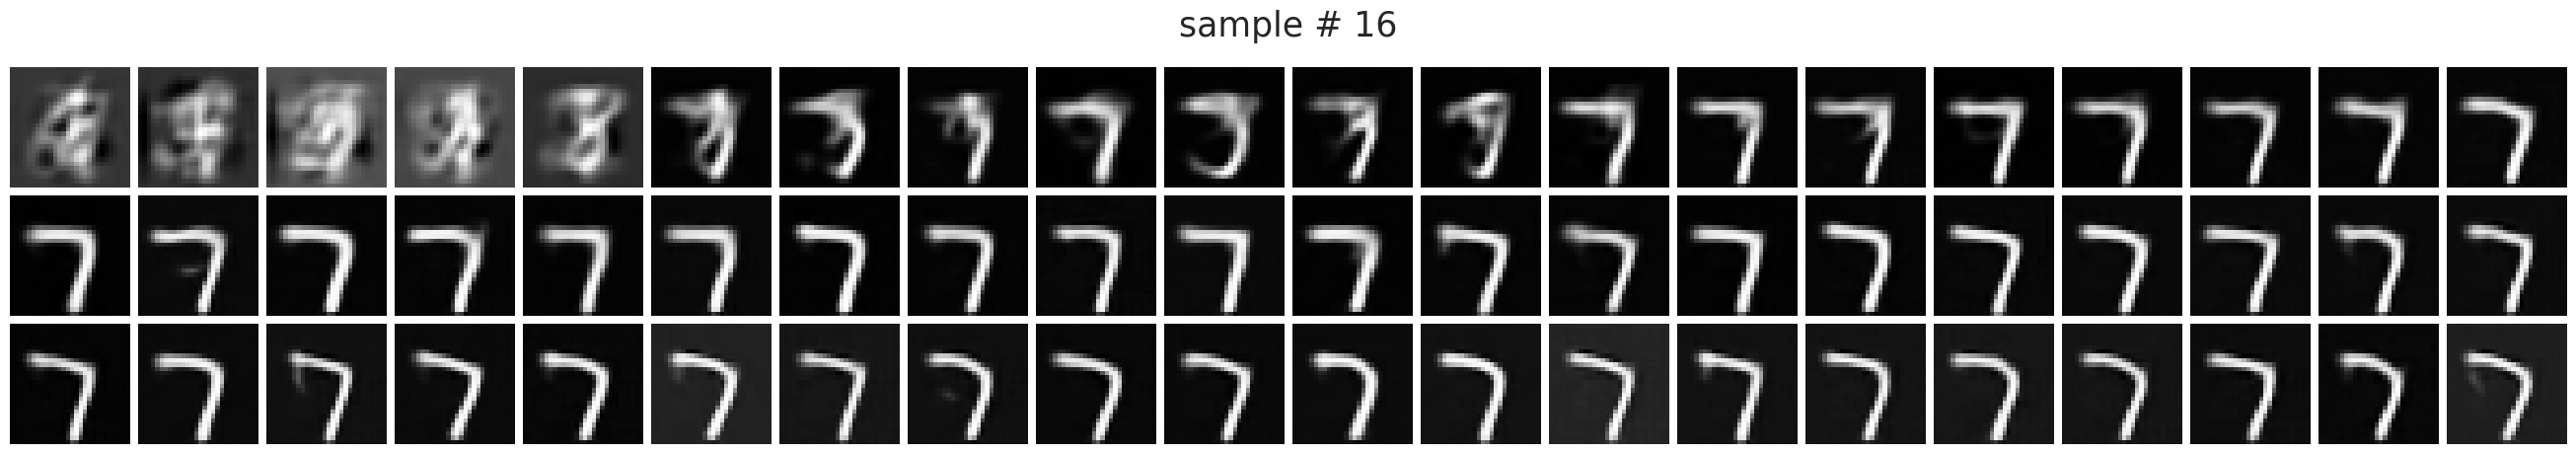

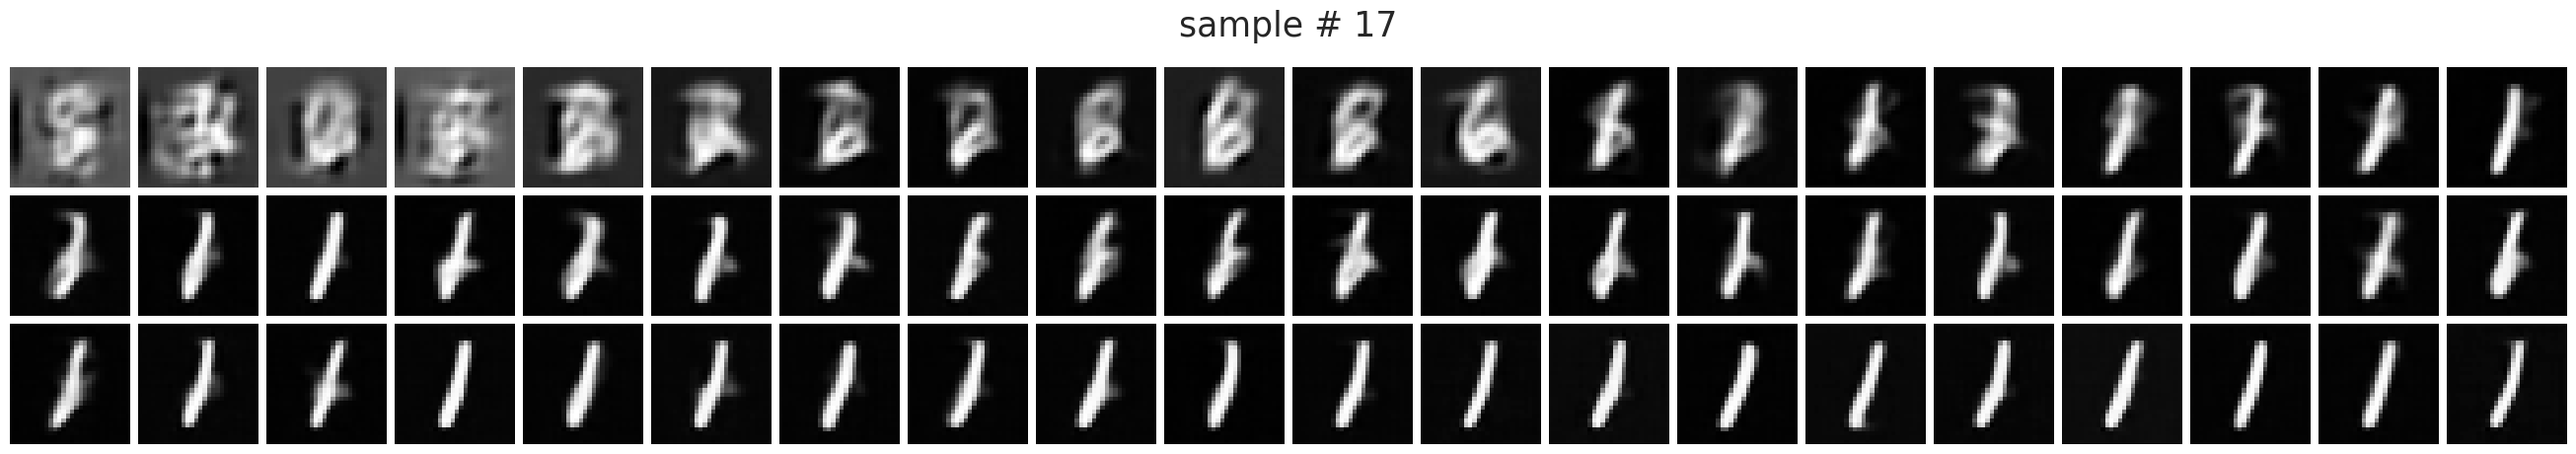

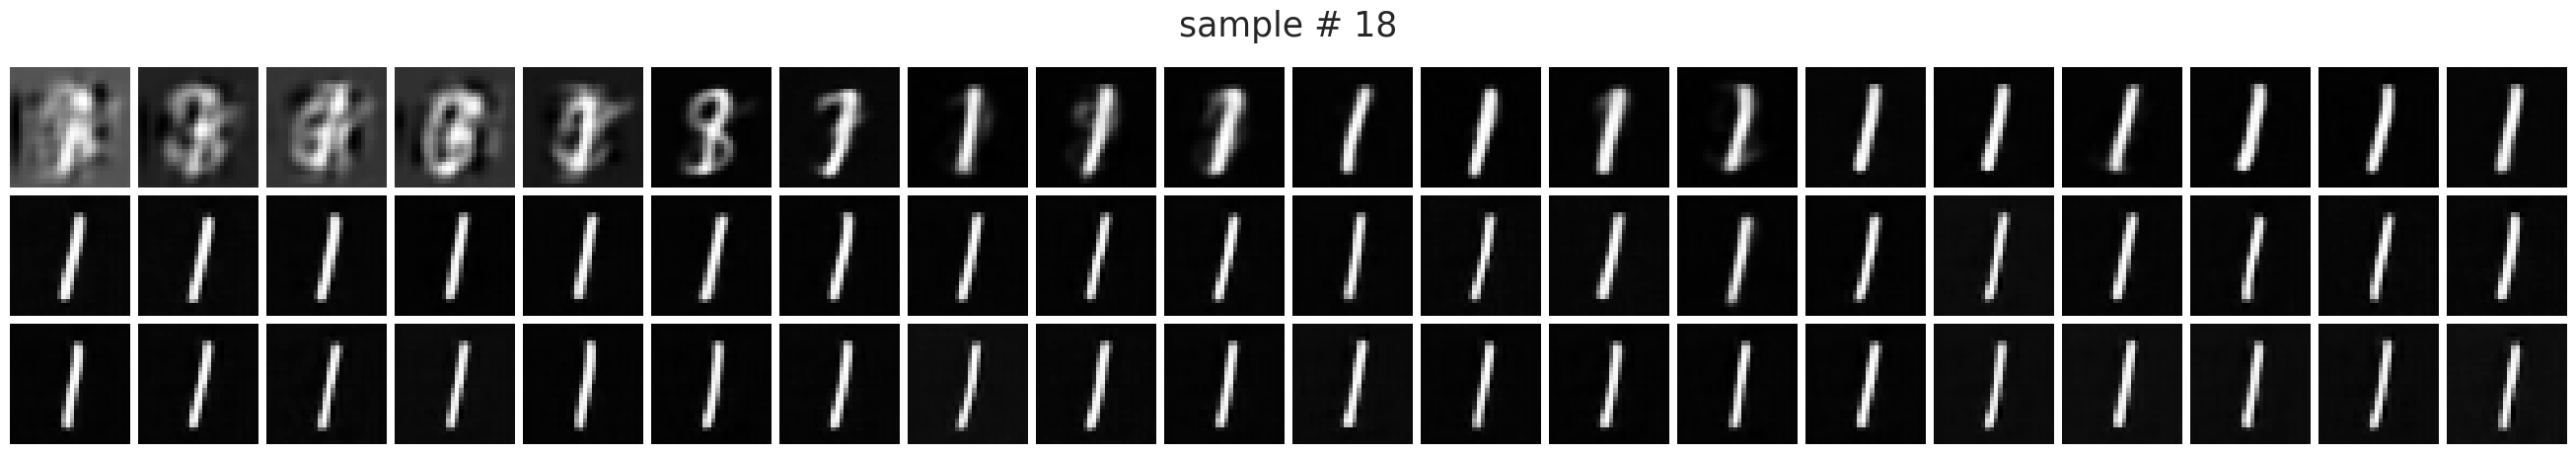

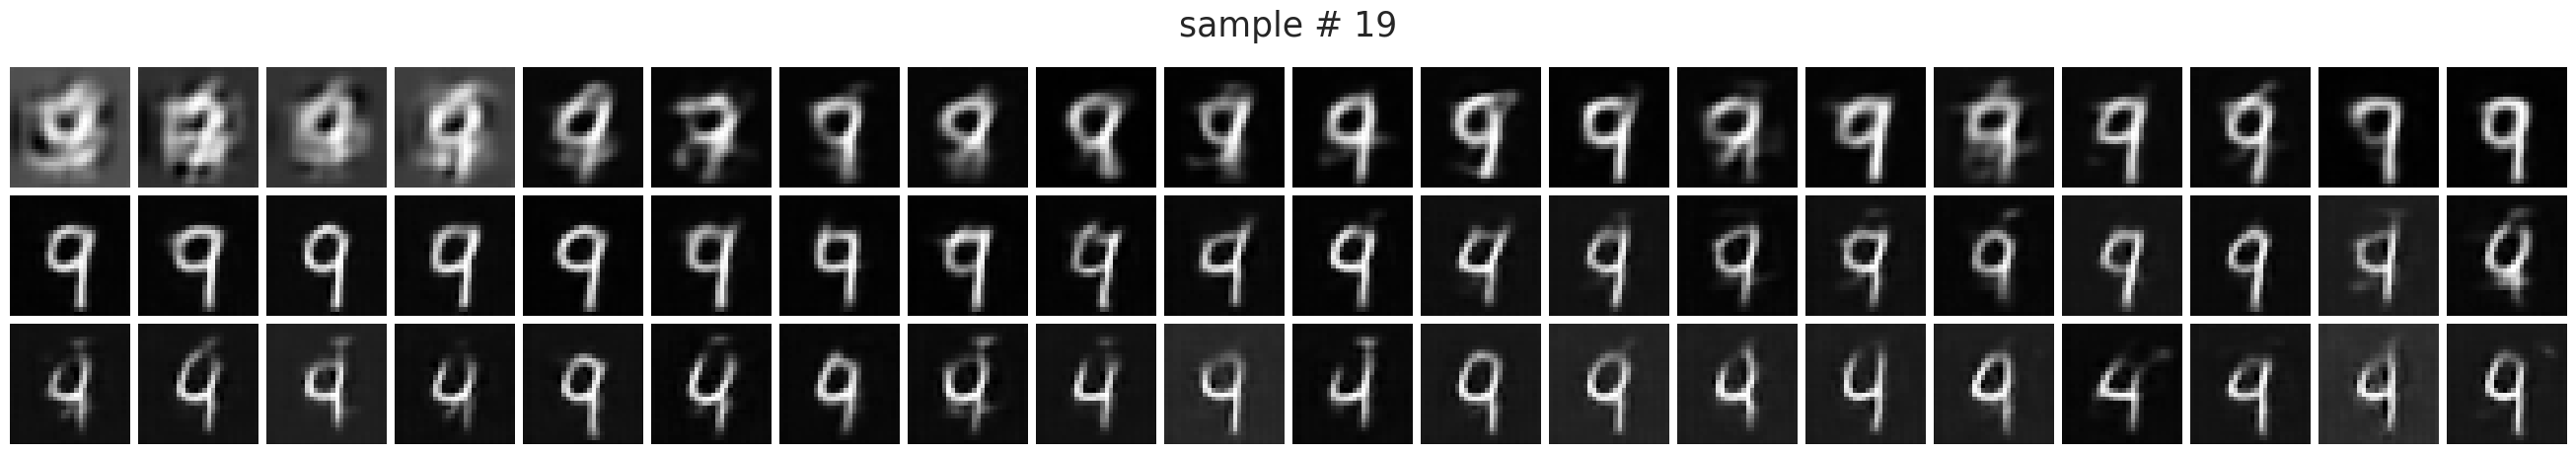

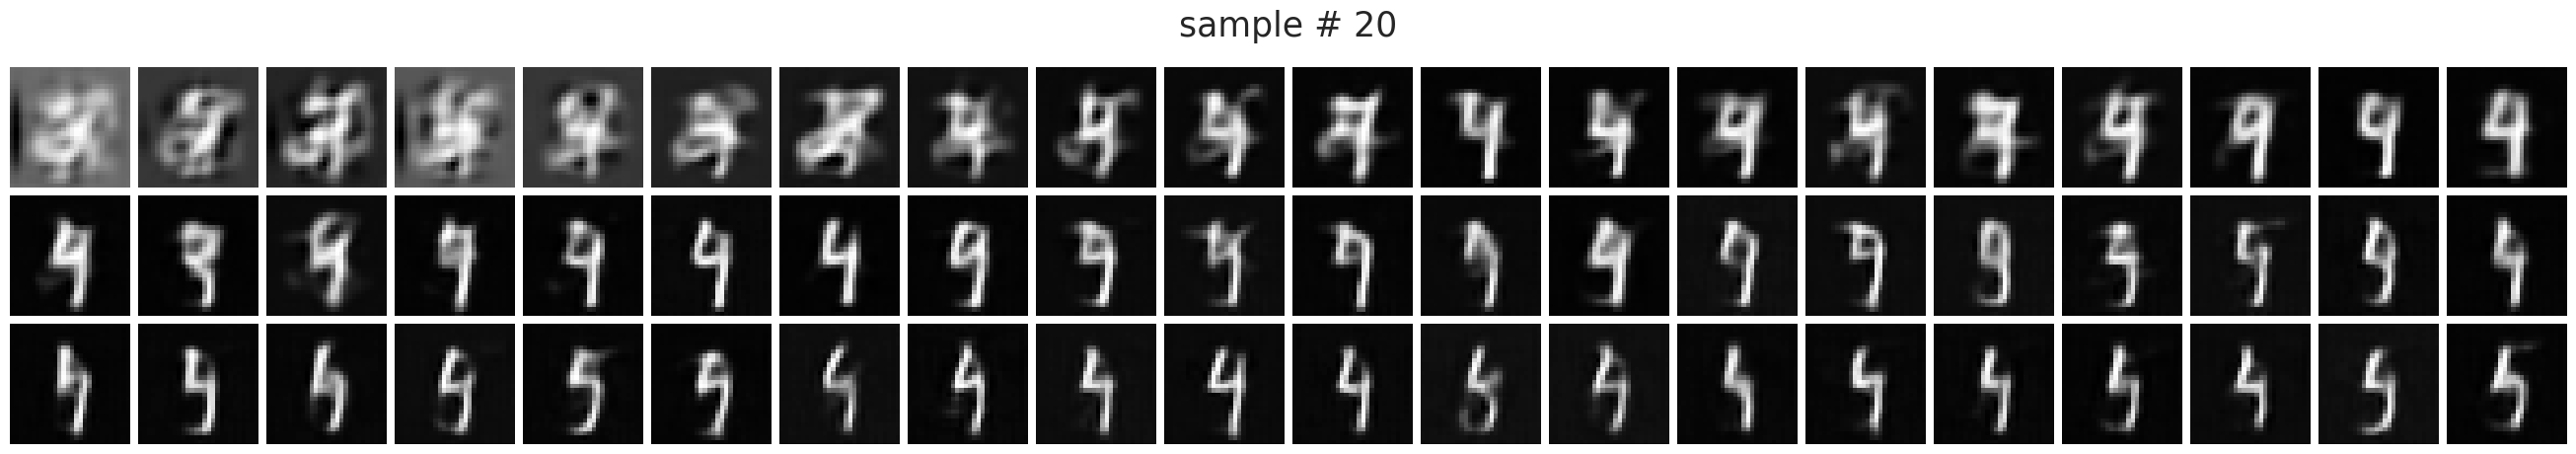

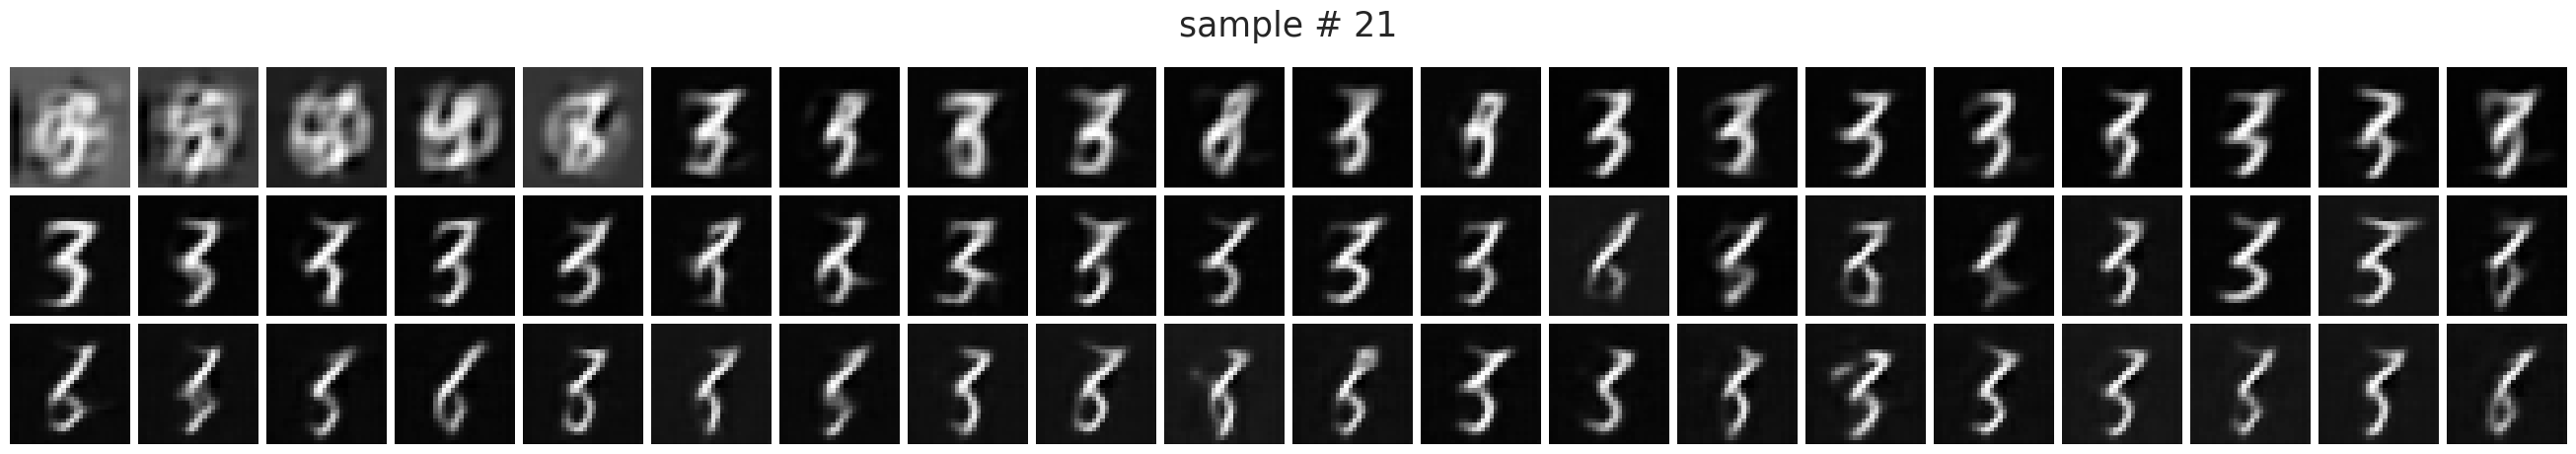

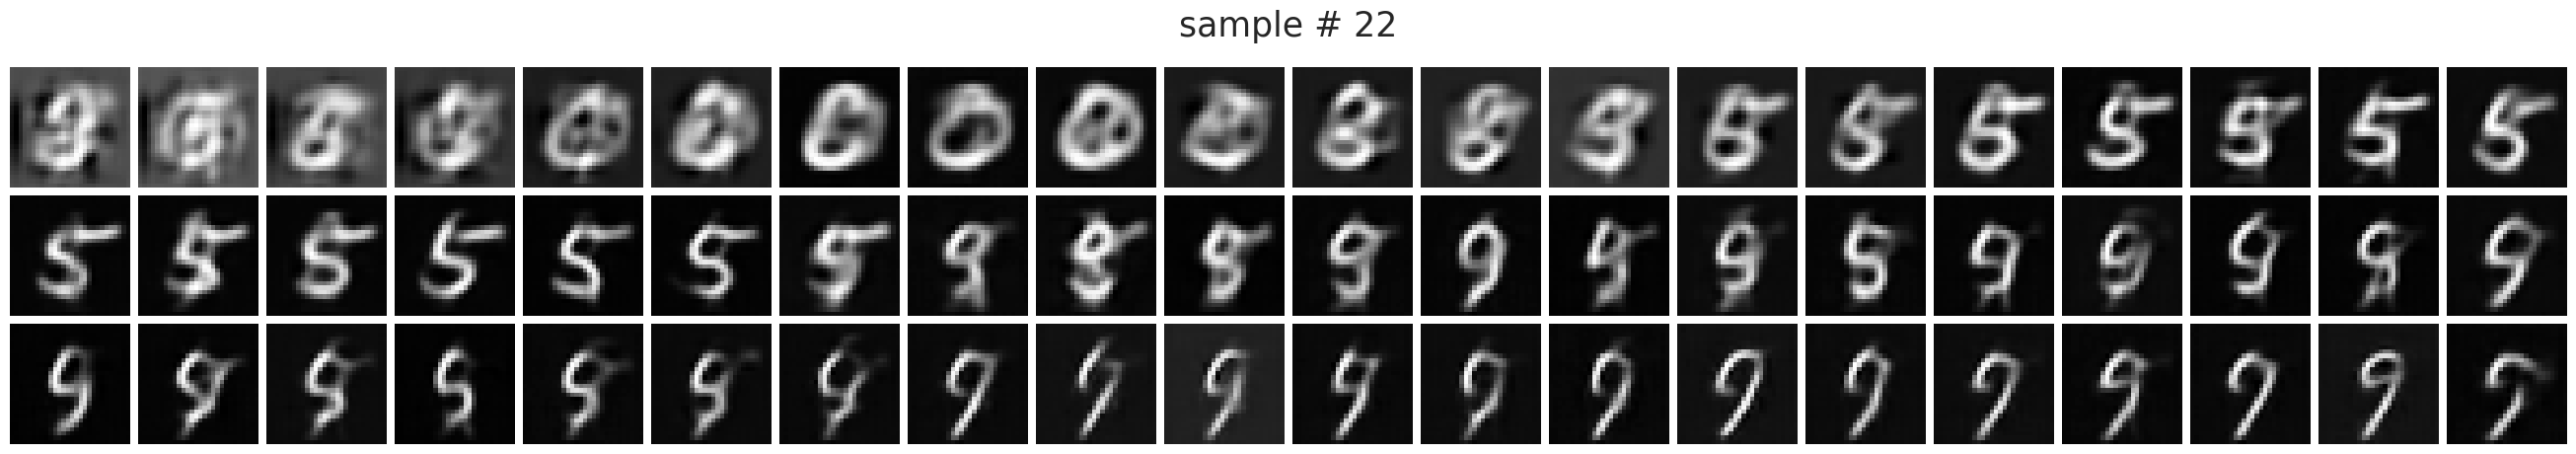

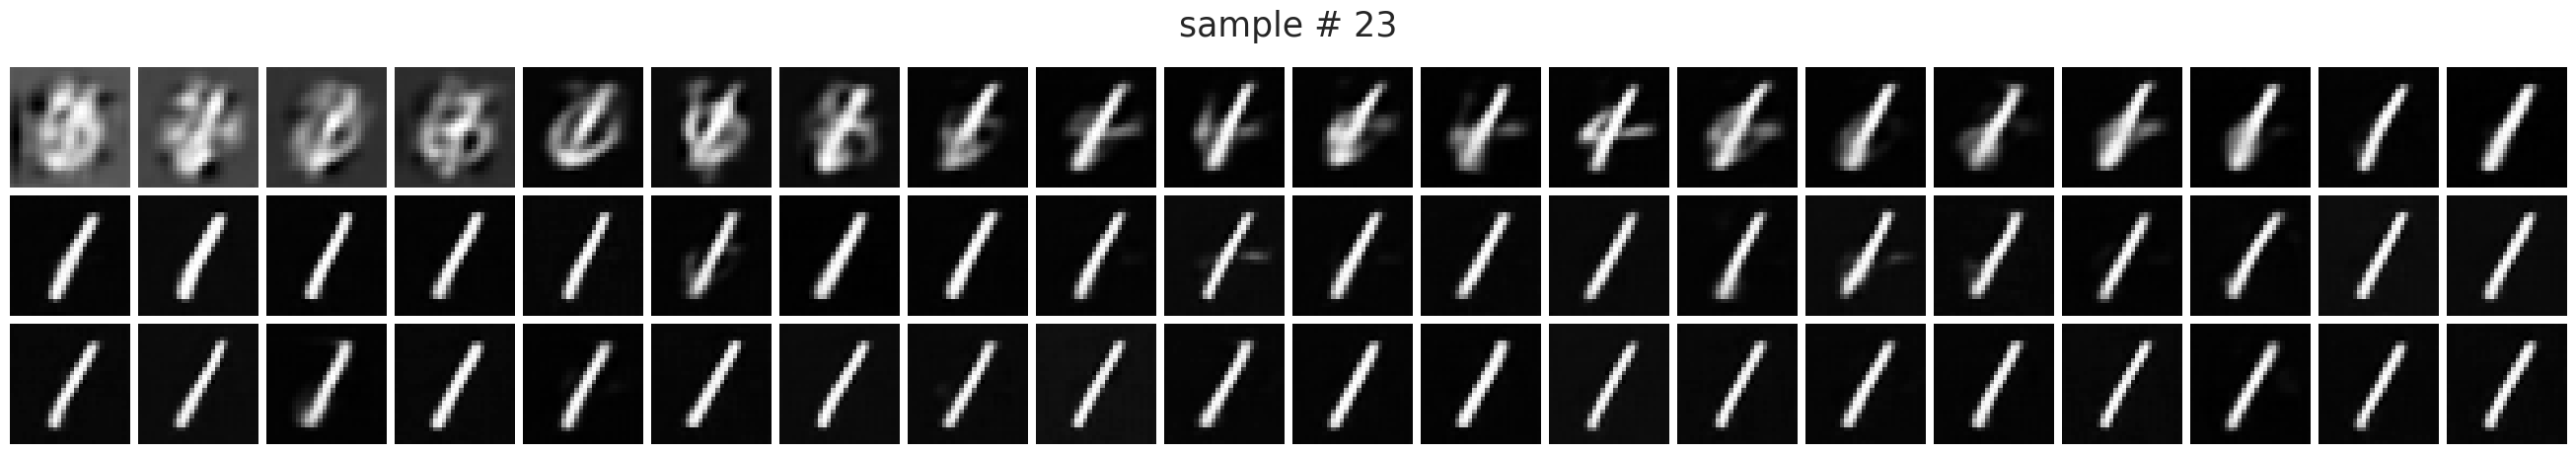

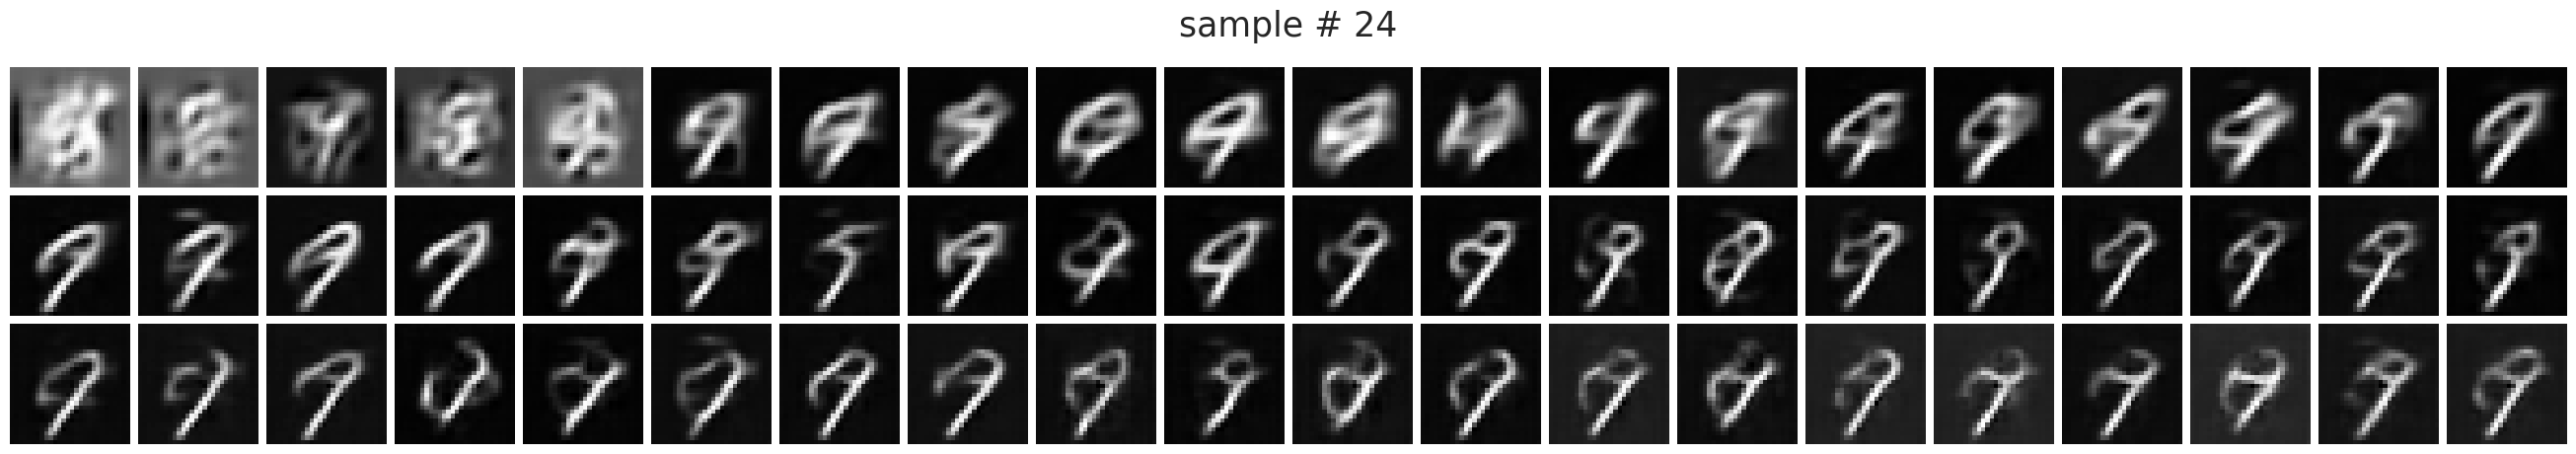

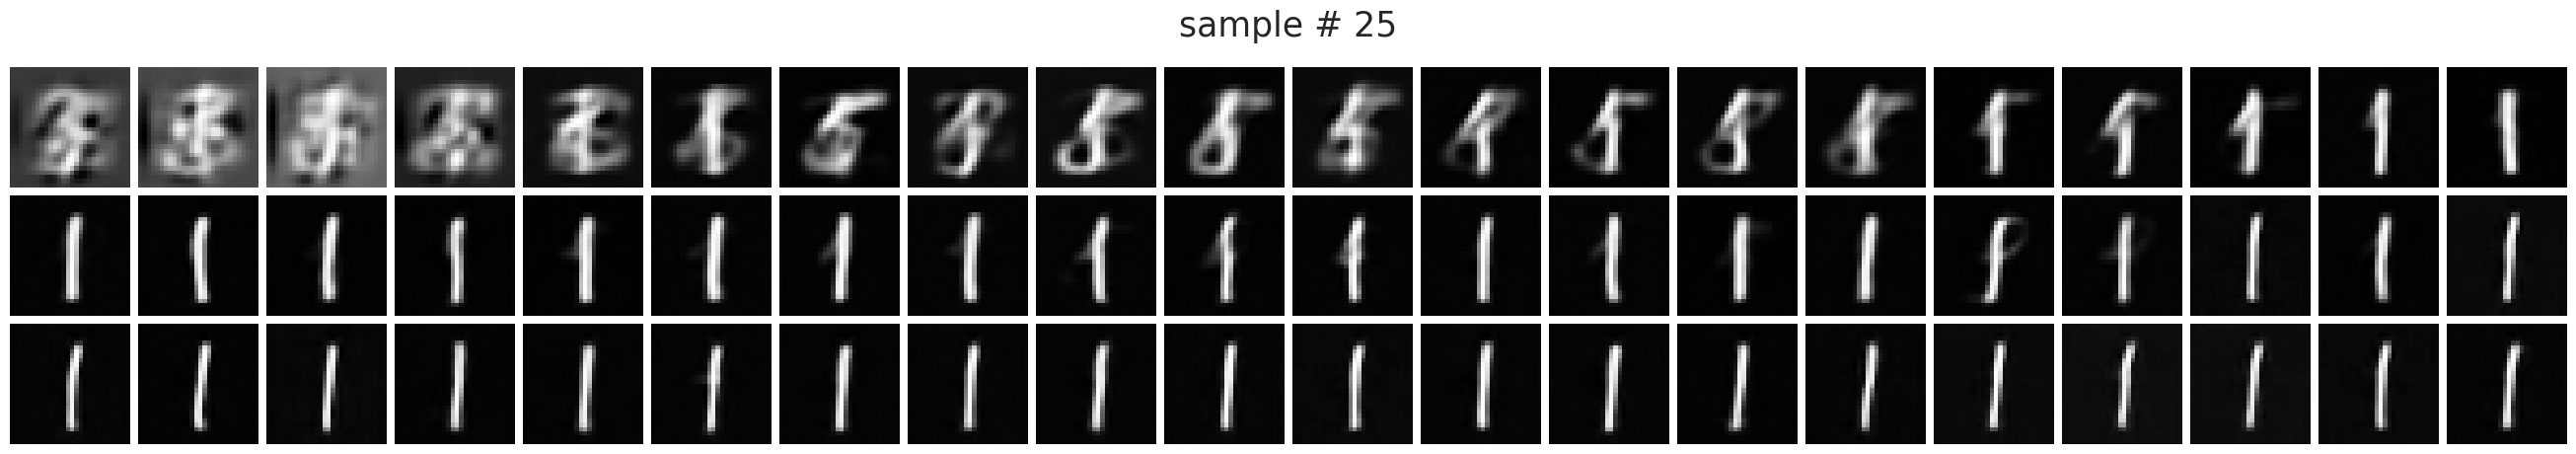

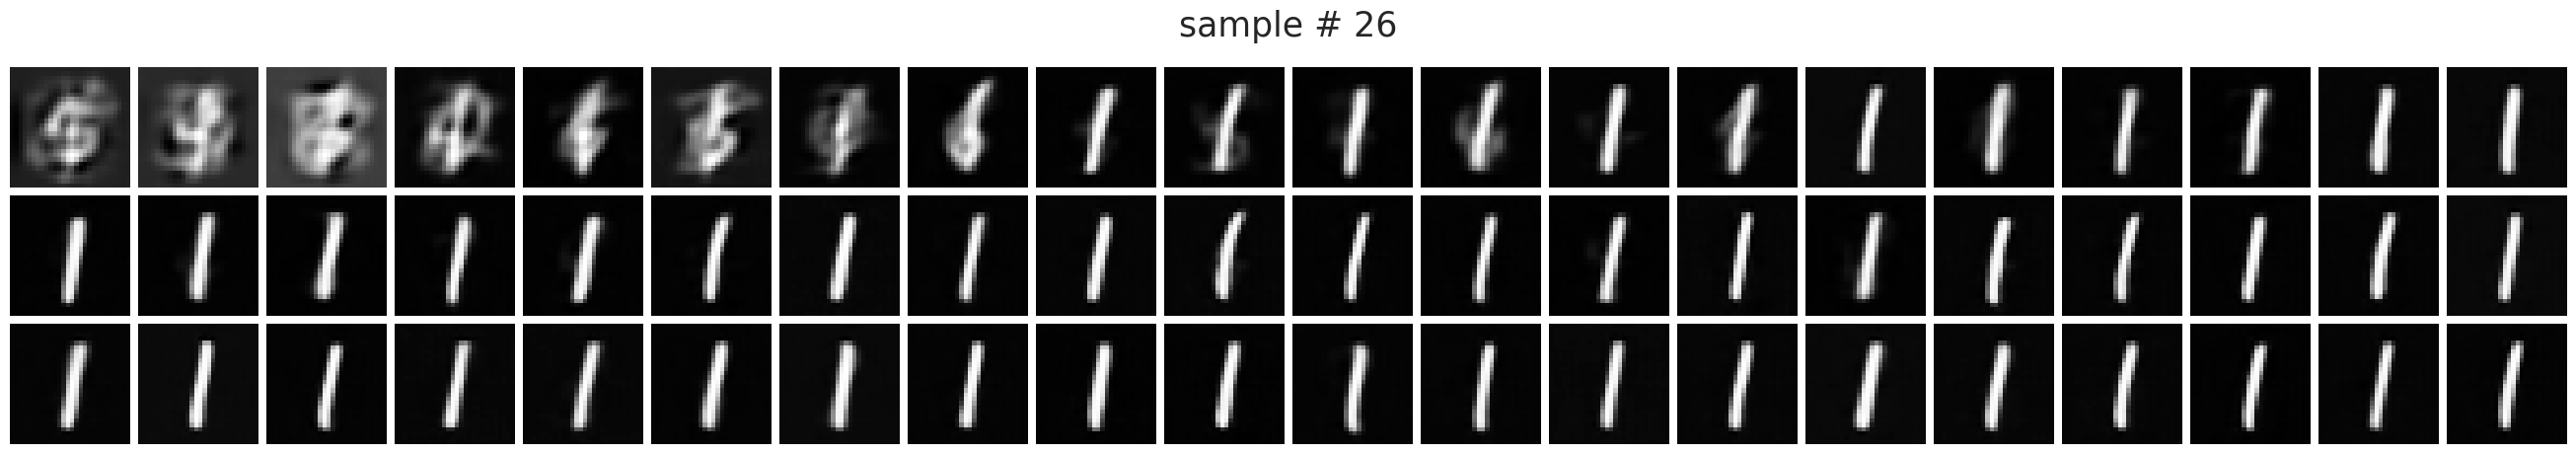

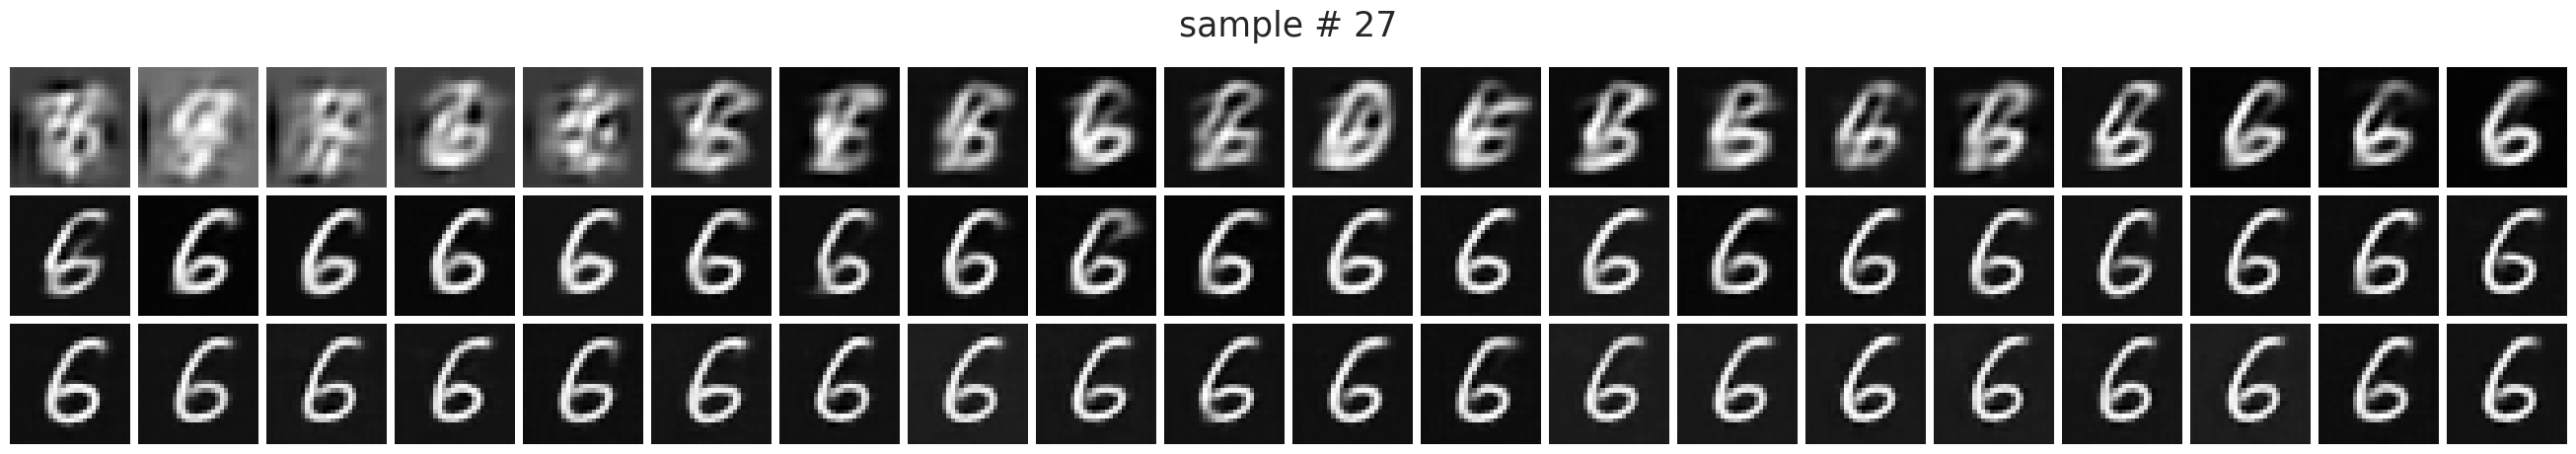

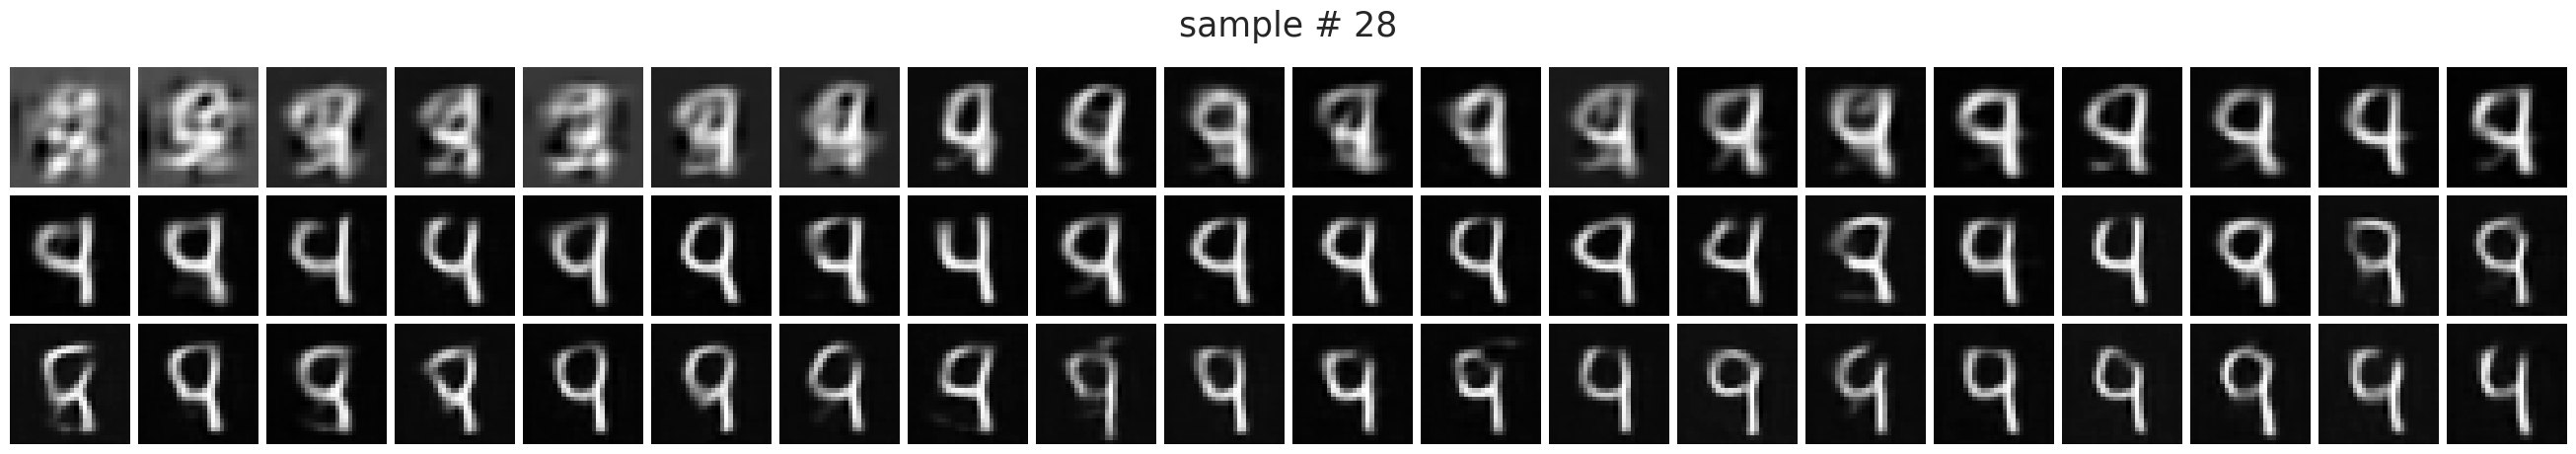

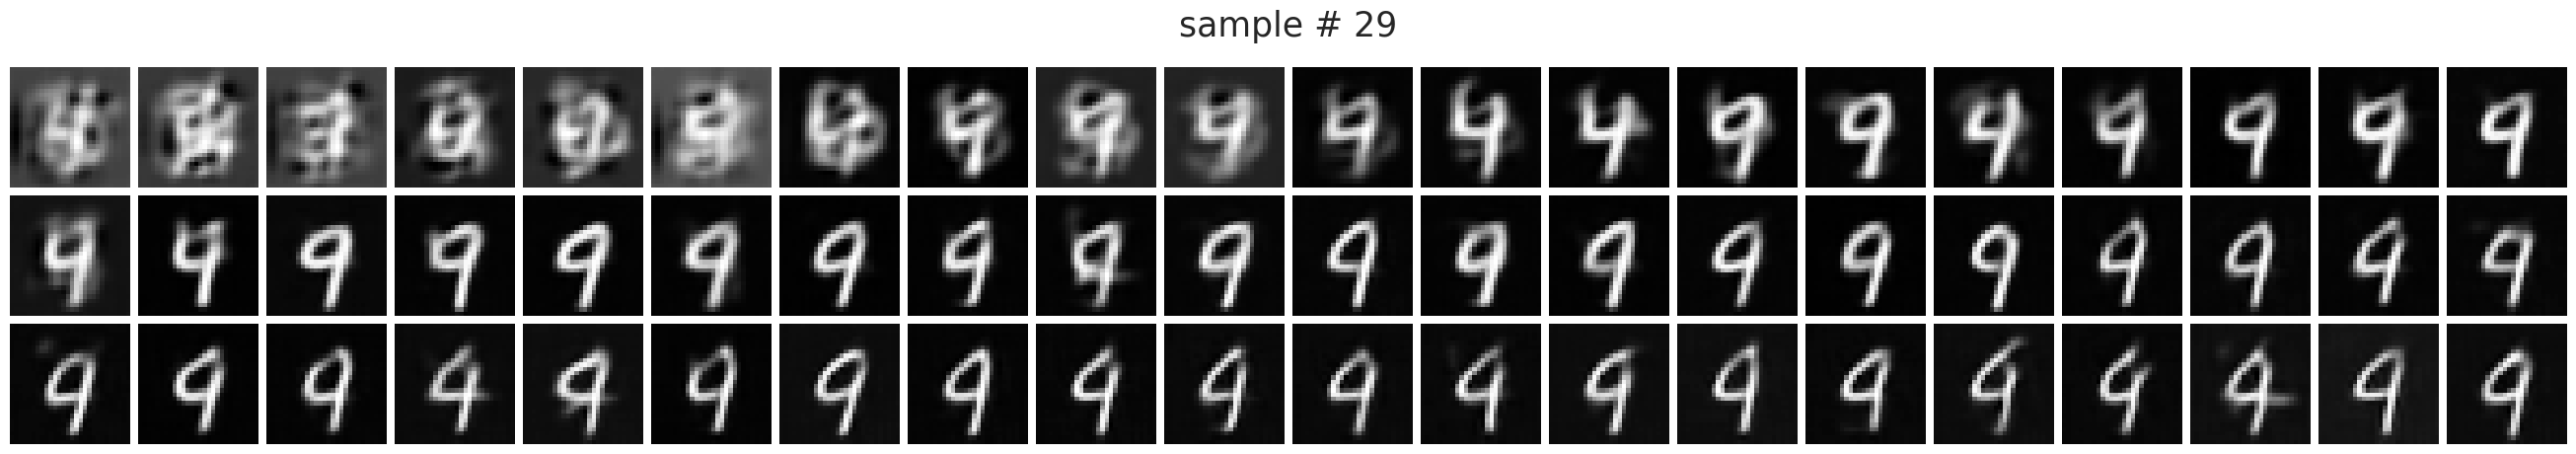

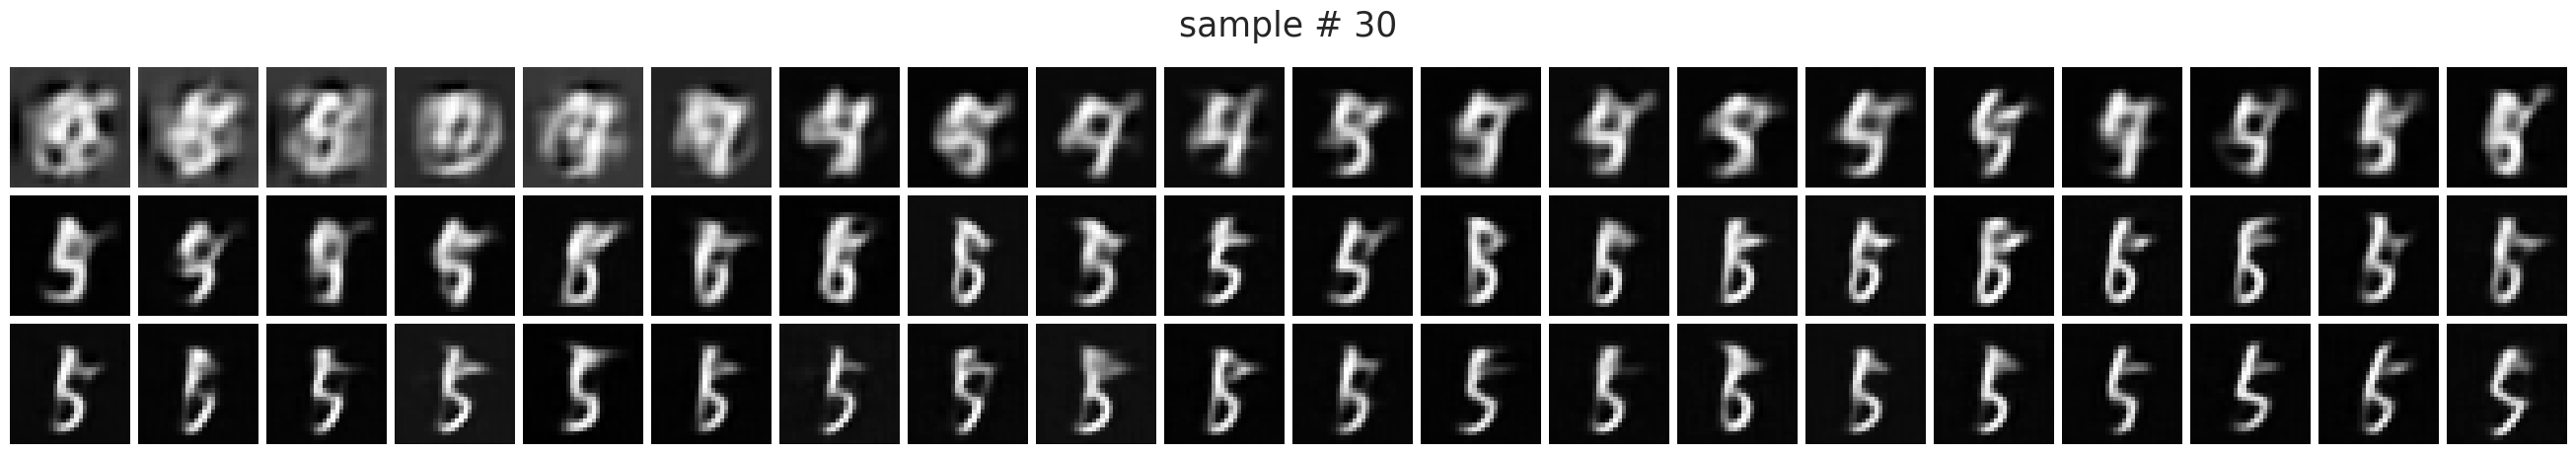

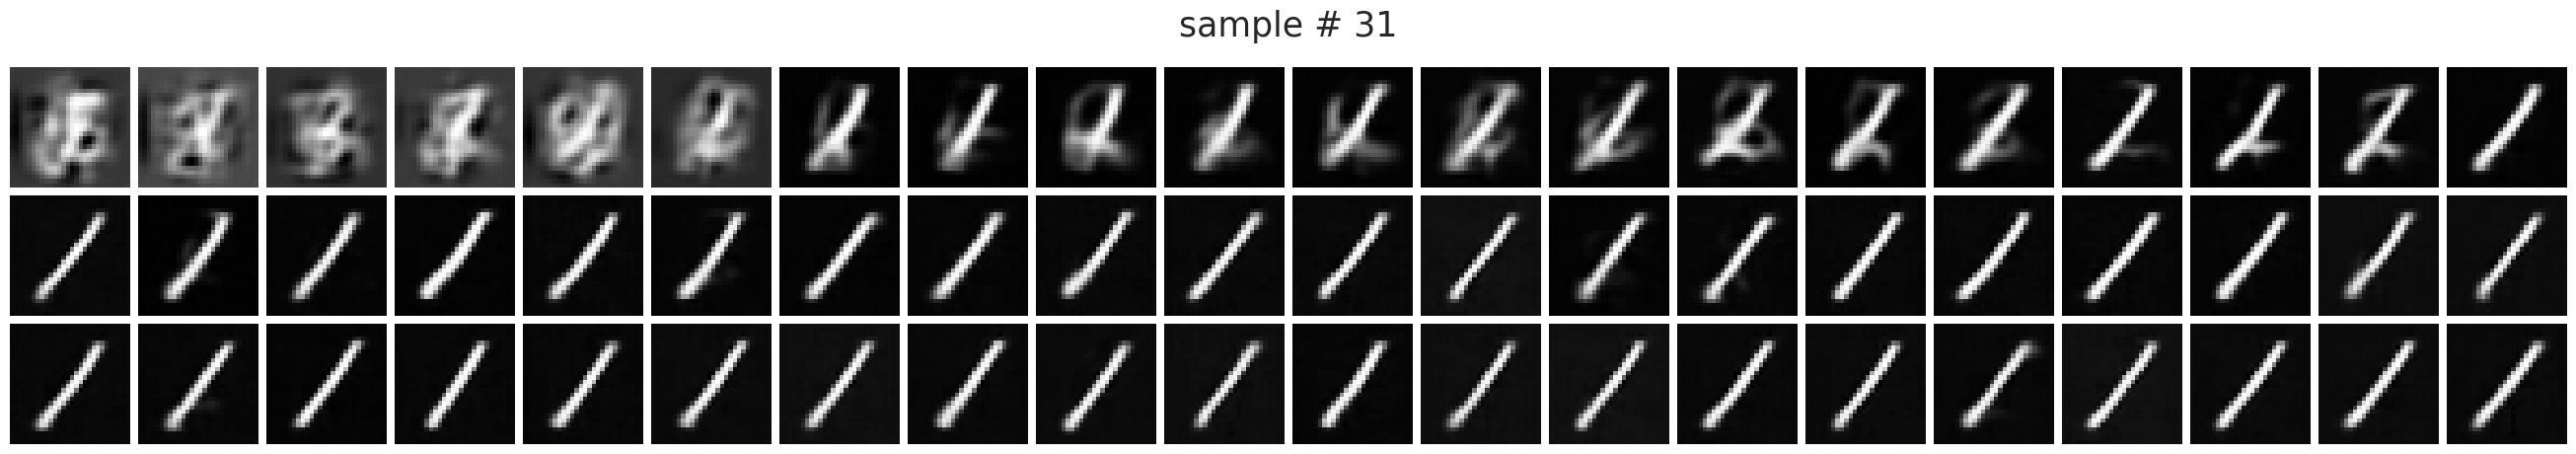

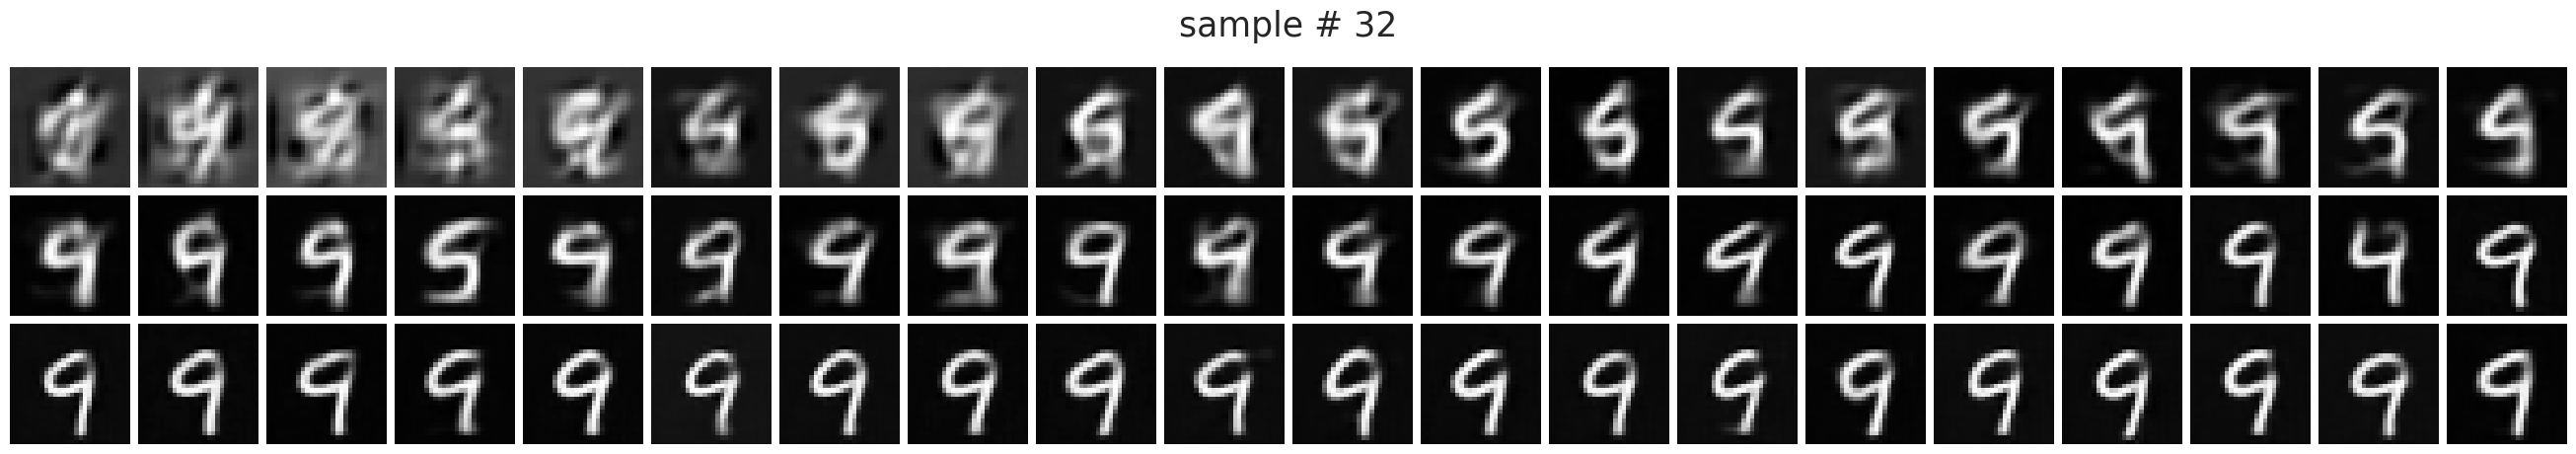

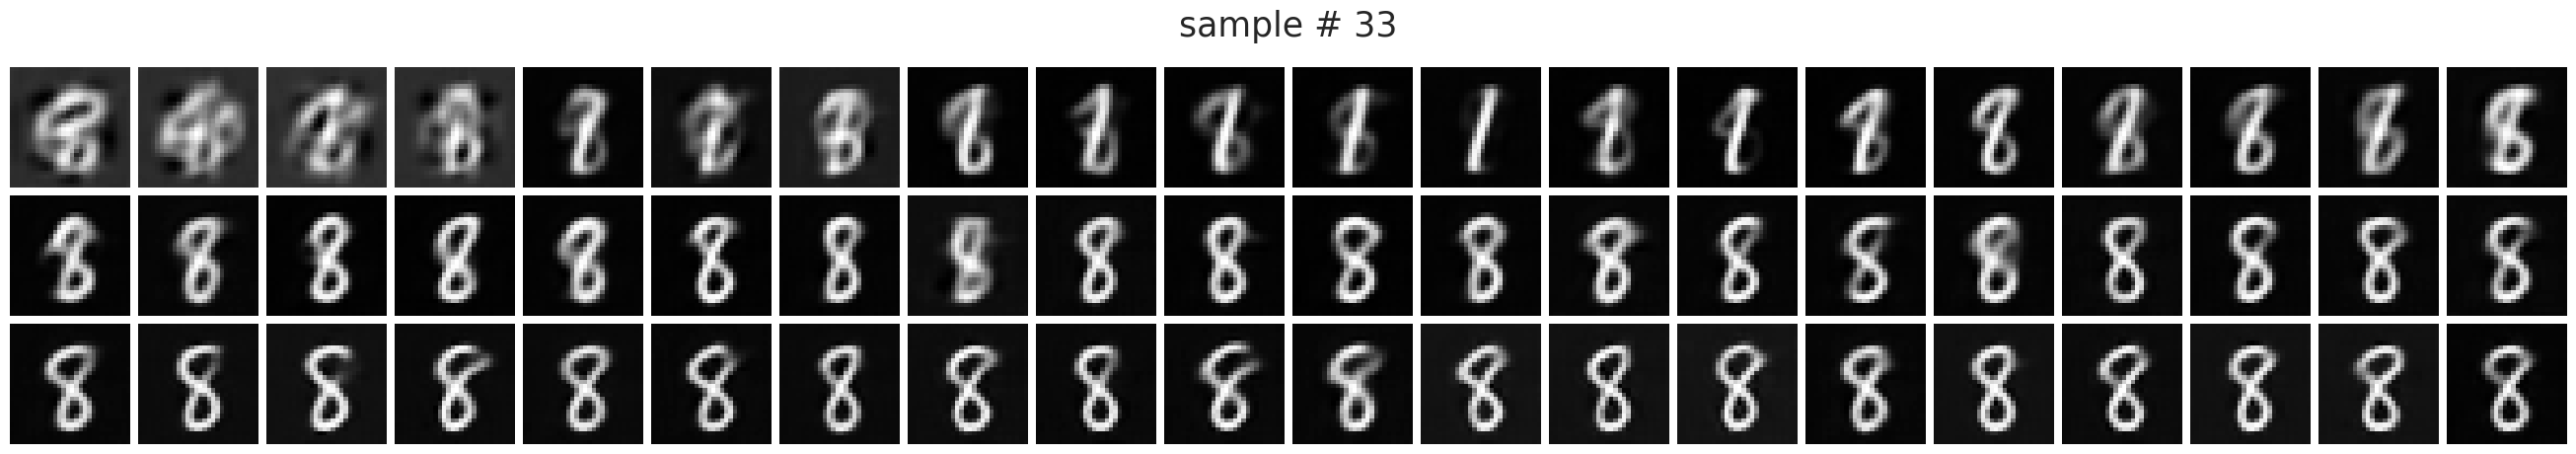

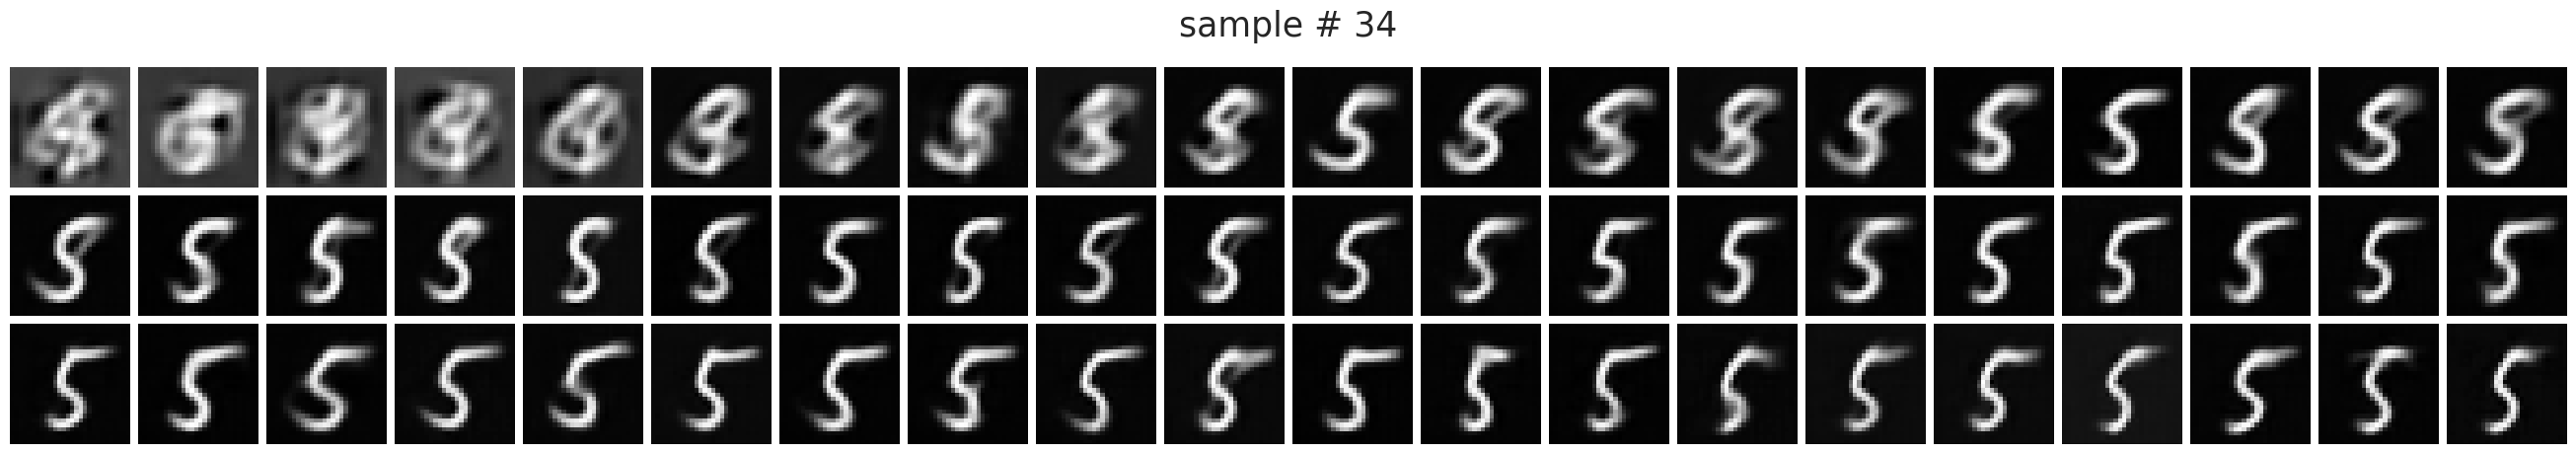

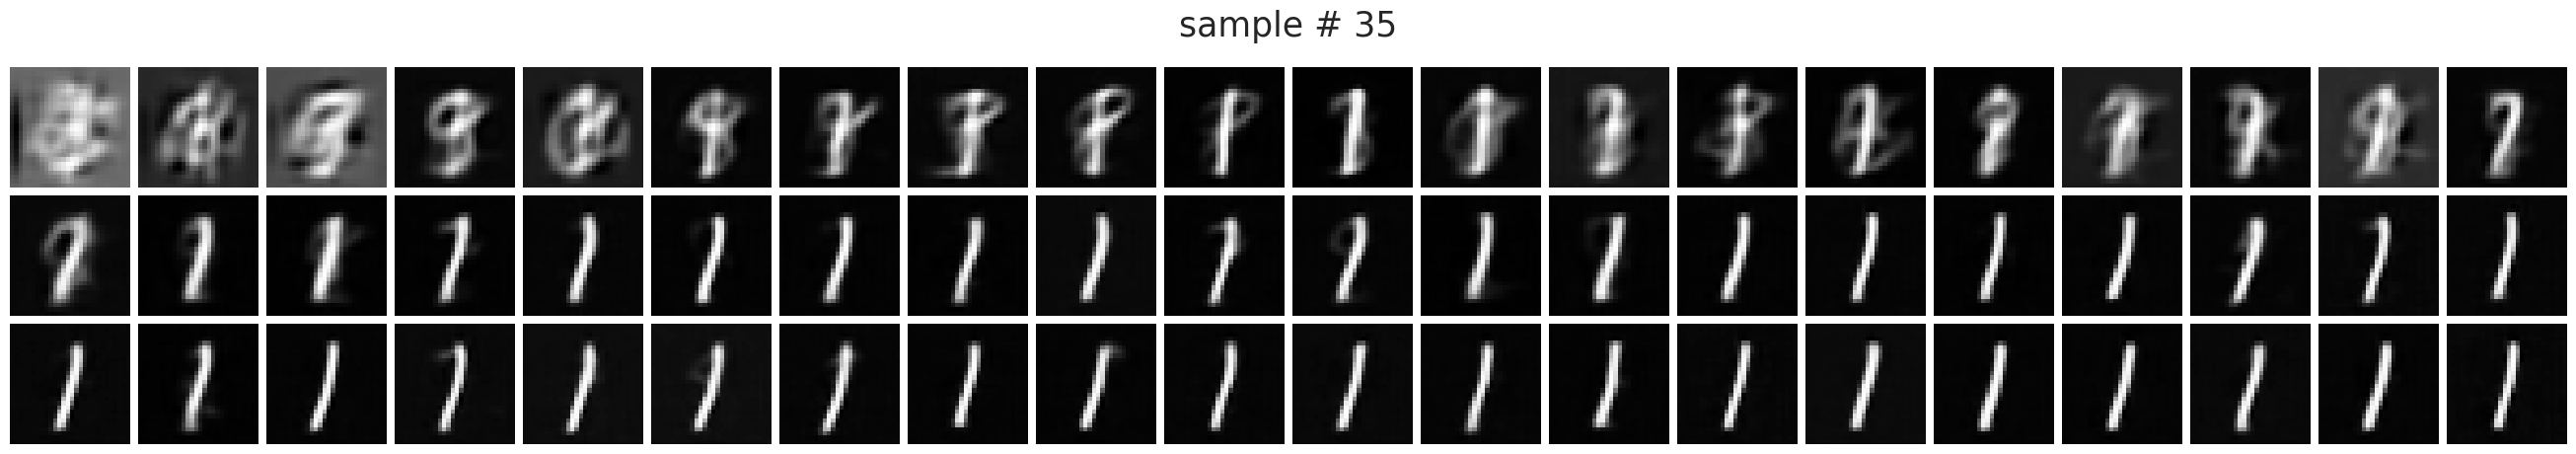

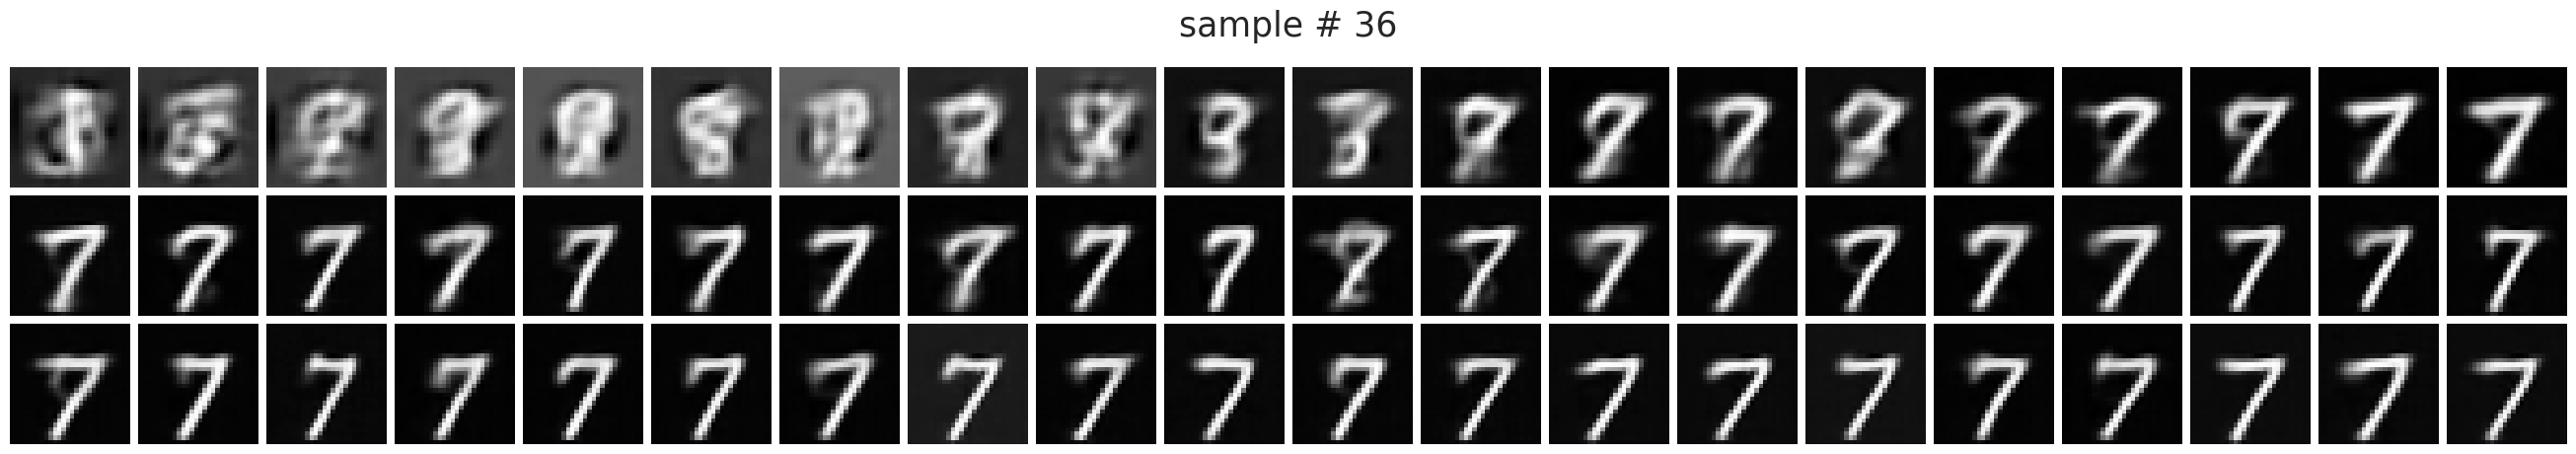

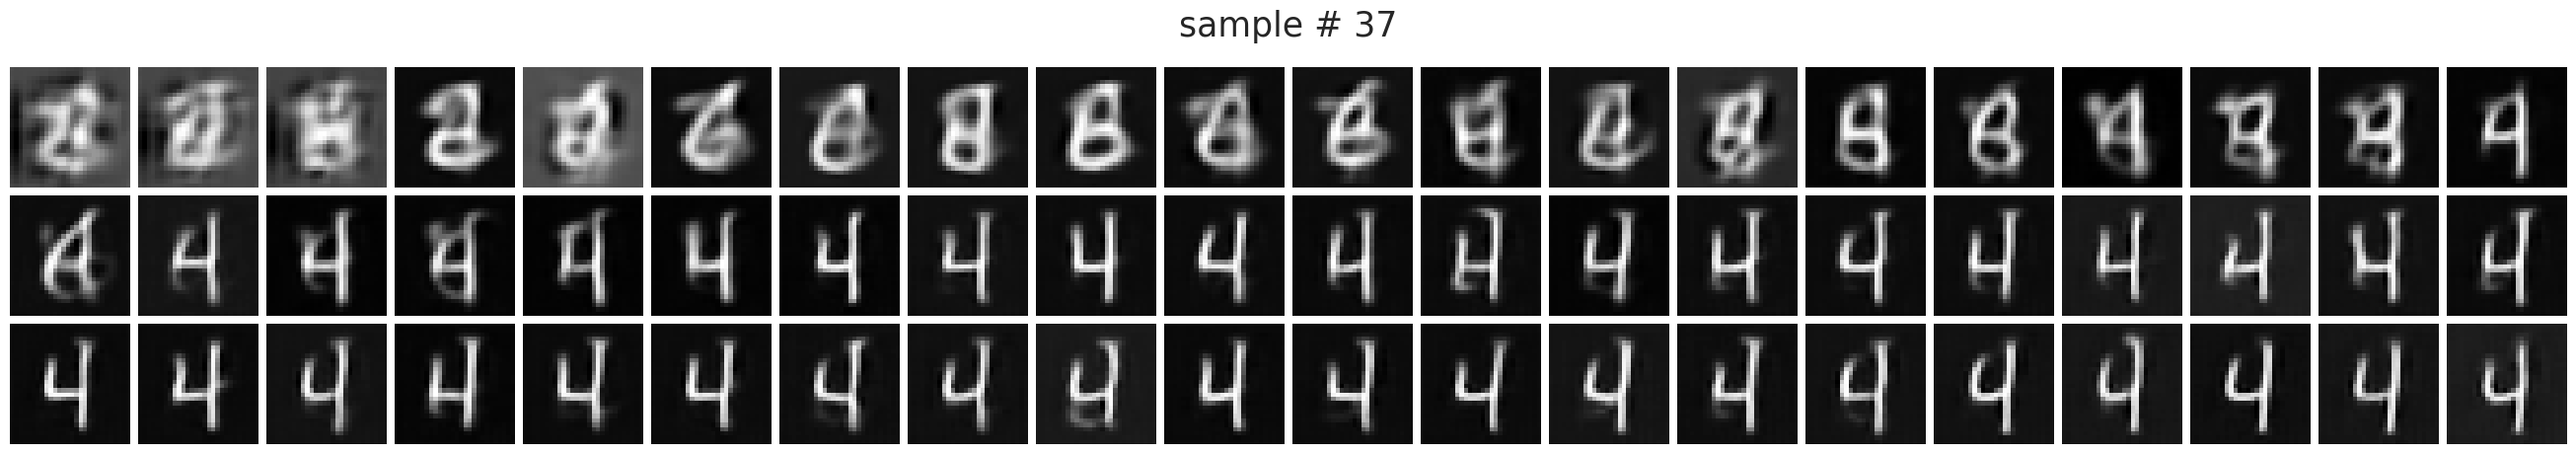

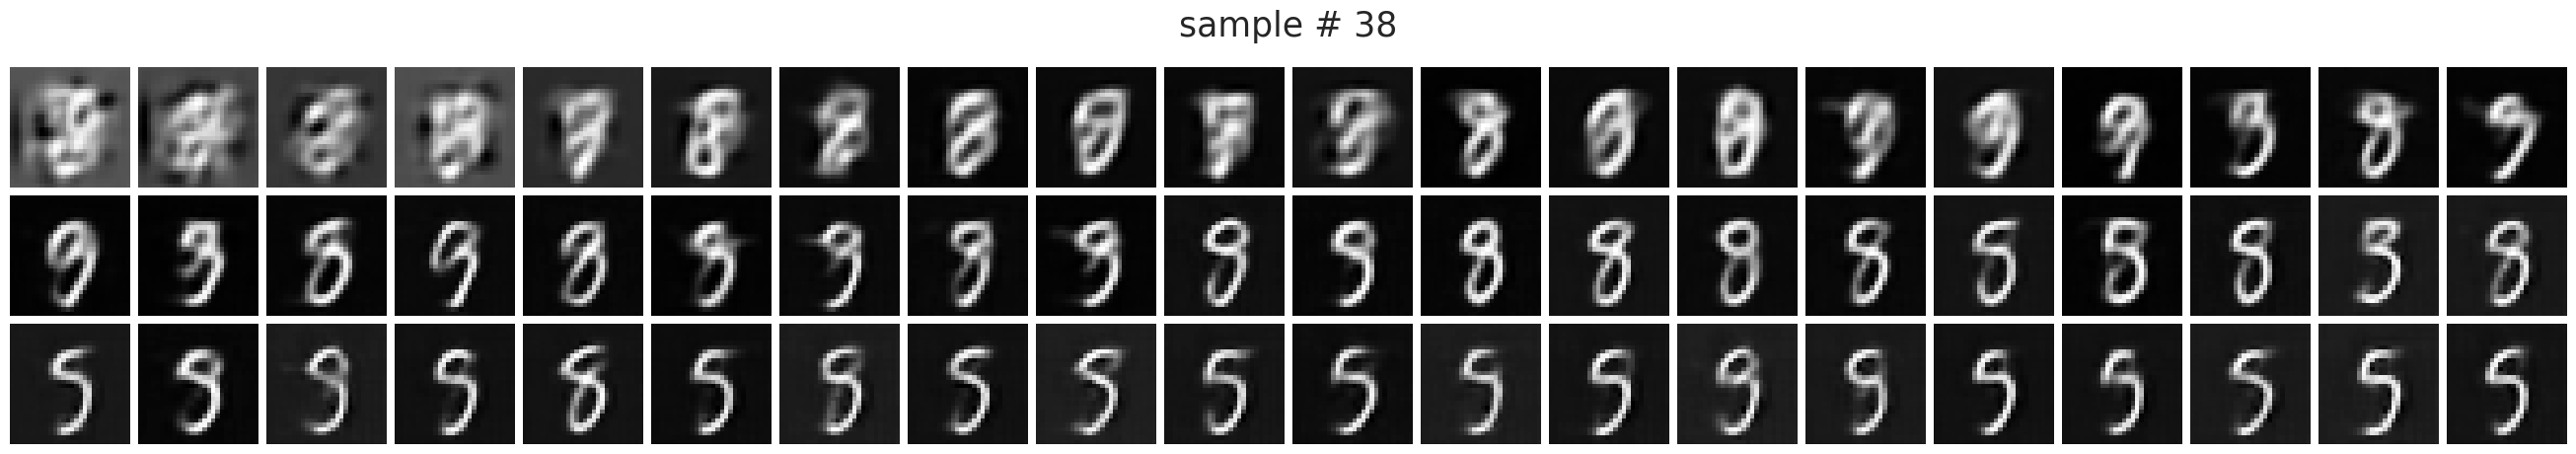

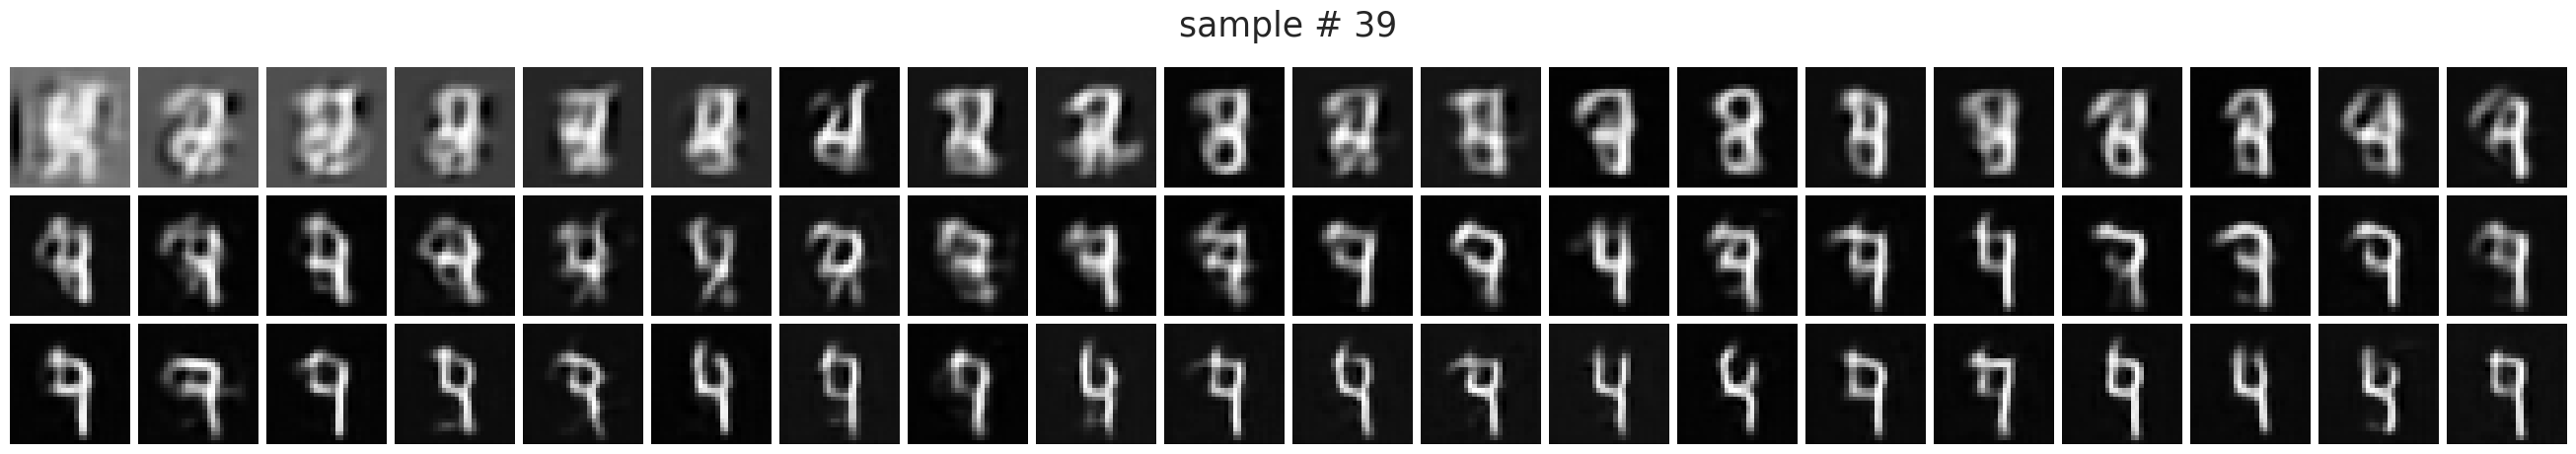

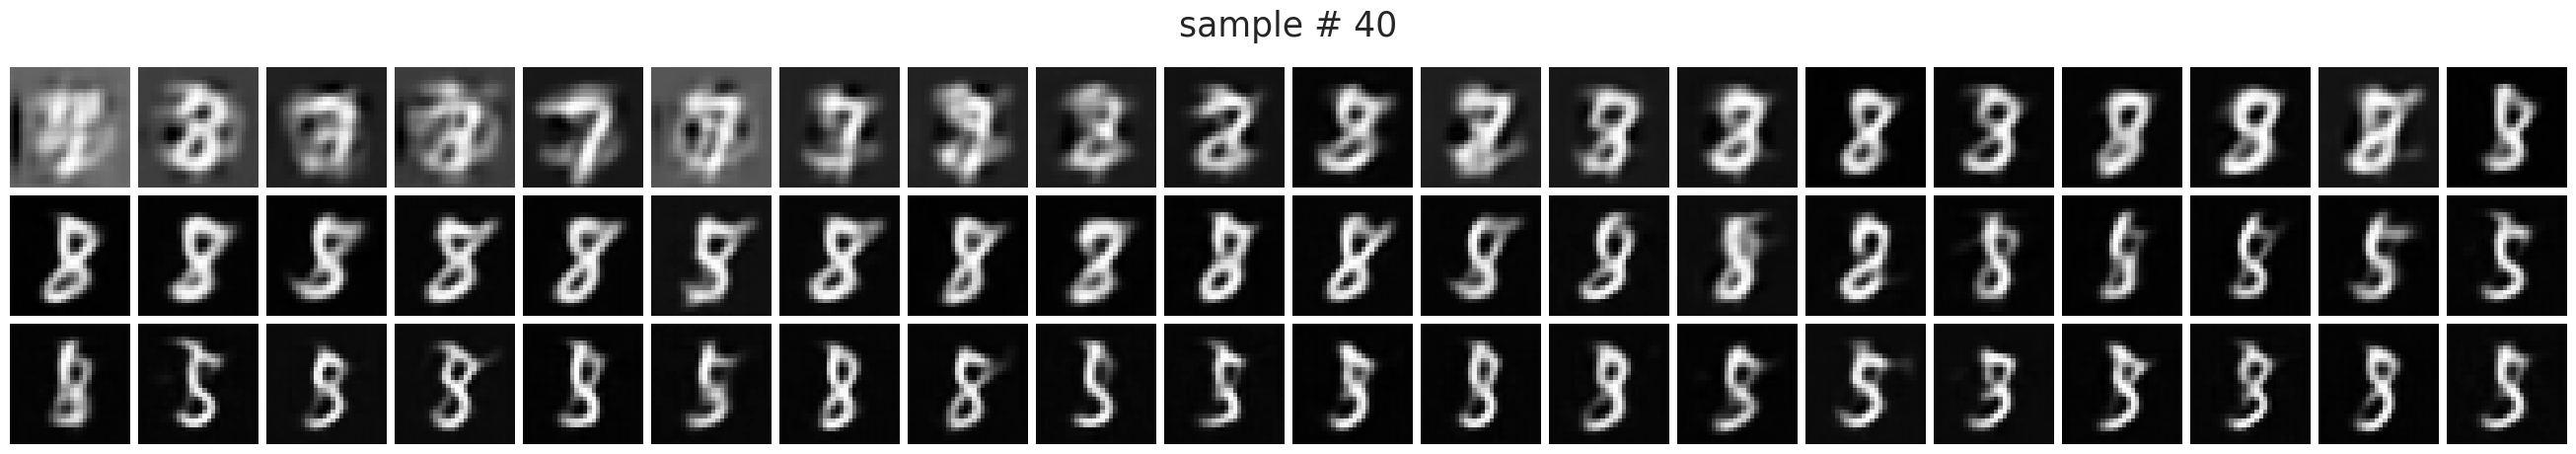

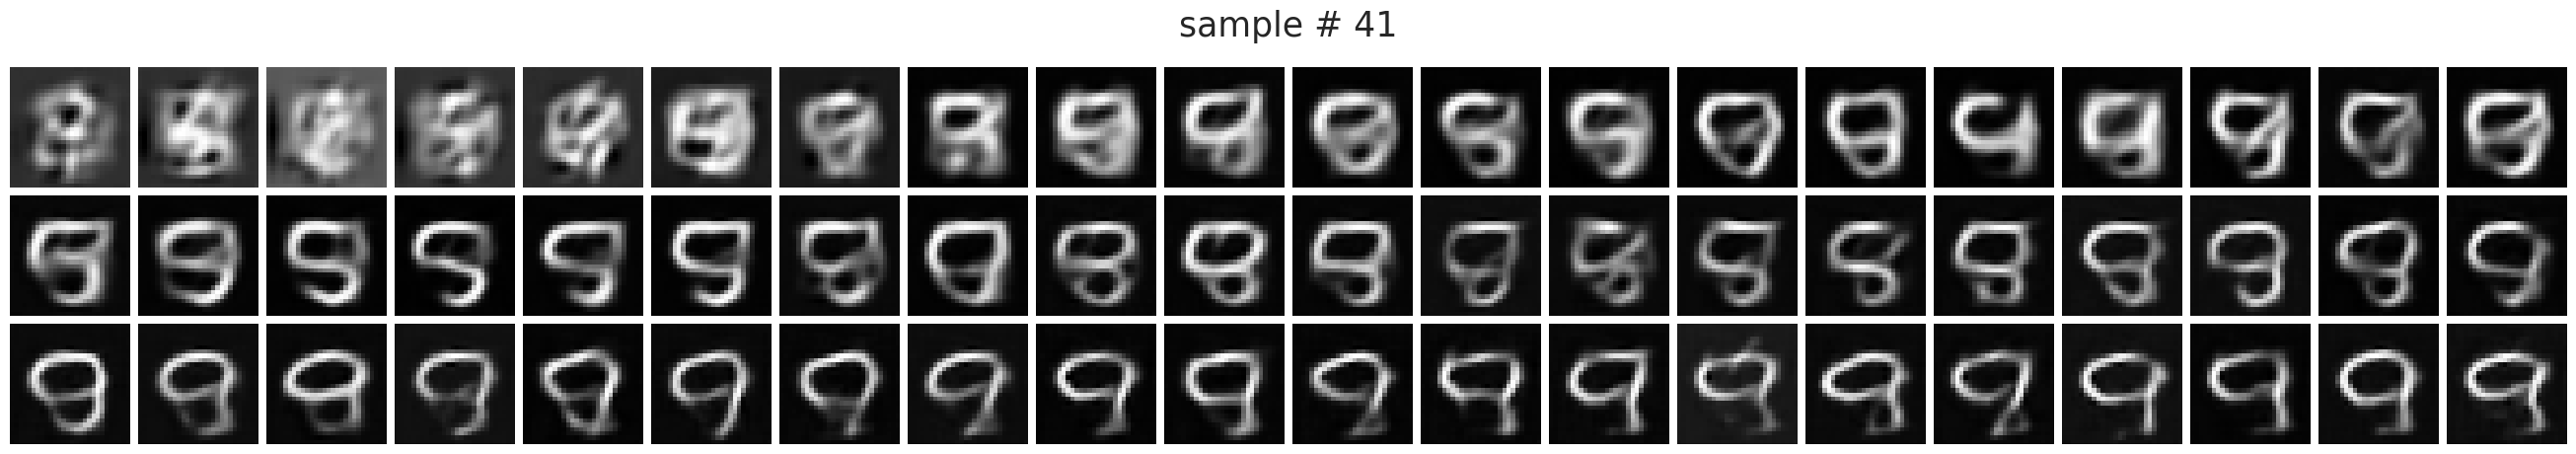

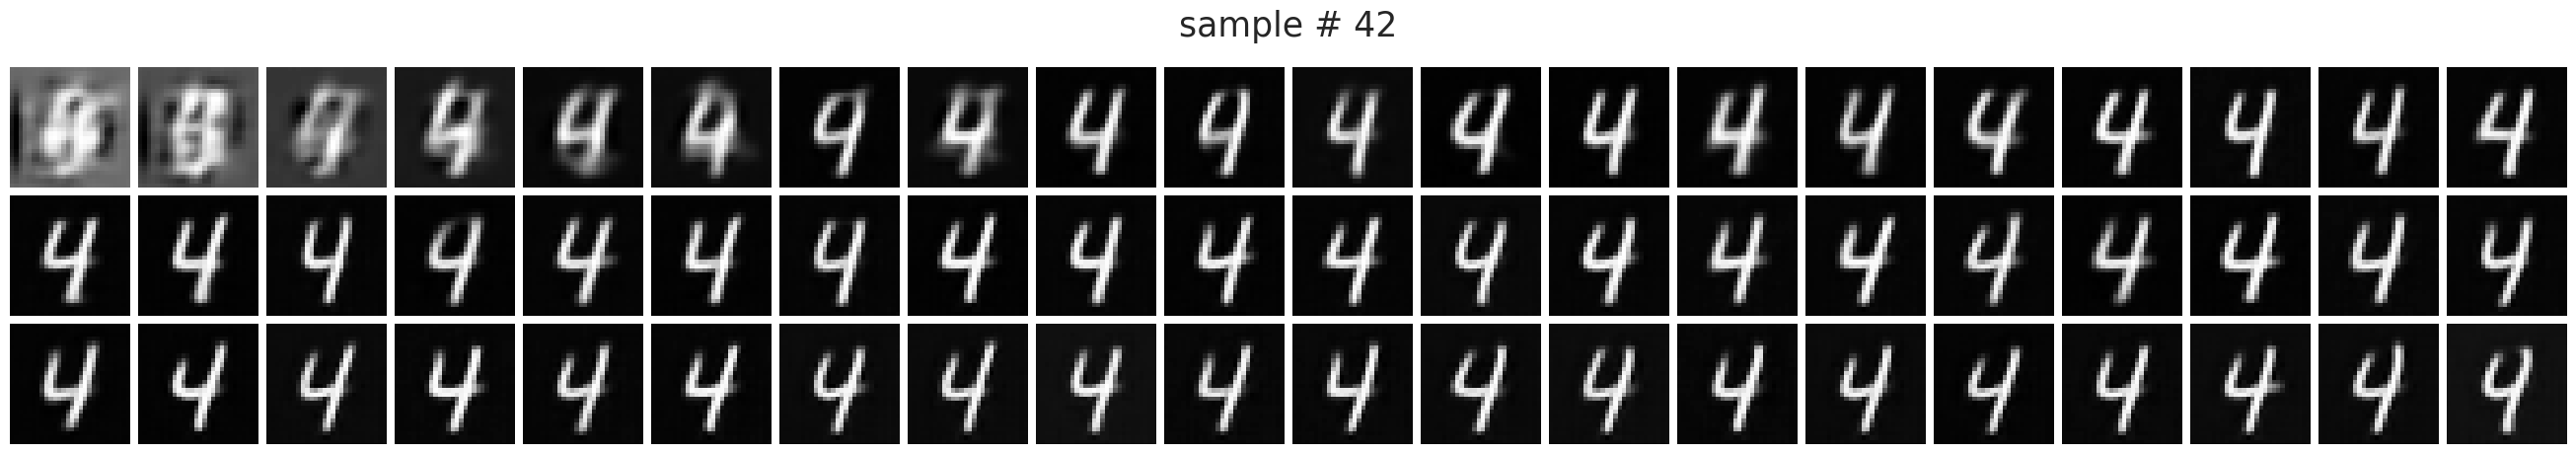

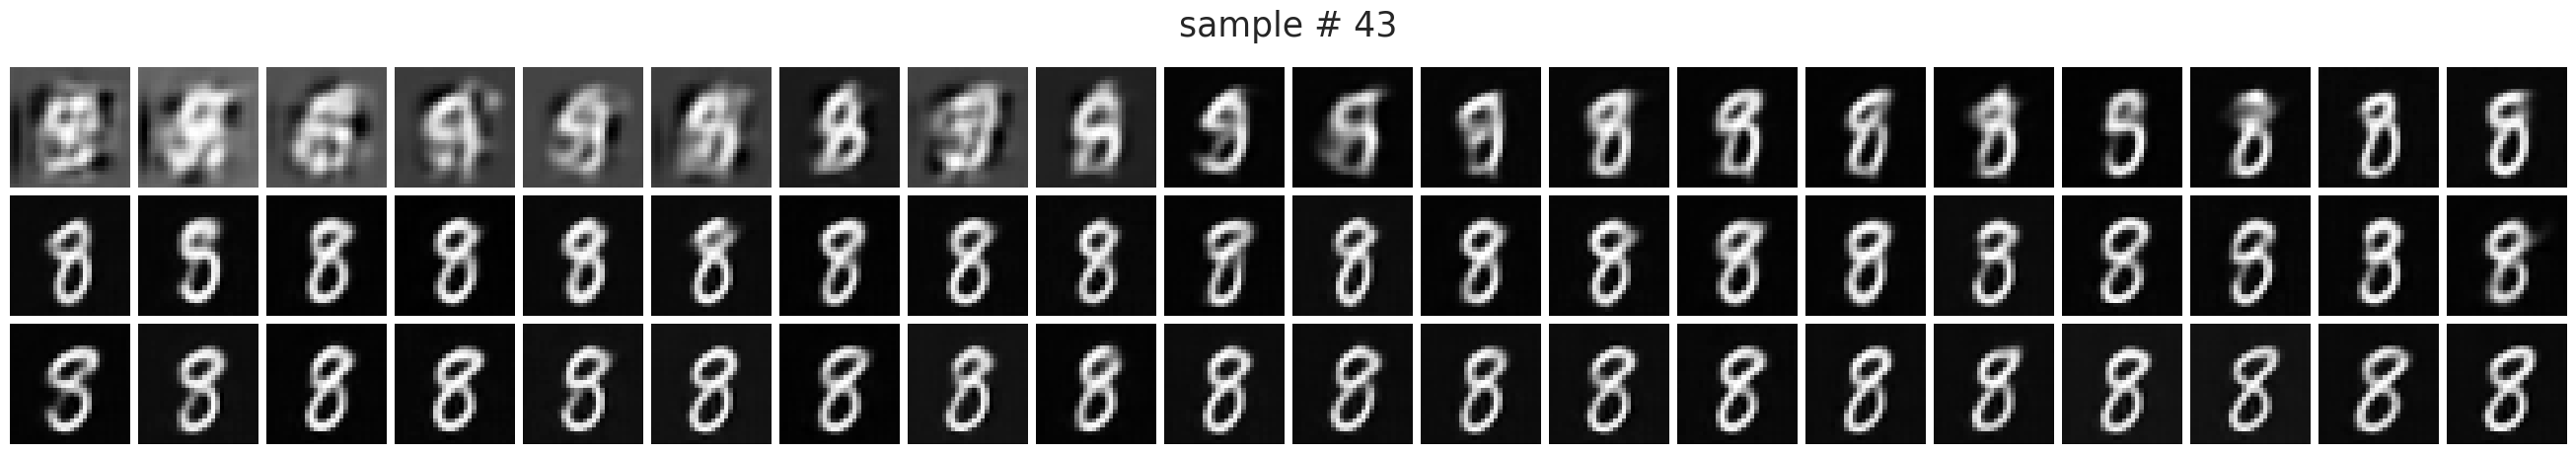

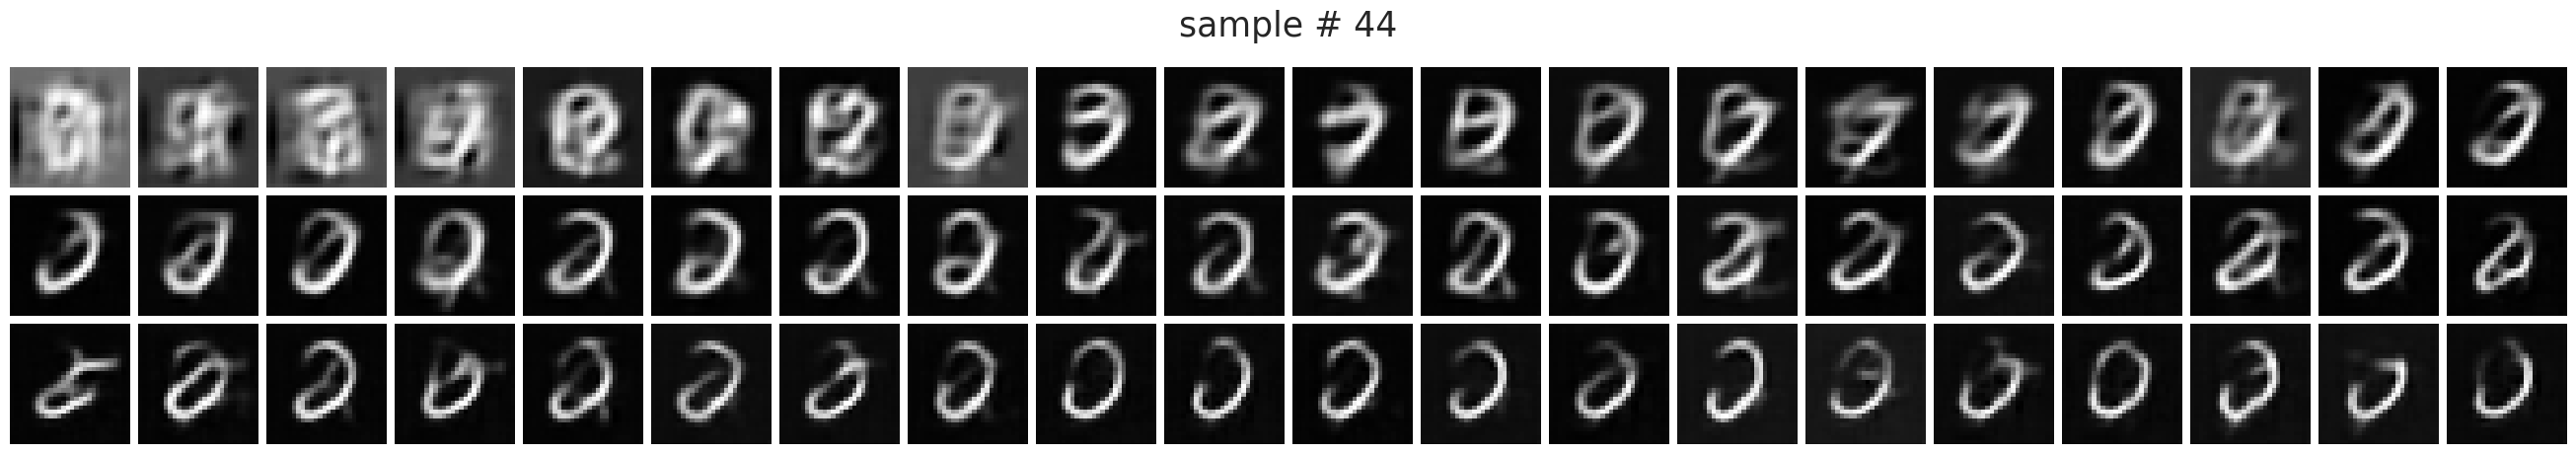

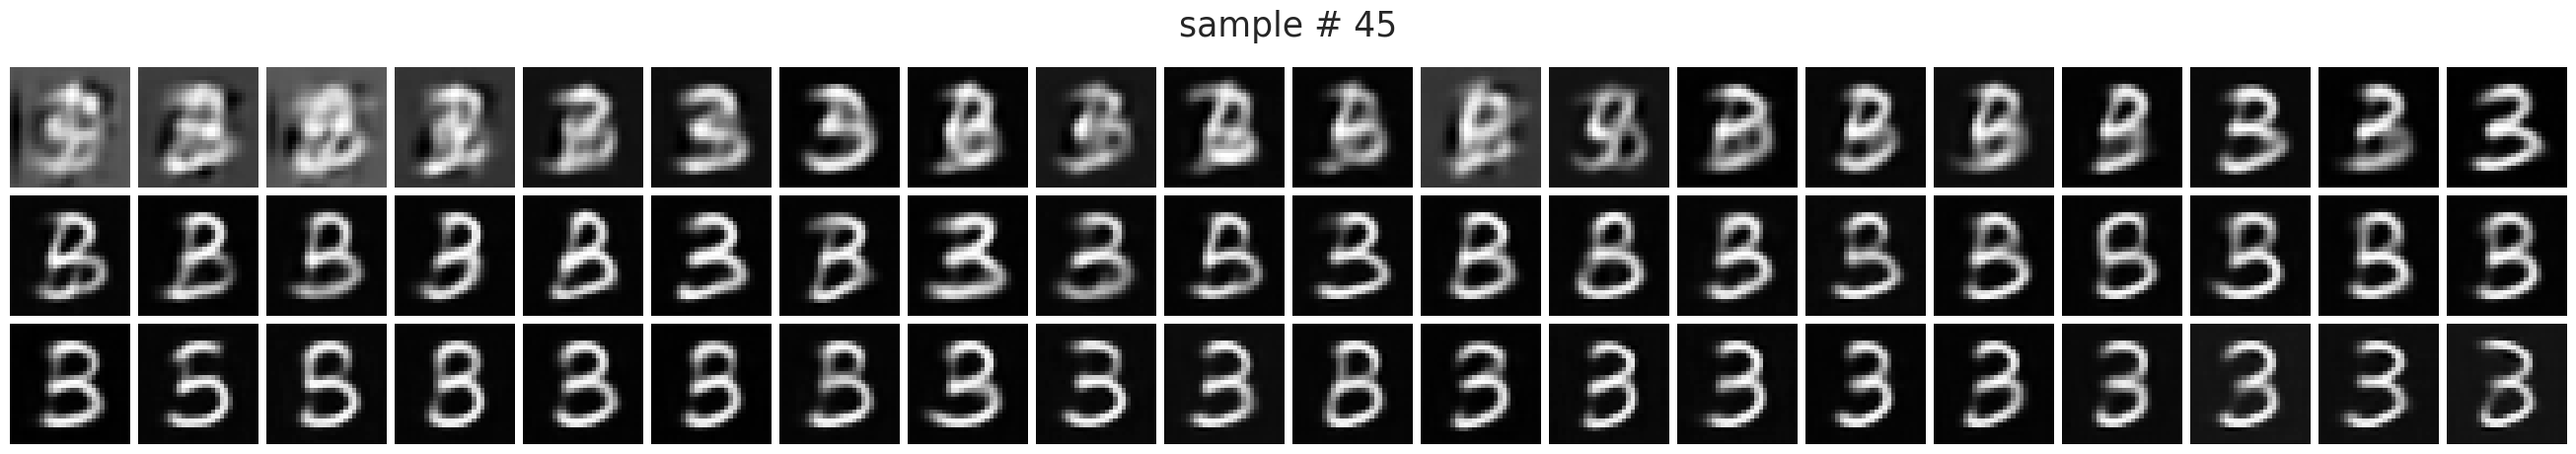

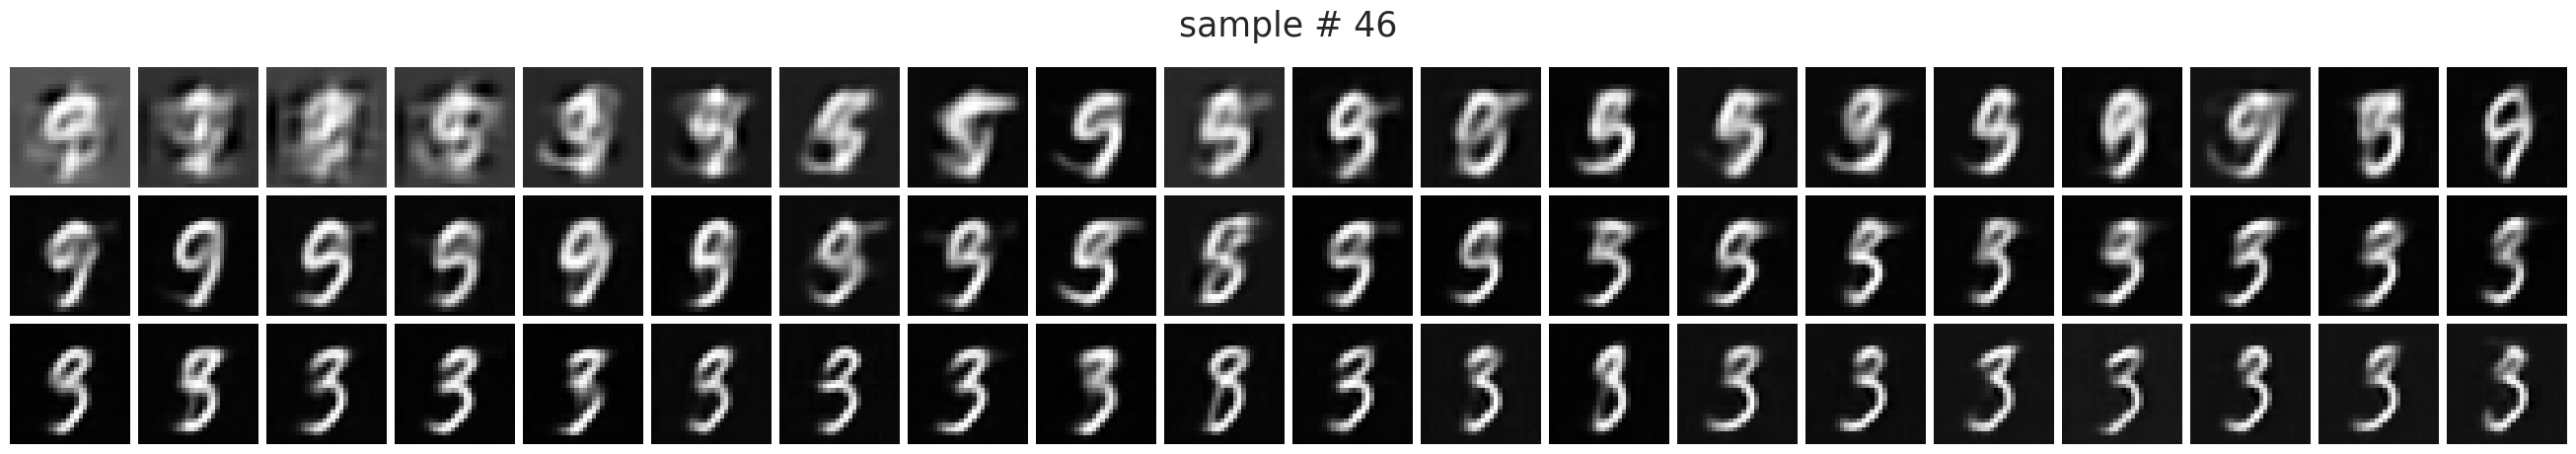

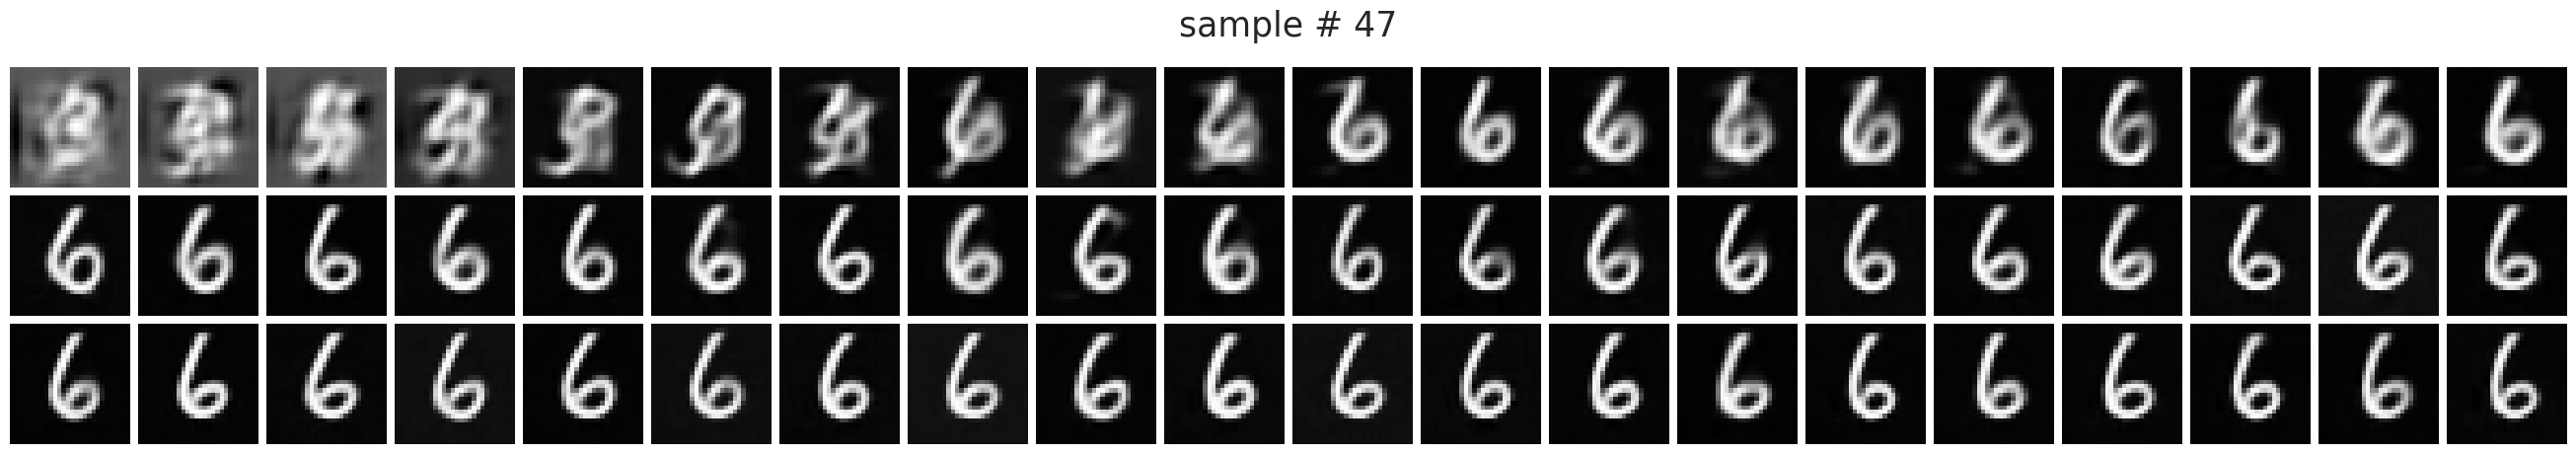

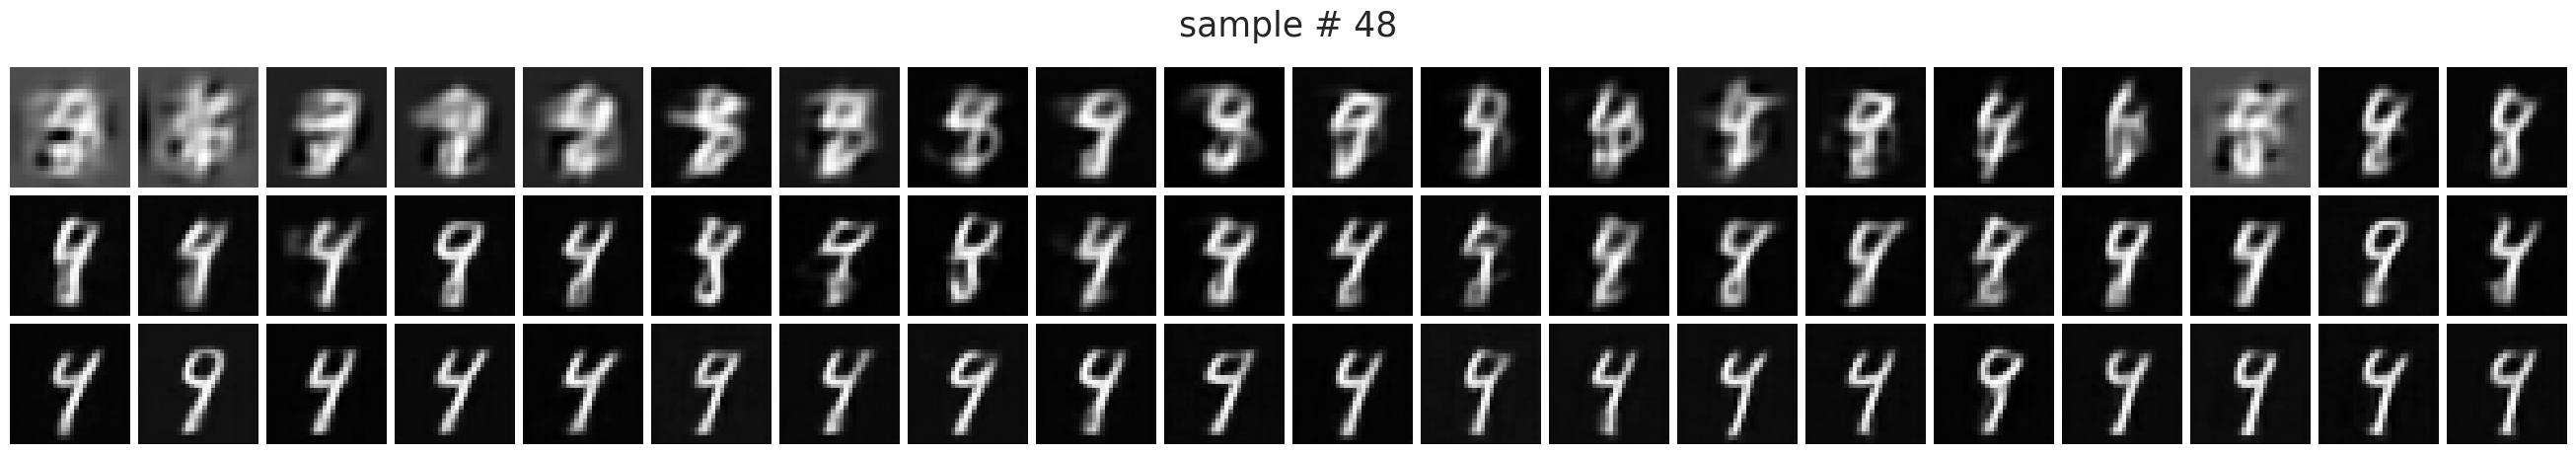

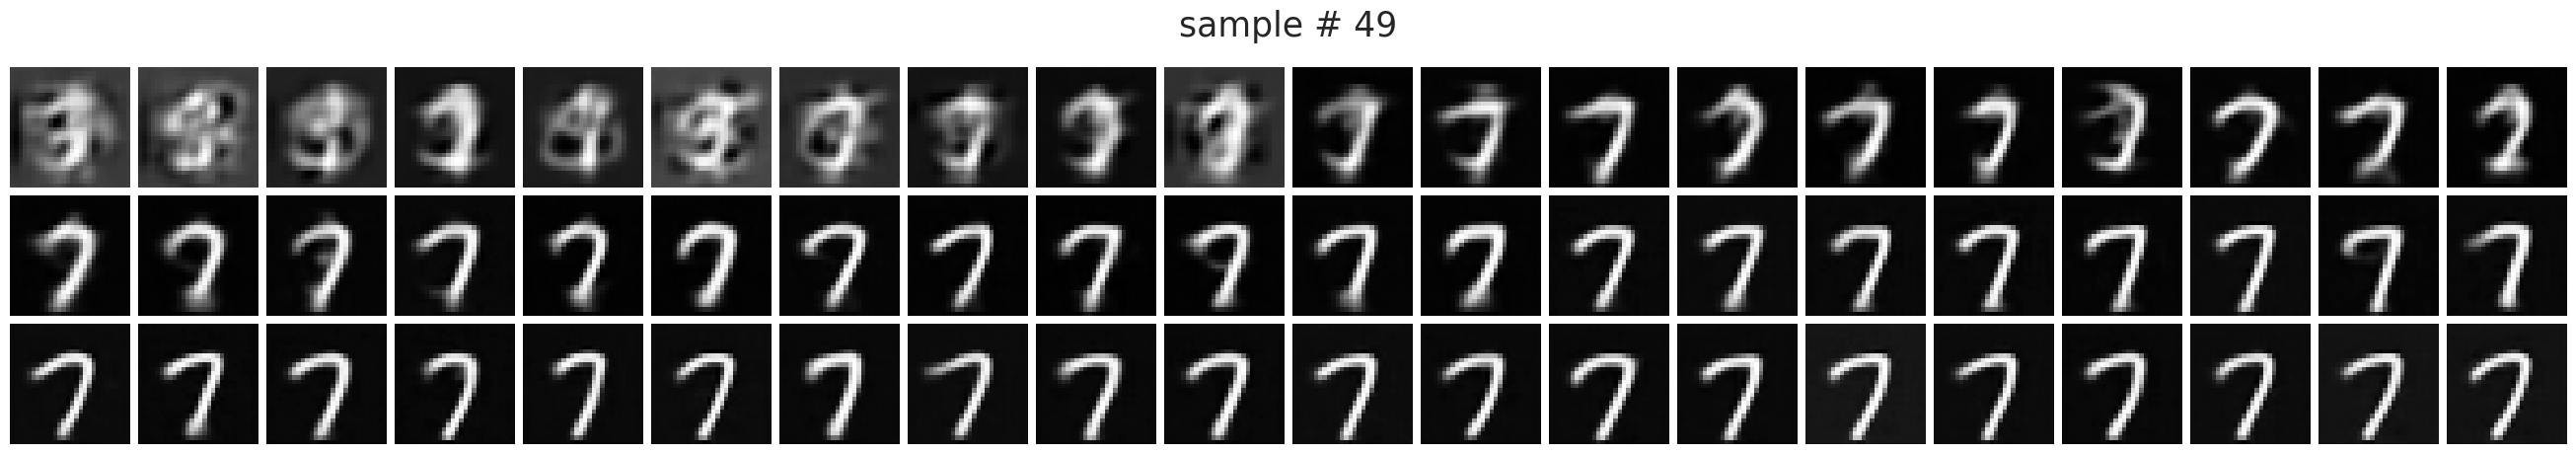

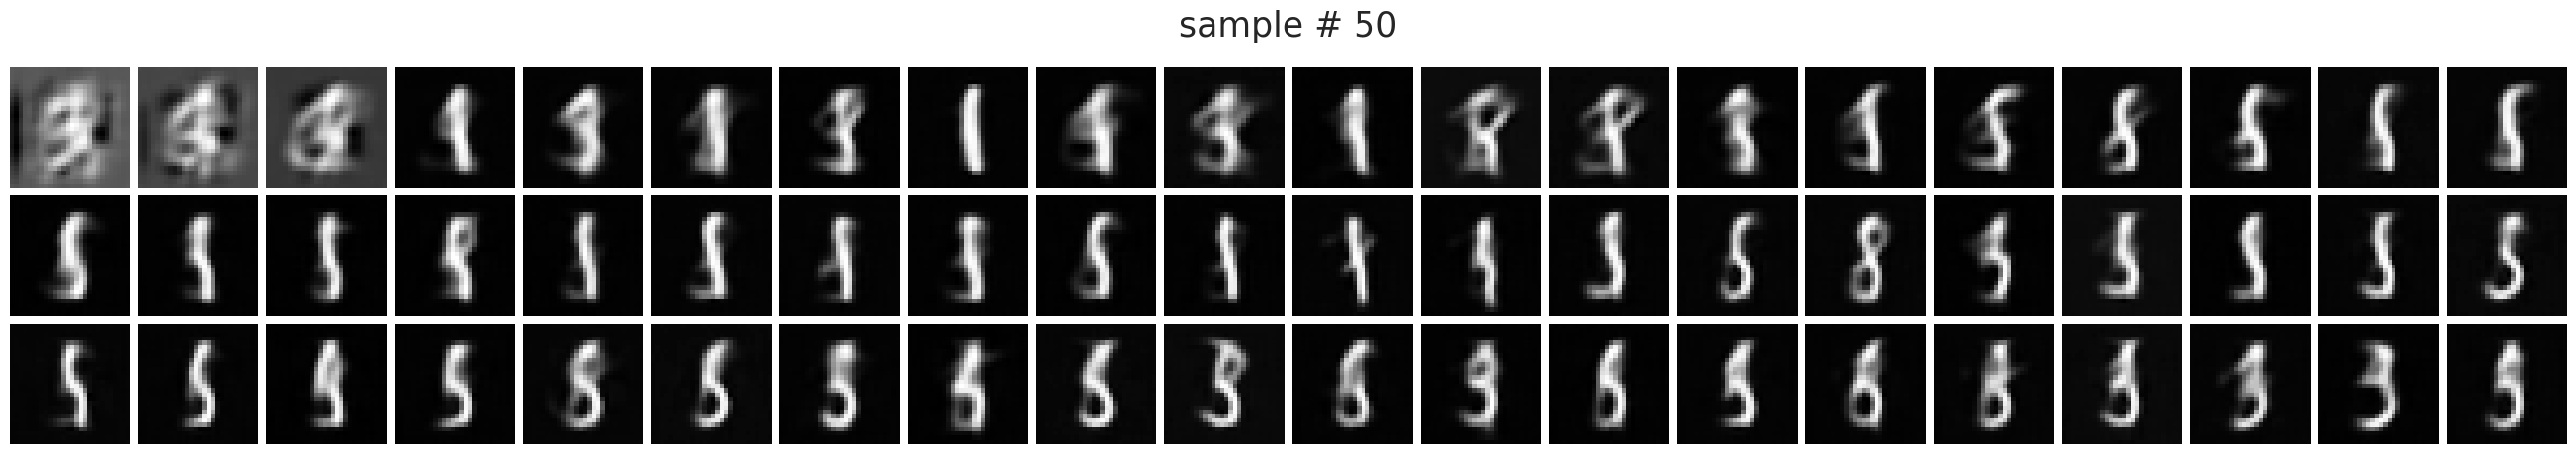

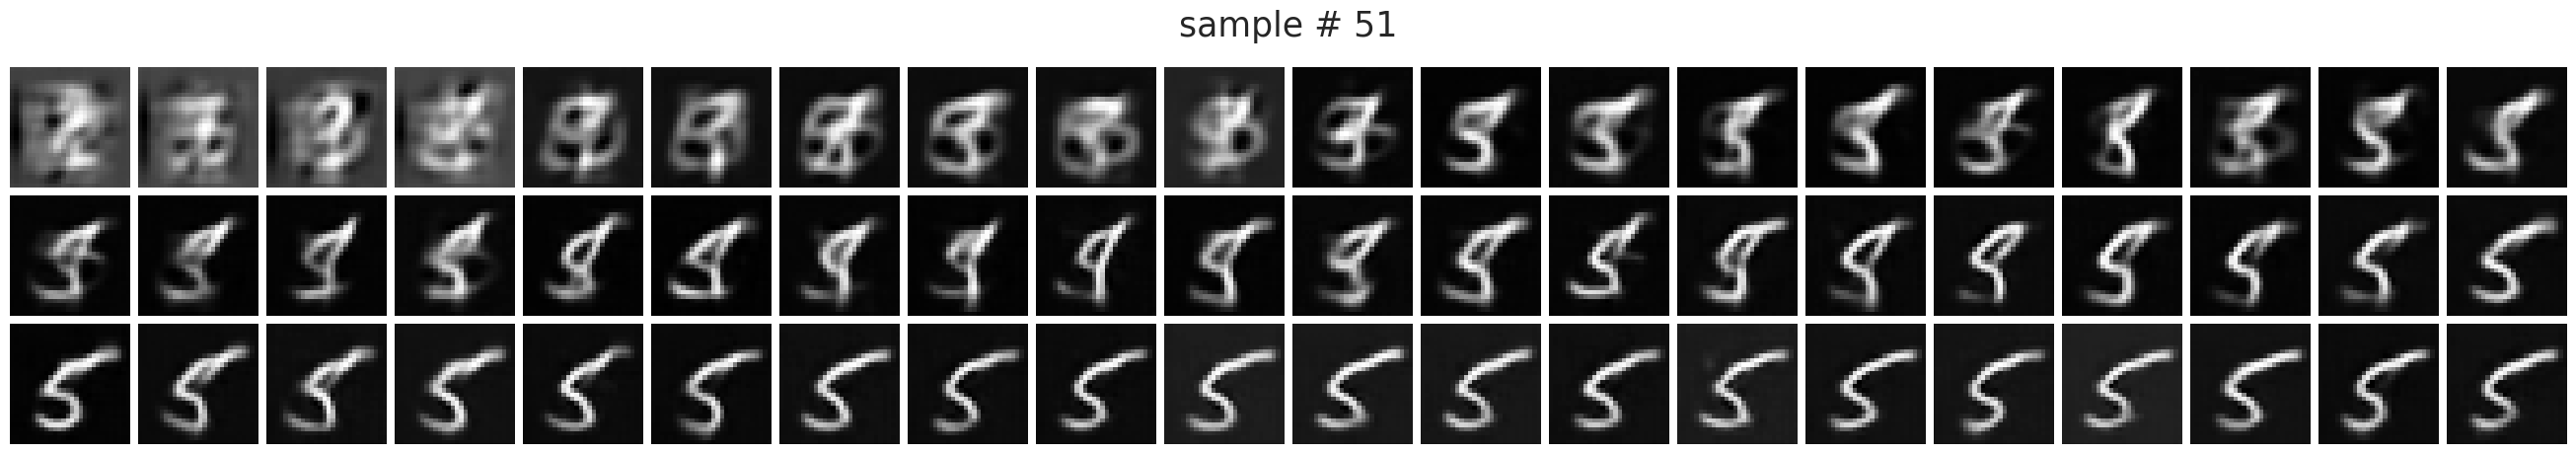

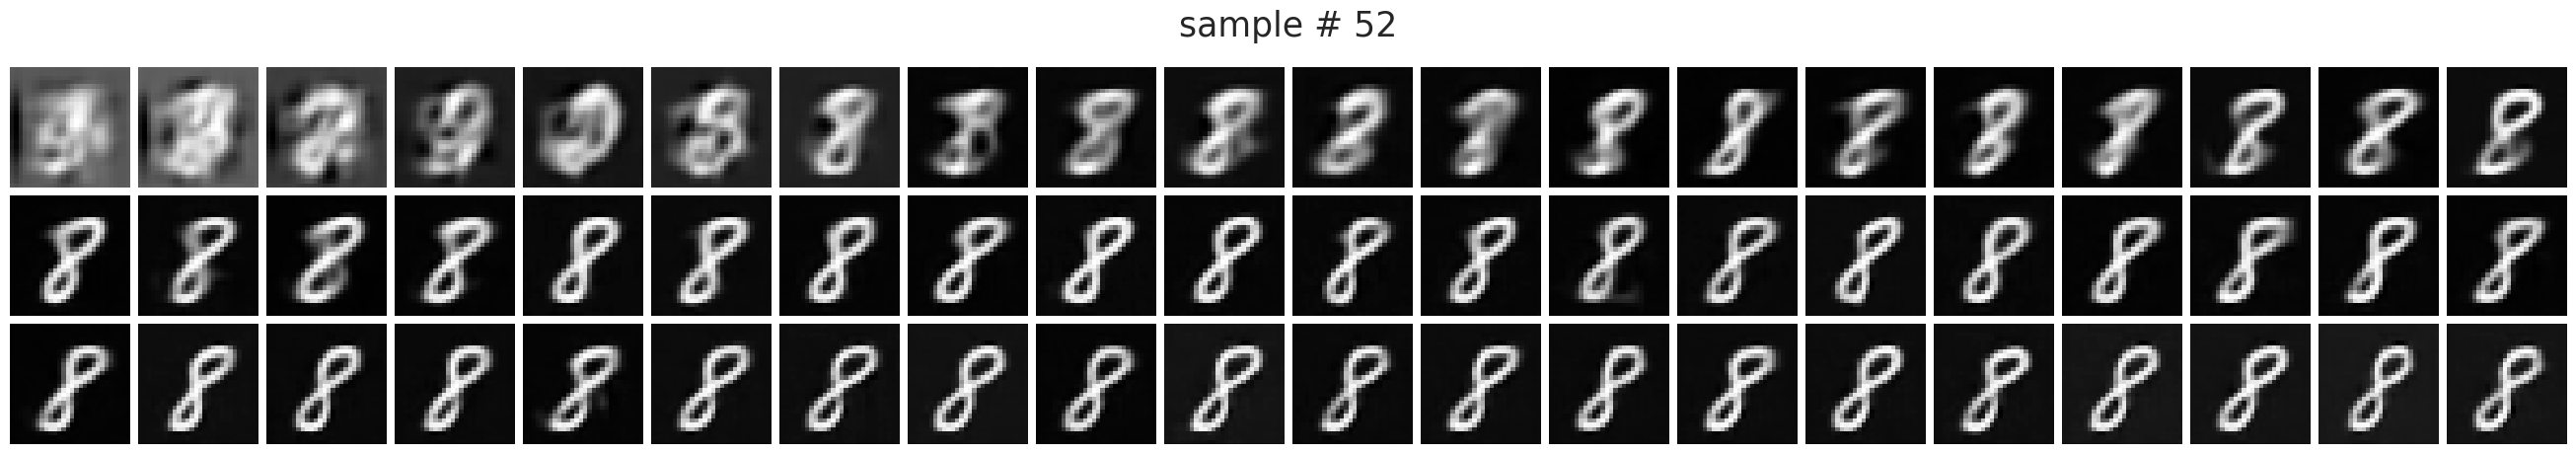

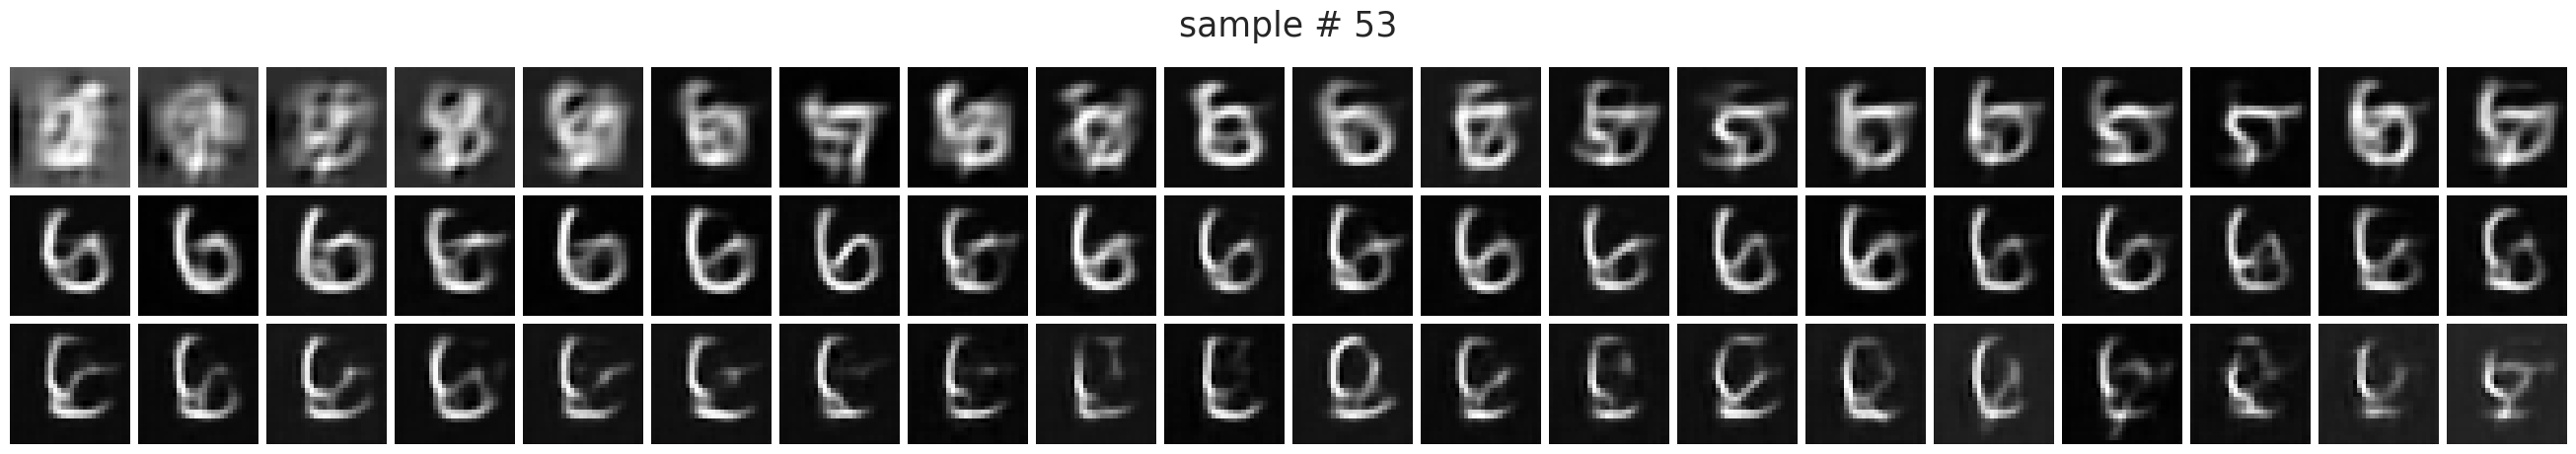

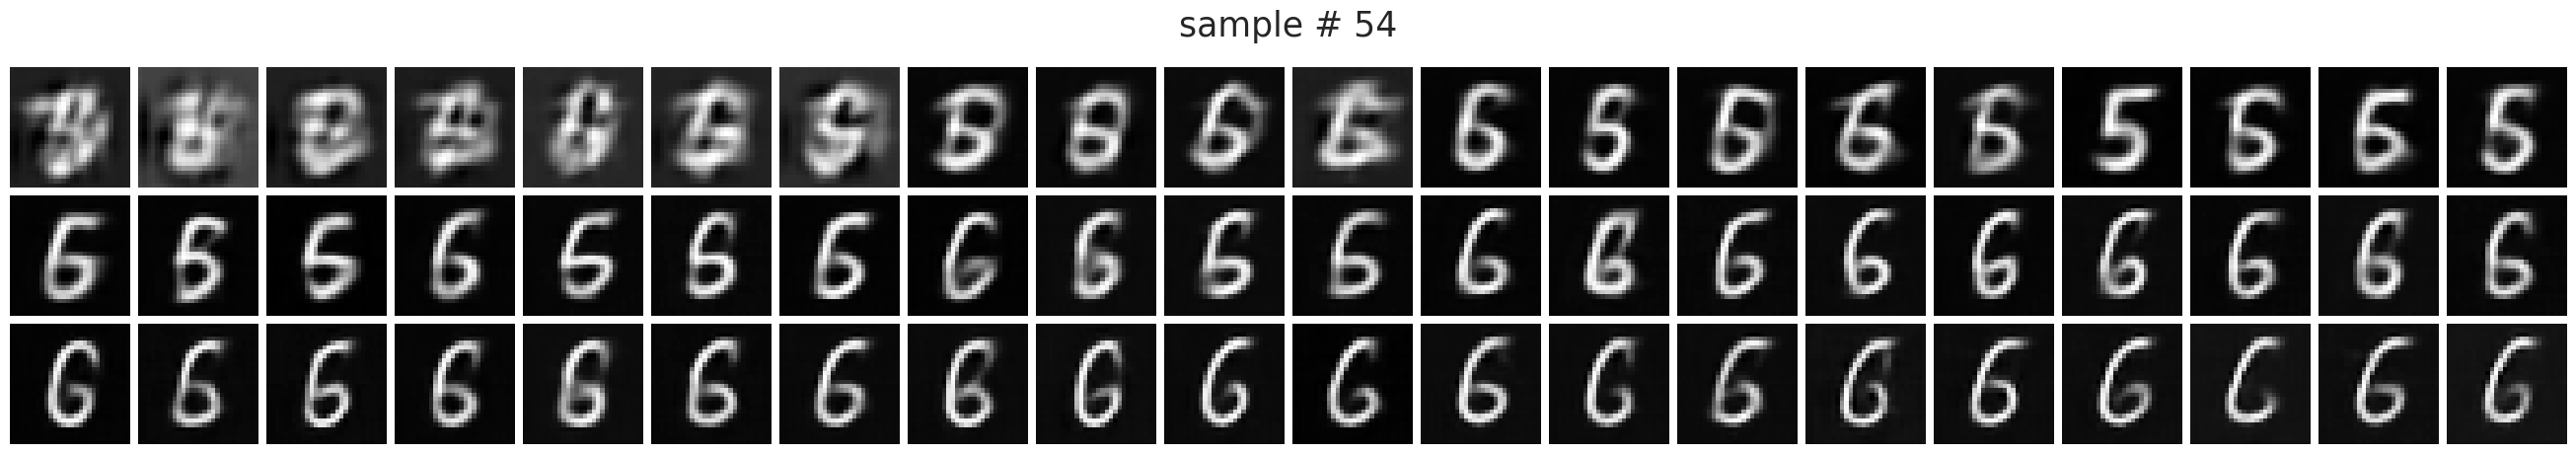

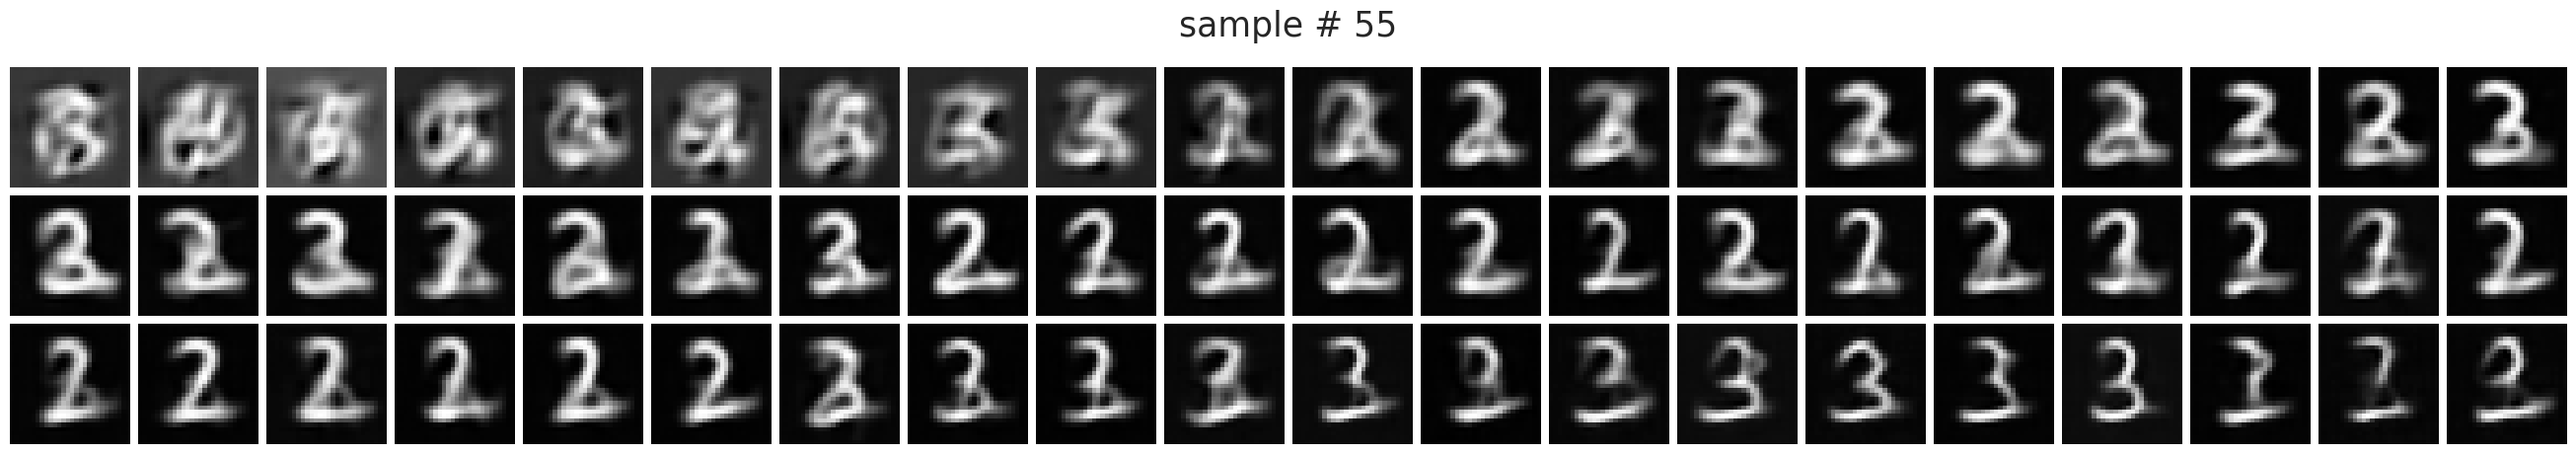

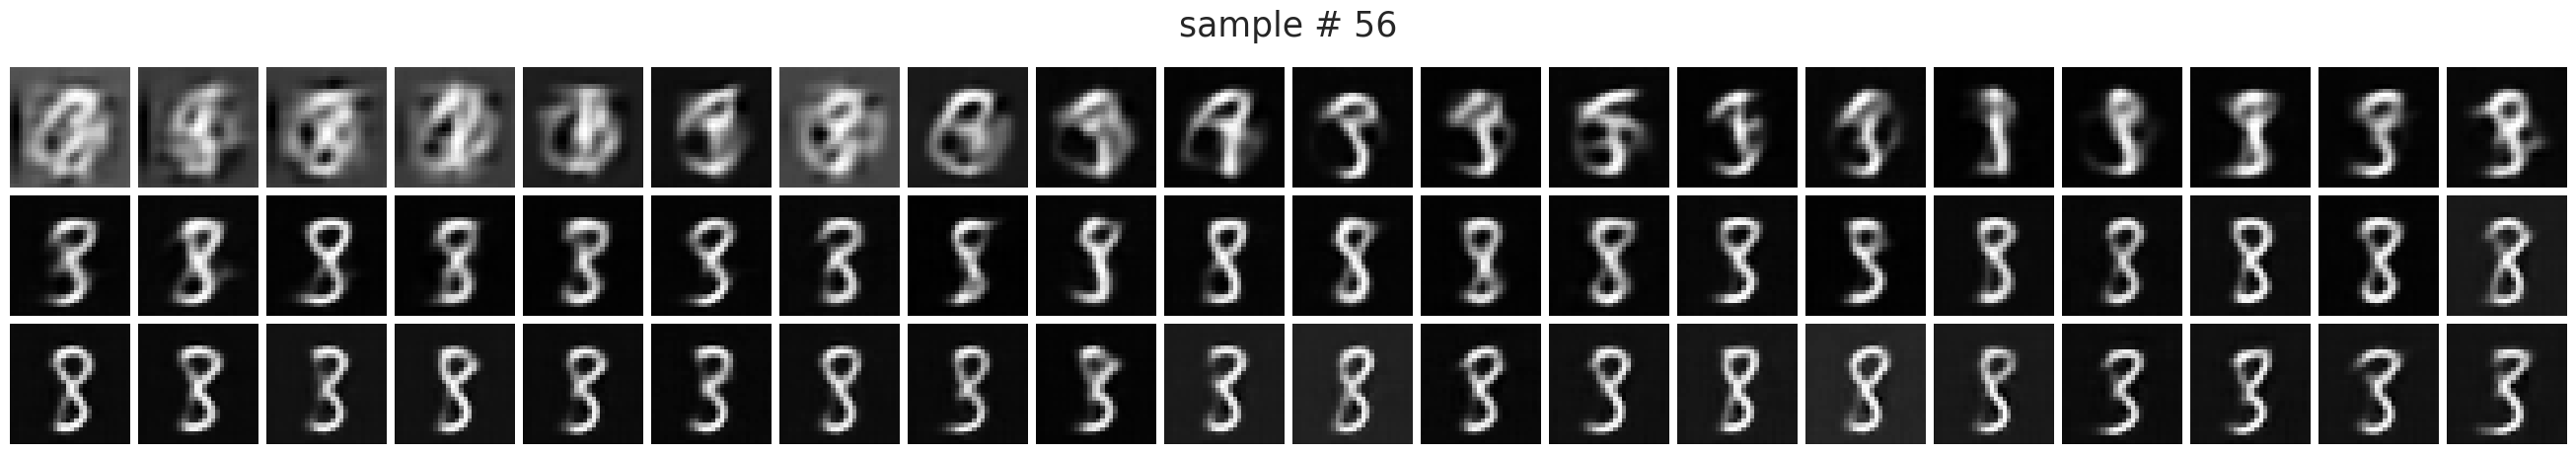

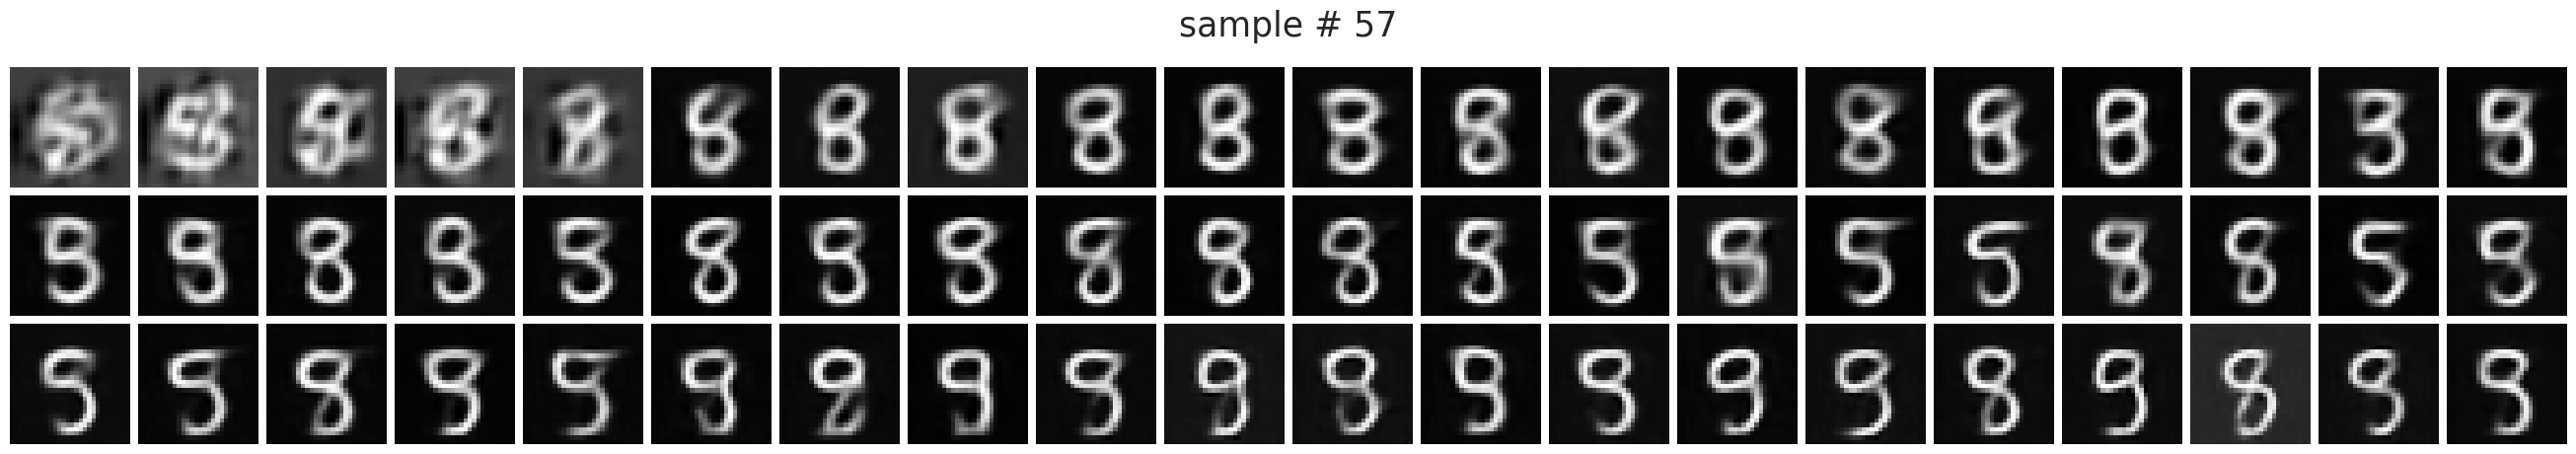

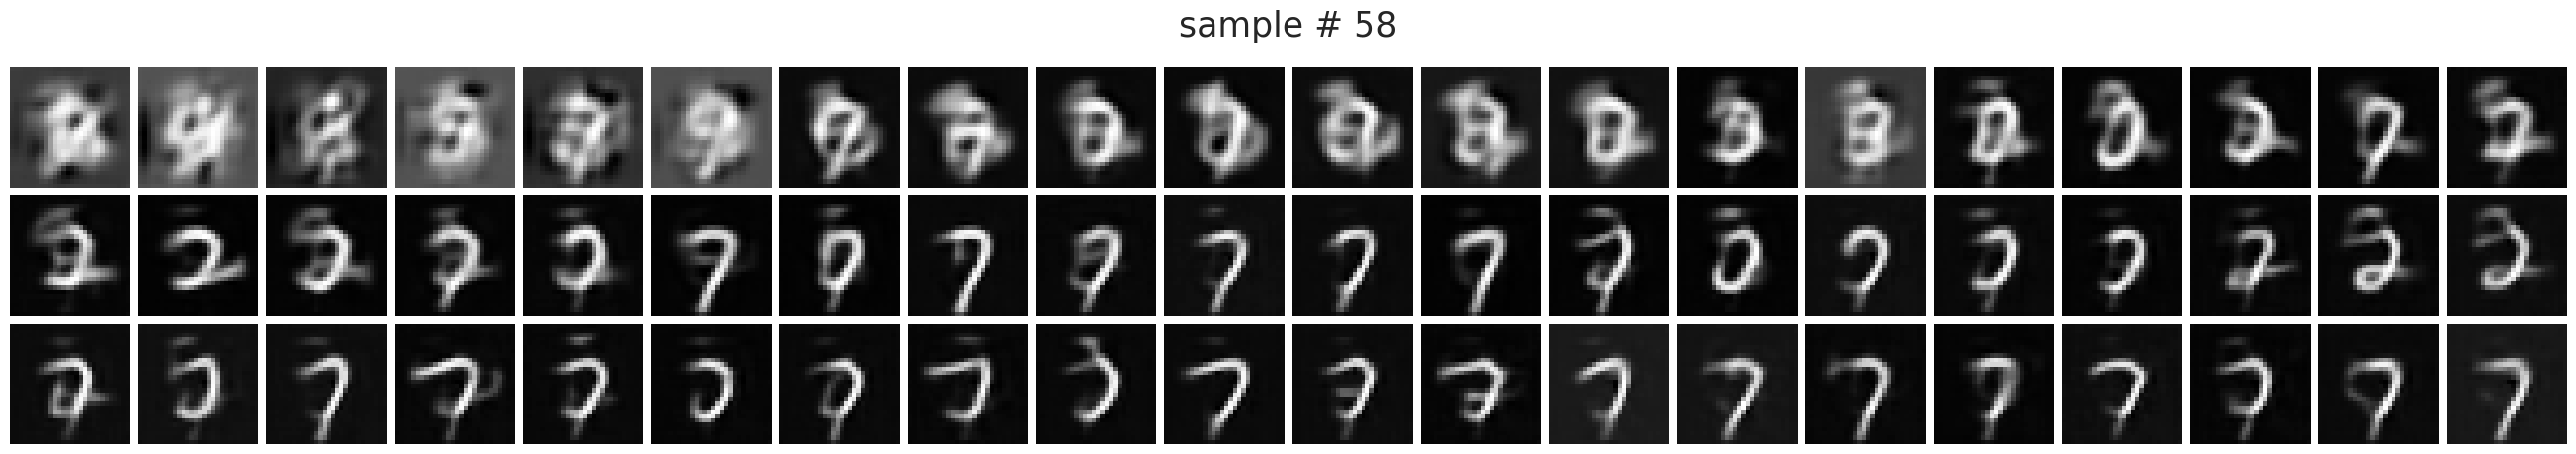

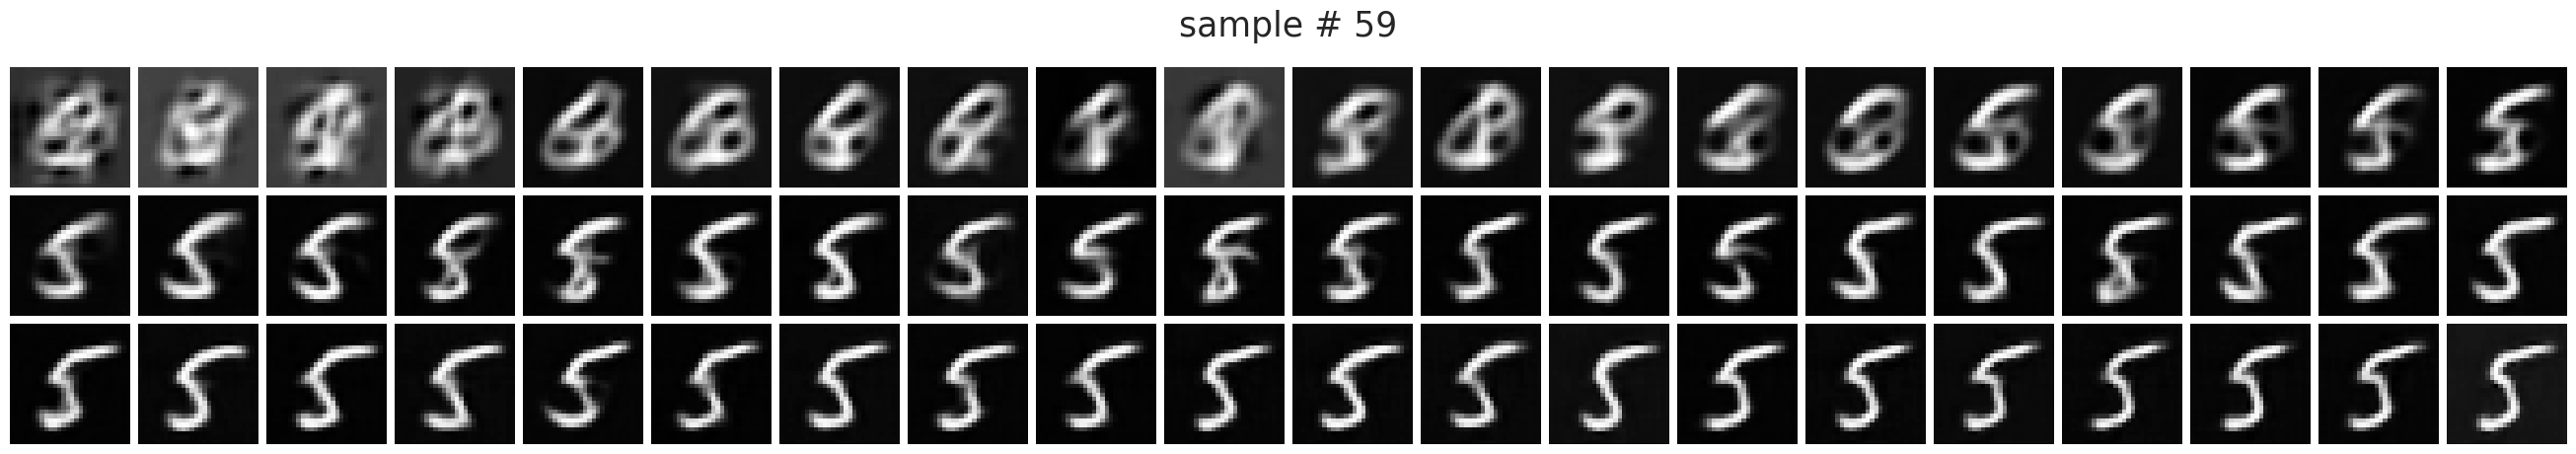

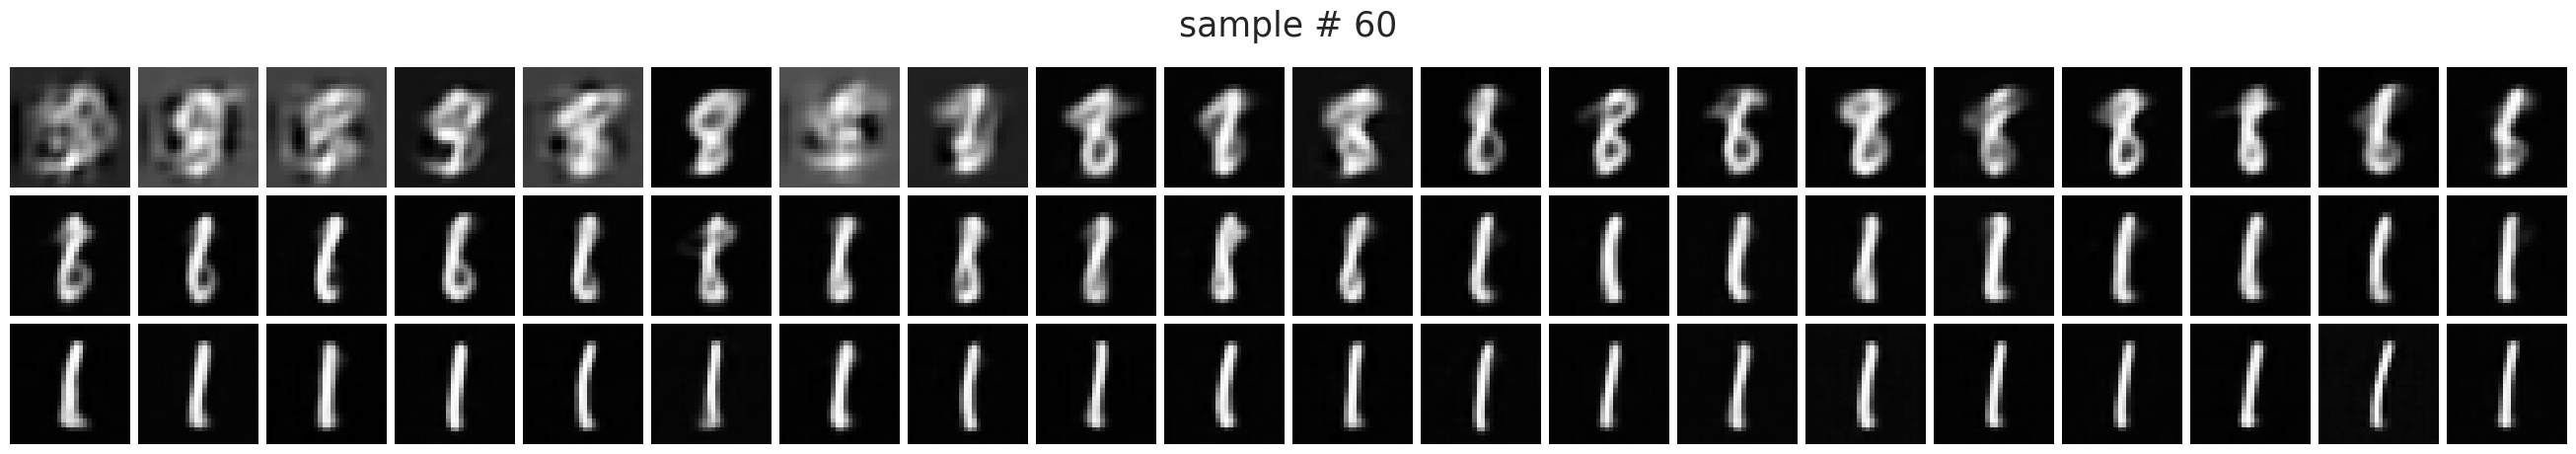

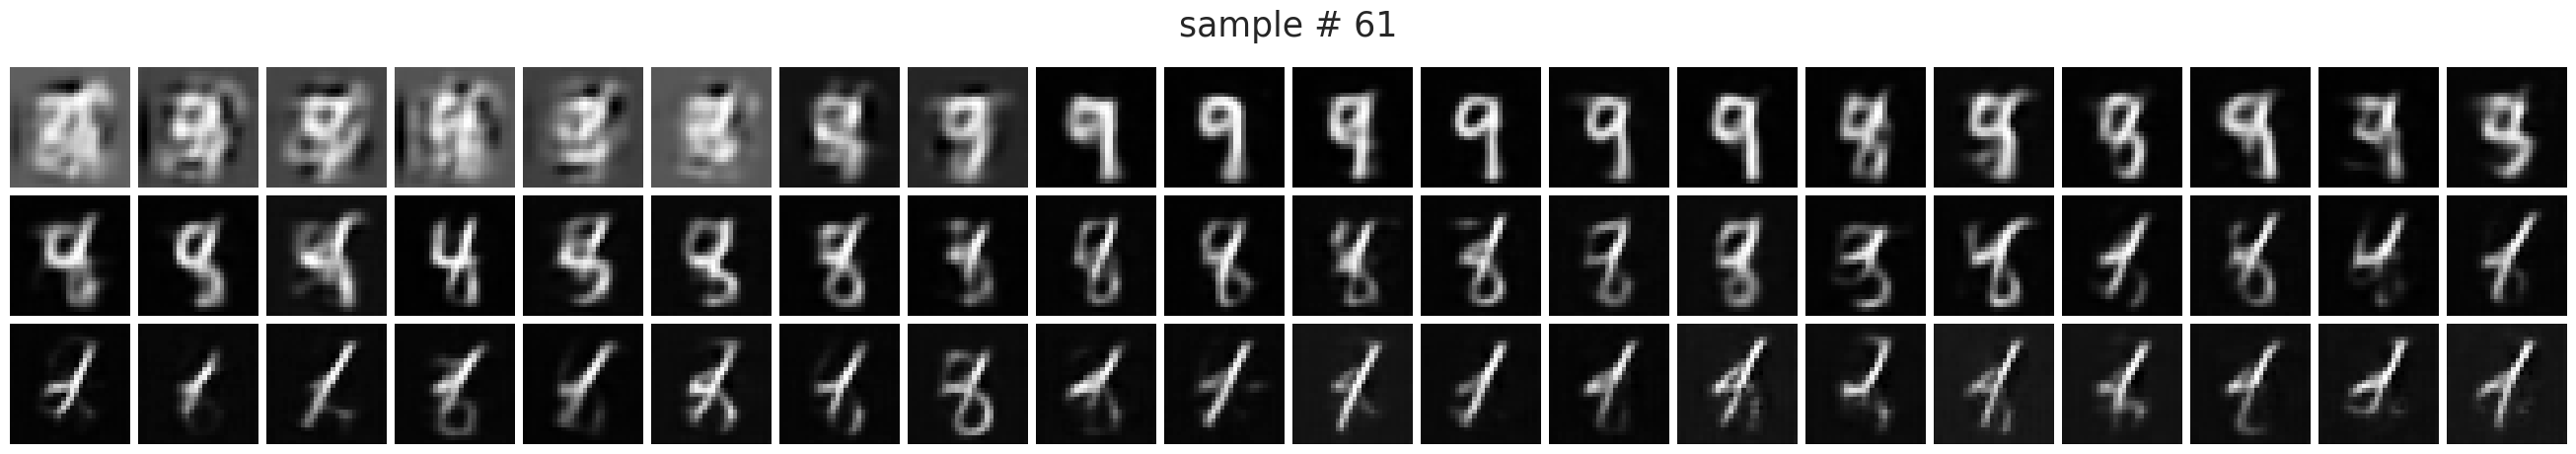

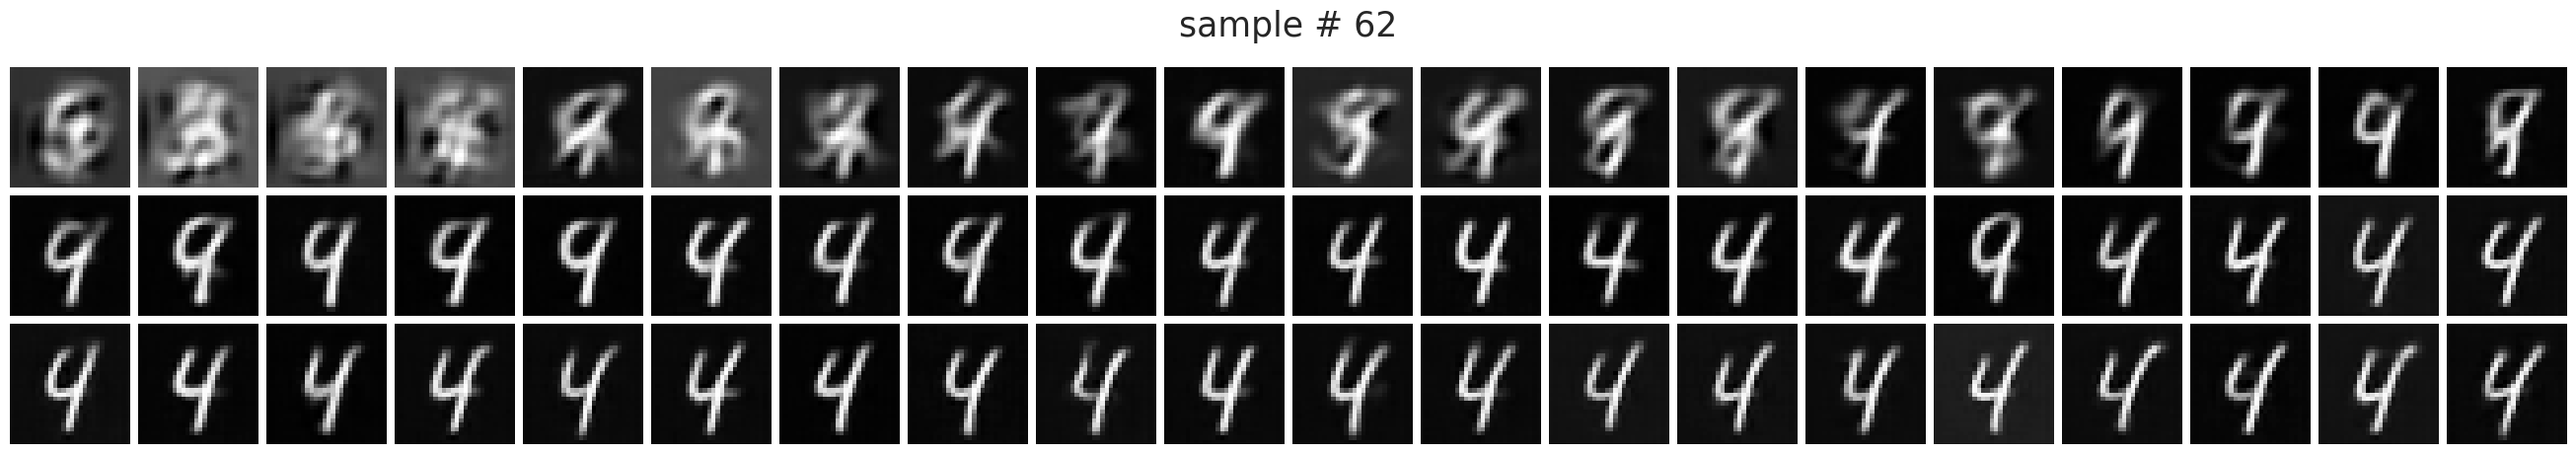

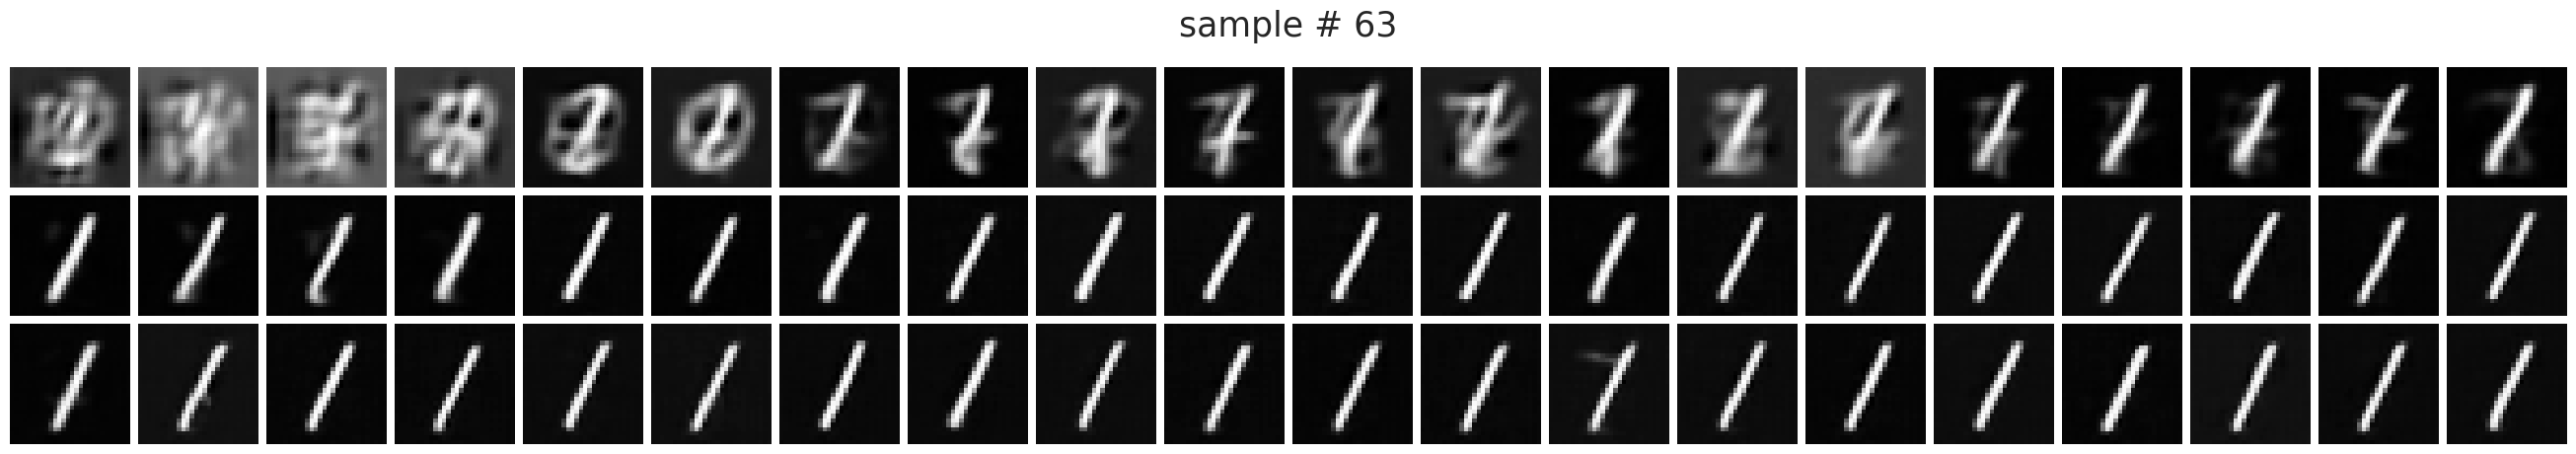

In [51]:
for sample_i in range(len(pred)):
    nrows, ncols = 3, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
    fig.suptitle(f"sample # {sample_i}", fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(28, 28))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

In [52]:
from figures.imgs import plot_weights

In [54]:
.shape

torch.Size([64, 784])

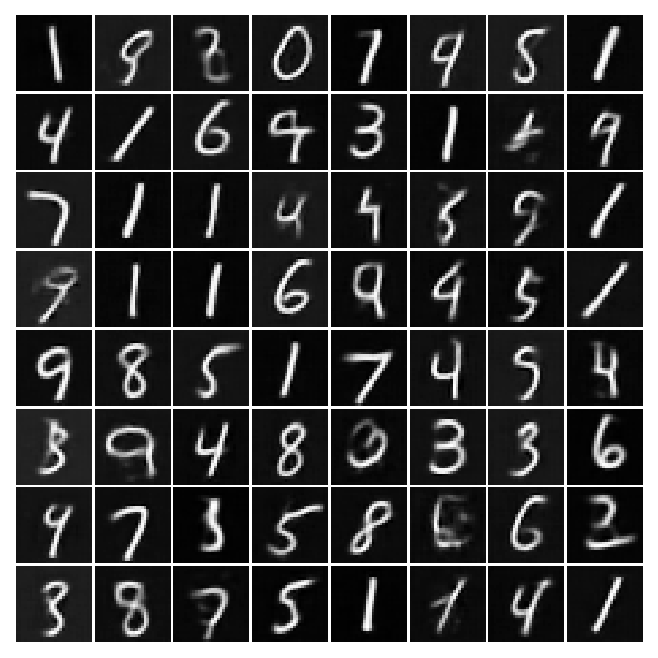

In [71]:
t = 60
x2p = tonp(output['recon'][:, t, :].reshape(-1, 28, 28))
plot_weights(x2p, nrows=8)
plt.show()